In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

/tmp/ipykernel_2605033/3445827236.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 udcaof5y


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-udcaof5y:best, 58.50MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.2


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                        | 1/2934 [00:00<34:45,  1.41it/s]

  0%|                                                                                                        | 2/2934 [00:00<20:39,  2.37it/s]

  0%|                                                                                                        | 3/2934 [00:01<16:06,  3.03it/s]

  0%|▏                                                                                                       | 4/2934 [00:01<13:58,  3.49it/s]

  0%|▏                                                                                                       | 5/2934 [00:01<12:47,  3.82it/s]

  0%|▏                                                                                                       | 6/2934 [00:01<12:04,  4.04it/s]

  0%|▏                                                                                                       | 7/2934 [00:02<11:37,  4.20it/s]

  0%|▎                                                                                                       | 8/2934 [00:02<11:20,  4.30it/s]

  0%|▎                                                                                                       | 9/2934 [00:02<11:07,  4.38it/s]

  0%|▎                                                                                                      | 10/2934 [00:02<10:59,  4.43it/s]

  0%|▍                                                                                                      | 11/2934 [00:02<10:54,  4.47it/s]

  0%|▍                                                                                                      | 12/2934 [00:03<10:50,  4.49it/s]

  0%|▍                                                                                                      | 13/2934 [00:03<10:47,  4.51it/s]

  0%|▍                                                                                                      | 14/2934 [00:03<10:44,  4.53it/s]

  1%|▌                                                                                                      | 15/2934 [00:03<10:43,  4.54it/s]

  1%|▌                                                                                                      | 16/2934 [00:04<10:41,  4.55it/s]

  1%|▌                                                                                                      | 17/2934 [00:04<10:40,  4.55it/s]

  1%|▋                                                                                                      | 18/2934 [00:04<10:40,  4.55it/s]

  1%|▋                                                                                                      | 19/2934 [00:04<10:40,  4.55it/s]

  1%|▋                                                                                                      | 20/2934 [00:04<10:39,  4.55it/s]

  1%|▋                                                                                                      | 21/2934 [00:05<10:39,  4.56it/s]

  1%|▊                                                                                                      | 22/2934 [00:05<10:39,  4.55it/s]

  1%|▊                                                                                                      | 23/2934 [00:05<10:39,  4.56it/s]

  1%|▊                                                                                                      | 24/2934 [00:05<10:38,  4.56it/s]

  1%|▉                                                                                                      | 25/2934 [00:05<10:38,  4.55it/s]

  1%|▉                                                                                                      | 26/2934 [00:06<10:38,  4.56it/s]

  1%|▉                                                                                                      | 27/2934 [00:06<10:37,  4.56it/s]

  1%|▉                                                                                                      | 28/2934 [00:06<10:37,  4.56it/s]

  1%|█                                                                                                      | 29/2934 [00:06<10:37,  4.56it/s]

  1%|█                                                                                                      | 30/2934 [00:07<10:37,  4.56it/s]

  1%|█                                                                                                      | 31/2934 [00:07<10:37,  4.56it/s]

  1%|█                                                                                                      | 32/2934 [00:07<10:37,  4.55it/s]

  1%|█▏                                                                                                     | 33/2934 [00:07<10:36,  4.56it/s]

  1%|█▏                                                                                                     | 34/2934 [00:07<10:36,  4.56it/s]

  1%|█▏                                                                                                     | 35/2934 [00:08<10:35,  4.56it/s]

  1%|█▎                                                                                                     | 36/2934 [00:08<10:35,  4.56it/s]

  1%|█▎                                                                                                     | 37/2934 [00:08<10:35,  4.56it/s]

  1%|█▎                                                                                                     | 38/2934 [00:08<10:34,  4.56it/s]

  1%|█▎                                                                                                     | 39/2934 [00:09<10:35,  4.56it/s]

  1%|█▍                                                                                                     | 40/2934 [00:09<10:34,  4.56it/s]

  1%|█▍                                                                                                     | 41/2934 [00:09<10:34,  4.56it/s]

  1%|█▍                                                                                                     | 42/2934 [00:09<10:33,  4.56it/s]

  1%|█▌                                                                                                     | 43/2934 [00:09<10:34,  4.56it/s]

  1%|█▌                                                                                                     | 44/2934 [00:10<10:33,  4.56it/s]

  2%|█▌                                                                                                     | 45/2934 [00:10<10:33,  4.56it/s]

  2%|█▌                                                                                                     | 46/2934 [00:10<10:33,  4.56it/s]

  2%|█▋                                                                                                     | 47/2934 [00:10<10:33,  4.56it/s]

  2%|█▋                                                                                                     | 48/2934 [00:11<10:32,  4.56it/s]

  2%|█▋                                                                                                     | 49/2934 [00:11<10:32,  4.56it/s]

  2%|█▊                                                                                                     | 50/2934 [00:11<10:32,  4.56it/s]

  2%|█▊                                                                                                     | 51/2934 [00:11<10:32,  4.56it/s]

  2%|█▊                                                                                                     | 52/2934 [00:11<10:32,  4.56it/s]

  2%|█▊                                                                                                     | 53/2934 [00:12<10:32,  4.56it/s]

  2%|█▉                                                                                                     | 54/2934 [00:12<10:31,  4.56it/s]

  2%|█▉                                                                                                     | 55/2934 [00:12<10:31,  4.56it/s]

  2%|█▉                                                                                                     | 56/2934 [00:12<10:31,  4.56it/s]

  2%|██                                                                                                     | 57/2934 [00:12<10:31,  4.56it/s]

  2%|██                                                                                                     | 58/2934 [00:13<10:30,  4.56it/s]

  2%|██                                                                                                     | 59/2934 [00:13<10:30,  4.56it/s]

  2%|██                                                                                                     | 60/2934 [00:13<10:30,  4.56it/s]

  2%|██▏                                                                                                    | 61/2934 [00:13<10:30,  4.56it/s]

  2%|██▏                                                                                                    | 62/2934 [00:14<10:30,  4.56it/s]

  2%|██▏                                                                                                    | 63/2934 [00:14<10:29,  4.56it/s]

  2%|██▏                                                                                                    | 64/2934 [00:14<10:30,  4.56it/s]

  2%|██▎                                                                                                    | 65/2934 [00:14<10:29,  4.56it/s]

  2%|██▎                                                                                                    | 66/2934 [00:14<10:29,  4.56it/s]

  2%|██▎                                                                                                    | 67/2934 [00:15<10:29,  4.55it/s]

  2%|██▍                                                                                                    | 68/2934 [00:15<10:29,  4.56it/s]

  2%|██▍                                                                                                    | 69/2934 [00:15<10:28,  4.56it/s]

  2%|██▍                                                                                                    | 70/2934 [00:15<10:28,  4.56it/s]

  2%|██▍                                                                                                    | 71/2934 [00:16<10:28,  4.55it/s]

  2%|██▌                                                                                                    | 72/2934 [00:16<10:28,  4.56it/s]

  2%|██▌                                                                                                    | 73/2934 [00:16<10:27,  4.56it/s]

  3%|██▌                                                                                                    | 74/2934 [00:16<10:27,  4.55it/s]

  3%|██▋                                                                                                    | 75/2934 [00:16<10:27,  4.56it/s]

  3%|██▋                                                                                                    | 76/2934 [00:17<10:26,  4.56it/s]

  3%|██▋                                                                                                    | 77/2934 [00:17<10:26,  4.56it/s]

  3%|██▋                                                                                                    | 78/2934 [00:17<10:26,  4.56it/s]

  3%|██▊                                                                                                    | 79/2934 [00:17<10:26,  4.56it/s]

  3%|██▊                                                                                                    | 80/2934 [00:18<10:25,  4.56it/s]

  3%|██▊                                                                                                    | 81/2934 [00:18<10:25,  4.56it/s]

  3%|██▉                                                                                                    | 82/2934 [00:18<10:25,  4.56it/s]

  3%|██▉                                                                                                    | 83/2934 [00:18<10:25,  4.56it/s]

  3%|██▉                                                                                                    | 84/2934 [00:18<10:24,  4.56it/s]

  3%|██▉                                                                                                    | 85/2934 [00:19<10:24,  4.56it/s]

  3%|███                                                                                                    | 86/2934 [00:19<10:24,  4.56it/s]

  3%|███                                                                                                    | 87/2934 [00:19<10:24,  4.56it/s]

  3%|███                                                                                                    | 88/2934 [00:19<10:24,  4.56it/s]

  3%|███                                                                                                    | 89/2934 [00:20<10:23,  4.56it/s]

  3%|███▏                                                                                                   | 90/2934 [00:20<10:23,  4.56it/s]

  3%|███▏                                                                                                   | 91/2934 [00:20<10:23,  4.56it/s]

  3%|███▏                                                                                                   | 92/2934 [00:20<10:23,  4.56it/s]

  3%|███▎                                                                                                   | 93/2934 [00:20<10:22,  4.56it/s]

  3%|███▎                                                                                                   | 94/2934 [00:21<10:22,  4.56it/s]

  3%|███▎                                                                                                   | 95/2934 [00:21<10:22,  4.56it/s]

  3%|███▎                                                                                                   | 96/2934 [00:21<10:22,  4.56it/s]

  3%|███▍                                                                                                   | 97/2934 [00:21<10:21,  4.56it/s]

  3%|███▍                                                                                                   | 98/2934 [00:21<10:21,  4.56it/s]

  3%|███▍                                                                                                   | 99/2934 [00:22<10:21,  4.56it/s]

  3%|███▍                                                                                                  | 100/2934 [00:22<10:21,  4.56it/s]

  3%|███▌                                                                                                  | 101/2934 [00:22<10:21,  4.56it/s]

  3%|███▌                                                                                                  | 102/2934 [00:22<10:21,  4.56it/s]

  4%|███▌                                                                                                  | 103/2934 [00:23<10:20,  4.56it/s]

  4%|███▌                                                                                                  | 104/2934 [00:23<10:20,  4.56it/s]

  4%|███▋                                                                                                  | 105/2934 [00:23<10:20,  4.56it/s]

  4%|███▋                                                                                                  | 106/2934 [00:23<10:20,  4.56it/s]

  4%|███▋                                                                                                  | 107/2934 [00:23<10:19,  4.56it/s]

  4%|███▊                                                                                                  | 108/2934 [00:24<10:19,  4.56it/s]

  4%|███▊                                                                                                  | 109/2934 [00:24<10:19,  4.56it/s]

  4%|███▊                                                                                                  | 110/2934 [00:24<10:19,  4.56it/s]

  4%|███▊                                                                                                  | 111/2934 [00:24<10:18,  4.56it/s]

  4%|███▉                                                                                                  | 112/2934 [00:25<10:18,  4.56it/s]

  4%|███▉                                                                                                  | 113/2934 [00:25<10:18,  4.56it/s]

  4%|███▉                                                                                                  | 114/2934 [00:25<10:18,  4.56it/s]

  4%|███▉                                                                                                  | 115/2934 [00:25<10:17,  4.56it/s]

  4%|████                                                                                                  | 116/2934 [00:25<10:18,  4.56it/s]

  4%|████                                                                                                  | 117/2934 [00:26<10:17,  4.56it/s]

  4%|████                                                                                                  | 118/2934 [00:26<10:17,  4.56it/s]

  4%|████▏                                                                                                 | 119/2934 [00:26<10:16,  4.56it/s]

  4%|████▏                                                                                                 | 120/2934 [00:26<10:17,  4.56it/s]

  4%|████▏                                                                                                 | 121/2934 [00:27<10:16,  4.56it/s]

  4%|████▏                                                                                                 | 122/2934 [00:27<10:16,  4.56it/s]

  4%|████▎                                                                                                 | 123/2934 [00:27<10:16,  4.56it/s]

  4%|████▎                                                                                                 | 124/2934 [00:27<10:16,  4.56it/s]

  4%|████▎                                                                                                 | 125/2934 [00:27<10:15,  4.56it/s]

  4%|████▍                                                                                                 | 126/2934 [00:28<10:15,  4.56it/s]

  4%|████▍                                                                                                 | 127/2934 [00:28<10:15,  4.56it/s]

  4%|████▍                                                                                                 | 128/2934 [00:28<10:15,  4.56it/s]

  4%|████▍                                                                                                 | 129/2934 [00:28<10:14,  4.56it/s]

  4%|████▌                                                                                                 | 130/2934 [00:29<10:14,  4.56it/s]

  4%|████▌                                                                                                 | 131/2934 [00:29<10:14,  4.56it/s]

  4%|████▌                                                                                                 | 132/2934 [00:29<10:14,  4.56it/s]

  5%|████▌                                                                                                 | 133/2934 [00:29<10:13,  4.56it/s]

  5%|████▋                                                                                                 | 134/2934 [00:29<10:14,  4.56it/s]

  5%|████▋                                                                                                 | 135/2934 [00:30<10:13,  4.56it/s]

  5%|████▋                                                                                                 | 136/2934 [00:30<10:13,  4.56it/s]

  5%|████▊                                                                                                 | 137/2934 [00:30<10:13,  4.56it/s]

  5%|████▊                                                                                                 | 138/2934 [00:30<10:13,  4.56it/s]

  5%|████▊                                                                                                 | 139/2934 [00:30<10:12,  4.56it/s]

  5%|████▊                                                                                                 | 140/2934 [00:31<10:12,  4.56it/s]

  5%|████▉                                                                                                 | 141/2934 [00:31<10:12,  4.56it/s]

  5%|████▉                                                                                                 | 142/2934 [00:31<10:12,  4.56it/s]

  5%|████▉                                                                                                 | 143/2934 [00:31<10:11,  4.56it/s]

  5%|█████                                                                                                 | 144/2934 [00:32<10:11,  4.56it/s]

  5%|█████                                                                                                 | 145/2934 [00:32<10:11,  4.56it/s]

  5%|█████                                                                                                 | 146/2934 [00:32<10:11,  4.56it/s]

  5%|█████                                                                                                 | 147/2934 [00:32<10:10,  4.56it/s]

  5%|█████▏                                                                                                | 148/2934 [00:32<10:10,  4.56it/s]

  5%|█████▏                                                                                                | 149/2934 [00:33<10:10,  4.56it/s]

  5%|█████▏                                                                                                | 150/2934 [00:33<10:10,  4.56it/s]

  5%|█████▏                                                                                                | 151/2934 [00:33<10:10,  4.56it/s]

  5%|█████▎                                                                                                | 152/2934 [00:33<10:10,  4.56it/s]

  5%|█████▎                                                                                                | 153/2934 [00:34<10:10,  4.56it/s]

  5%|█████▎                                                                                                | 154/2934 [00:34<10:09,  4.56it/s]

  5%|█████▍                                                                                                | 155/2934 [00:34<10:09,  4.56it/s]

  5%|█████▍                                                                                                | 156/2934 [00:34<10:09,  4.56it/s]

  5%|█████▍                                                                                                | 157/2934 [00:34<10:09,  4.56it/s]

  5%|█████▍                                                                                                | 158/2934 [00:35<10:09,  4.56it/s]

  5%|█████▌                                                                                                | 159/2934 [00:35<10:08,  4.56it/s]

  5%|█████▌                                                                                                | 160/2934 [00:35<10:08,  4.56it/s]

  5%|█████▌                                                                                                | 161/2934 [00:35<10:08,  4.56it/s]

  6%|█████▋                                                                                                | 162/2934 [00:36<10:08,  4.56it/s]

  6%|█████▋                                                                                                | 163/2934 [00:36<10:08,  4.56it/s]

  6%|█████▋                                                                                                | 164/2934 [00:36<10:07,  4.56it/s]

  6%|█████▋                                                                                                | 165/2934 [00:36<10:07,  4.56it/s]

  6%|█████▊                                                                                                | 166/2934 [00:36<10:07,  4.56it/s]

  6%|█████▊                                                                                                | 167/2934 [00:37<10:07,  4.56it/s]

  6%|█████▊                                                                                                | 168/2934 [00:37<10:06,  4.56it/s]

  6%|█████▉                                                                                                | 169/2934 [00:37<10:06,  4.56it/s]

  6%|█████▉                                                                                                | 170/2934 [00:37<10:06,  4.56it/s]

  6%|█████▉                                                                                                | 171/2934 [00:38<10:06,  4.56it/s]

  6%|█████▉                                                                                                | 172/2934 [00:38<10:06,  4.55it/s]

  6%|██████                                                                                                | 173/2934 [00:38<10:05,  4.56it/s]

  6%|██████                                                                                                | 174/2934 [00:38<10:05,  4.56it/s]

  6%|██████                                                                                                | 175/2934 [00:38<10:05,  4.56it/s]

  6%|██████                                                                                                | 176/2934 [00:39<10:05,  4.55it/s]

  6%|██████▏                                                                                               | 177/2934 [00:39<10:05,  4.56it/s]

  6%|██████▏                                                                                               | 178/2934 [00:39<10:04,  4.56it/s]

  6%|██████▏                                                                                               | 179/2934 [00:39<10:04,  4.55it/s]

  6%|██████▎                                                                                               | 180/2934 [00:39<10:04,  4.56it/s]

  6%|██████▎                                                                                               | 181/2934 [00:40<10:04,  4.56it/s]

  6%|██████▎                                                                                               | 182/2934 [00:40<10:03,  4.56it/s]

  6%|██████▎                                                                                               | 183/2934 [00:40<10:03,  4.56it/s]

  6%|██████▍                                                                                               | 184/2934 [00:40<10:02,  4.56it/s]

  6%|██████▍                                                                                               | 185/2934 [00:41<10:02,  4.56it/s]

  6%|██████▍                                                                                               | 186/2934 [00:41<10:02,  4.56it/s]

  6%|██████▌                                                                                               | 187/2934 [00:41<10:02,  4.56it/s]

  6%|██████▌                                                                                               | 188/2934 [00:41<10:01,  4.56it/s]

  6%|██████▌                                                                                               | 189/2934 [00:41<10:01,  4.56it/s]

  6%|██████▌                                                                                               | 190/2934 [00:42<10:01,  4.56it/s]

  7%|██████▋                                                                                               | 191/2934 [00:42<10:01,  4.56it/s]

  7%|██████▋                                                                                               | 192/2934 [00:42<10:01,  4.56it/s]

  7%|██████▋                                                                                               | 193/2934 [00:42<10:01,  4.56it/s]

  7%|██████▋                                                                                               | 194/2934 [00:43<10:00,  4.56it/s]

  7%|██████▊                                                                                               | 195/2934 [00:43<10:00,  4.56it/s]

  7%|██████▊                                                                                               | 196/2934 [00:43<10:00,  4.56it/s]

  7%|██████▊                                                                                               | 197/2934 [00:43<10:00,  4.56it/s]

  7%|██████▉                                                                                               | 198/2934 [00:43<10:00,  4.56it/s]

  7%|██████▉                                                                                               | 199/2934 [00:44<09:59,  4.56it/s]

  7%|██████▉                                                                                               | 200/2934 [00:44<09:59,  4.56it/s]

  7%|██████▉                                                                                               | 201/2934 [00:44<09:59,  4.56it/s]

  7%|███████                                                                                               | 202/2934 [00:44<09:58,  4.56it/s]

  7%|███████                                                                                               | 203/2934 [00:45<09:58,  4.56it/s]

  7%|███████                                                                                               | 204/2934 [00:45<09:58,  4.56it/s]

  7%|███████▏                                                                                              | 205/2934 [00:45<09:58,  4.56it/s]

  7%|███████▏                                                                                              | 206/2934 [00:45<09:57,  4.56it/s]

  7%|███████▏                                                                                              | 207/2934 [00:45<09:58,  4.56it/s]

  7%|███████▏                                                                                              | 208/2934 [00:46<09:57,  4.56it/s]

  7%|███████▎                                                                                              | 209/2934 [00:46<09:57,  4.56it/s]

  7%|███████▎                                                                                              | 210/2934 [00:46<09:56,  4.56it/s]

  7%|███████▎                                                                                              | 211/2934 [00:46<09:56,  4.56it/s]

  7%|███████▎                                                                                              | 212/2934 [00:46<09:56,  4.56it/s]

  7%|███████▍                                                                                              | 213/2934 [00:47<09:56,  4.56it/s]

  7%|███████▍                                                                                              | 214/2934 [00:47<09:57,  4.55it/s]

  7%|███████▍                                                                                              | 215/2934 [00:47<09:56,  4.56it/s]

  7%|███████▌                                                                                              | 216/2934 [00:47<09:56,  4.56it/s]

  7%|███████▌                                                                                              | 217/2934 [00:48<09:55,  4.56it/s]

  7%|███████▌                                                                                              | 218/2934 [00:48<09:55,  4.56it/s]

  7%|███████▌                                                                                              | 219/2934 [00:48<09:55,  4.56it/s]

  7%|███████▋                                                                                              | 220/2934 [00:48<09:54,  4.56it/s]

  8%|███████▋                                                                                              | 221/2934 [00:48<09:55,  4.56it/s]

  8%|███████▋                                                                                              | 222/2934 [00:49<09:54,  4.56it/s]

  8%|███████▊                                                                                              | 223/2934 [00:49<09:54,  4.56it/s]

  8%|███████▊                                                                                              | 224/2934 [00:49<09:54,  4.56it/s]

  8%|███████▊                                                                                              | 225/2934 [00:49<09:52,  4.57it/s]

  8%|███████▊                                                                                              | 226/2934 [00:50<09:51,  4.58it/s]

  8%|███████▉                                                                                              | 227/2934 [00:50<09:49,  4.59it/s]

  8%|███████▉                                                                                              | 228/2934 [00:50<09:49,  4.59it/s]

  8%|███████▉                                                                                              | 229/2934 [00:50<09:48,  4.60it/s]

  8%|███████▉                                                                                              | 230/2934 [00:50<09:47,  4.60it/s]

  8%|████████                                                                                              | 231/2934 [00:51<09:47,  4.60it/s]

  8%|████████                                                                                              | 232/2934 [00:51<09:47,  4.60it/s]

  8%|████████                                                                                              | 233/2934 [00:51<09:46,  4.60it/s]

  8%|████████▏                                                                                             | 234/2934 [00:51<09:46,  4.60it/s]

  8%|████████▏                                                                                             | 235/2934 [00:52<09:46,  4.60it/s]

  8%|████████▏                                                                                             | 236/2934 [00:52<09:46,  4.60it/s]

  8%|████████▏                                                                                             | 237/2934 [00:52<09:45,  4.60it/s]

  8%|████████▎                                                                                             | 238/2934 [00:52<09:45,  4.60it/s]

  8%|████████▎                                                                                             | 239/2934 [00:52<09:45,  4.60it/s]

  8%|████████▎                                                                                             | 240/2934 [00:53<09:45,  4.60it/s]

  8%|████████▍                                                                                             | 241/2934 [00:53<09:44,  4.60it/s]

  8%|████████▍                                                                                             | 242/2934 [00:53<09:44,  4.60it/s]

  8%|████████▍                                                                                             | 243/2934 [00:53<09:44,  4.60it/s]

  8%|████████▍                                                                                             | 244/2934 [00:53<09:44,  4.60it/s]

  8%|████████▌                                                                                             | 245/2934 [00:54<09:44,  4.60it/s]

  8%|████████▌                                                                                             | 246/2934 [00:54<09:44,  4.60it/s]

  8%|████████▌                                                                                             | 247/2934 [00:54<09:43,  4.60it/s]

  8%|████████▌                                                                                             | 248/2934 [00:54<09:43,  4.60it/s]

  8%|████████▋                                                                                             | 249/2934 [00:55<09:43,  4.60it/s]

  9%|████████▋                                                                                             | 250/2934 [00:55<09:43,  4.60it/s]

  9%|████████▋                                                                                             | 251/2934 [00:55<09:43,  4.60it/s]

  9%|████████▊                                                                                             | 252/2934 [00:55<09:43,  4.60it/s]

  9%|████████▊                                                                                             | 253/2934 [00:55<09:42,  4.60it/s]

  9%|████████▊                                                                                             | 254/2934 [00:56<09:42,  4.60it/s]

  9%|████████▊                                                                                             | 255/2934 [00:56<09:41,  4.60it/s]

  9%|████████▉                                                                                             | 256/2934 [00:56<09:41,  4.60it/s]

  9%|████████▉                                                                                             | 257/2934 [00:56<09:41,  4.60it/s]

  9%|████████▉                                                                                             | 258/2934 [00:57<09:41,  4.60it/s]

  9%|█████████                                                                                             | 259/2934 [00:57<09:41,  4.60it/s]

  9%|█████████                                                                                             | 260/2934 [00:57<09:40,  4.60it/s]

  9%|█████████                                                                                             | 261/2934 [00:57<09:40,  4.60it/s]

  9%|█████████                                                                                             | 262/2934 [00:57<09:40,  4.60it/s]

  9%|█████████▏                                                                                            | 263/2934 [00:58<09:40,  4.60it/s]

  9%|█████████▏                                                                                            | 264/2934 [00:58<09:39,  4.60it/s]

  9%|█████████▏                                                                                            | 265/2934 [00:58<09:39,  4.60it/s]

  9%|█████████▏                                                                                            | 266/2934 [00:58<09:39,  4.60it/s]

  9%|█████████▎                                                                                            | 267/2934 [00:58<09:39,  4.60it/s]

  9%|█████████▎                                                                                            | 268/2934 [00:59<09:39,  4.60it/s]

  9%|█████████▎                                                                                            | 269/2934 [00:59<09:38,  4.60it/s]

  9%|█████████▍                                                                                            | 270/2934 [00:59<09:38,  4.60it/s]

  9%|█████████▍                                                                                            | 271/2934 [00:59<09:38,  4.60it/s]

  9%|█████████▍                                                                                            | 272/2934 [01:00<09:38,  4.60it/s]

  9%|█████████▍                                                                                            | 273/2934 [01:00<09:38,  4.60it/s]

  9%|█████████▌                                                                                            | 274/2934 [01:00<09:37,  4.60it/s]

  9%|█████████▌                                                                                            | 275/2934 [01:00<09:37,  4.60it/s]

  9%|█████████▌                                                                                            | 276/2934 [01:00<09:37,  4.60it/s]

  9%|█████████▋                                                                                            | 277/2934 [01:01<09:37,  4.60it/s]

  9%|█████████▋                                                                                            | 278/2934 [01:01<09:37,  4.60it/s]

 10%|█████████▋                                                                                            | 279/2934 [01:01<09:36,  4.60it/s]

 10%|█████████▋                                                                                            | 280/2934 [01:01<09:36,  4.60it/s]

 10%|█████████▊                                                                                            | 281/2934 [01:02<09:36,  4.60it/s]

 10%|█████████▊                                                                                            | 282/2934 [01:02<09:36,  4.60it/s]

 10%|█████████▊                                                                                            | 283/2934 [01:02<09:35,  4.60it/s]

 10%|█████████▊                                                                                            | 284/2934 [01:02<09:35,  4.60it/s]

 10%|█████████▉                                                                                            | 285/2934 [01:02<09:35,  4.60it/s]

 10%|█████████▉                                                                                            | 286/2934 [01:03<09:35,  4.60it/s]

 10%|█████████▉                                                                                            | 287/2934 [01:03<09:35,  4.60it/s]

 10%|██████████                                                                                            | 288/2934 [01:03<09:34,  4.60it/s]

 10%|██████████                                                                                            | 289/2934 [01:03<09:34,  4.60it/s]

 10%|██████████                                                                                            | 290/2934 [01:03<09:34,  4.60it/s]

 10%|██████████                                                                                            | 291/2934 [01:04<09:34,  4.60it/s]

 10%|██████████▏                                                                                           | 292/2934 [01:04<09:33,  4.60it/s]

 10%|██████████▏                                                                                           | 293/2934 [01:04<09:33,  4.60it/s]

 10%|██████████▏                                                                                           | 294/2934 [01:04<09:33,  4.60it/s]

 10%|██████████▎                                                                                           | 295/2934 [01:05<09:33,  4.60it/s]

 10%|██████████▎                                                                                           | 296/2934 [01:05<09:33,  4.60it/s]

 10%|██████████▎                                                                                           | 297/2934 [01:05<09:33,  4.60it/s]

 10%|██████████▎                                                                                           | 298/2934 [01:05<09:32,  4.60it/s]

 10%|██████████▍                                                                                           | 299/2934 [01:05<09:32,  4.60it/s]

 10%|██████████▍                                                                                           | 300/2934 [01:06<09:32,  4.60it/s]

 10%|██████████▍                                                                                           | 301/2934 [01:06<09:32,  4.60it/s]

 10%|██████████▍                                                                                           | 302/2934 [01:06<09:31,  4.60it/s]

 10%|██████████▌                                                                                           | 303/2934 [01:06<09:31,  4.60it/s]

 10%|██████████▌                                                                                           | 304/2934 [01:07<09:31,  4.60it/s]

 10%|██████████▌                                                                                           | 305/2934 [01:07<09:31,  4.60it/s]

 10%|██████████▋                                                                                           | 306/2934 [01:07<09:30,  4.60it/s]

 10%|██████████▋                                                                                           | 307/2934 [01:07<09:30,  4.60it/s]

 10%|██████████▋                                                                                           | 308/2934 [01:07<09:30,  4.60it/s]

 11%|██████████▋                                                                                           | 309/2934 [01:08<09:30,  4.60it/s]

 11%|██████████▊                                                                                           | 310/2934 [01:08<09:29,  4.60it/s]

 11%|██████████▊                                                                                           | 311/2934 [01:08<09:29,  4.60it/s]

 11%|██████████▊                                                                                           | 312/2934 [01:08<09:29,  4.60it/s]

 11%|██████████▉                                                                                           | 313/2934 [01:08<09:29,  4.60it/s]

 11%|██████████▉                                                                                           | 314/2934 [01:09<09:29,  4.60it/s]

 11%|██████████▉                                                                                           | 315/2934 [01:09<09:29,  4.60it/s]

 11%|██████████▉                                                                                           | 316/2934 [01:09<09:28,  4.60it/s]

 11%|███████████                                                                                           | 317/2934 [01:09<09:28,  4.60it/s]

 11%|███████████                                                                                           | 318/2934 [01:10<09:28,  4.60it/s]

 11%|███████████                                                                                           | 319/2934 [01:10<09:28,  4.60it/s]

 11%|███████████                                                                                           | 320/2934 [01:10<09:27,  4.60it/s]

 11%|███████████▏                                                                                          | 321/2934 [01:10<09:27,  4.60it/s]

 11%|███████████▏                                                                                          | 322/2934 [01:10<09:27,  4.60it/s]

 11%|███████████▏                                                                                          | 323/2934 [01:11<09:27,  4.60it/s]

 11%|███████████▎                                                                                          | 324/2934 [01:11<09:26,  4.60it/s]

 11%|███████████▎                                                                                          | 325/2934 [01:11<09:26,  4.60it/s]

 11%|███████████▎                                                                                          | 326/2934 [01:11<09:26,  4.60it/s]

 11%|███████████▎                                                                                          | 327/2934 [01:12<09:26,  4.60it/s]

 11%|███████████▍                                                                                          | 328/2934 [01:12<09:26,  4.60it/s]

 11%|███████████▍                                                                                          | 329/2934 [01:12<09:25,  4.60it/s]

 11%|███████████▍                                                                                          | 330/2934 [01:12<09:25,  4.60it/s]

 11%|███████████▌                                                                                          | 331/2934 [01:12<09:25,  4.60it/s]

 11%|███████████▌                                                                                          | 332/2934 [01:13<09:25,  4.60it/s]

 11%|███████████▌                                                                                          | 333/2934 [01:13<09:25,  4.60it/s]

 11%|███████████▌                                                                                          | 334/2934 [01:13<09:24,  4.60it/s]

 11%|███████████▋                                                                                          | 335/2934 [01:13<09:24,  4.60it/s]

 11%|███████████▋                                                                                          | 336/2934 [01:13<09:24,  4.60it/s]

 11%|███████████▋                                                                                          | 337/2934 [01:14<09:24,  4.60it/s]

 12%|███████████▊                                                                                          | 338/2934 [01:14<09:24,  4.60it/s]

 12%|███████████▊                                                                                          | 339/2934 [01:14<09:23,  4.60it/s]

 12%|███████████▊                                                                                          | 340/2934 [01:14<09:23,  4.60it/s]

 12%|███████████▊                                                                                          | 341/2934 [01:15<09:23,  4.60it/s]

 12%|███████████▉                                                                                          | 342/2934 [01:15<09:23,  4.60it/s]

 12%|███████████▉                                                                                          | 343/2934 [01:15<09:22,  4.60it/s]

 12%|███████████▉                                                                                          | 344/2934 [01:15<09:22,  4.60it/s]

 12%|███████████▉                                                                                          | 345/2934 [01:15<09:22,  4.60it/s]

 12%|████████████                                                                                          | 346/2934 [01:16<09:22,  4.60it/s]

 12%|████████████                                                                                          | 347/2934 [01:16<09:22,  4.60it/s]

 12%|████████████                                                                                          | 348/2934 [01:16<09:21,  4.60it/s]

 12%|████████████▏                                                                                         | 349/2934 [01:16<09:21,  4.60it/s]

 12%|████████████▏                                                                                         | 350/2934 [01:16<09:21,  4.60it/s]

 12%|████████████▏                                                                                         | 351/2934 [01:17<09:21,  4.60it/s]

 12%|████████████▏                                                                                         | 352/2934 [01:17<09:20,  4.60it/s]

 12%|████████████▎                                                                                         | 353/2934 [01:17<09:20,  4.60it/s]

 12%|████████████▎                                                                                         | 354/2934 [01:17<09:20,  4.60it/s]

 12%|████████████▎                                                                                         | 355/2934 [01:18<09:20,  4.60it/s]

 12%|████████████▍                                                                                         | 356/2934 [01:18<09:20,  4.60it/s]

 12%|████████████▍                                                                                         | 357/2934 [01:18<09:19,  4.60it/s]

 12%|████████████▍                                                                                         | 358/2934 [01:18<09:19,  4.60it/s]

 12%|████████████▍                                                                                         | 359/2934 [01:18<09:19,  4.60it/s]

 12%|████████████▌                                                                                         | 360/2934 [01:19<09:19,  4.60it/s]

 12%|████████████▌                                                                                         | 361/2934 [01:19<09:18,  4.60it/s]

 12%|████████████▌                                                                                         | 362/2934 [01:19<09:18,  4.60it/s]

 12%|████████████▌                                                                                         | 363/2934 [01:19<09:18,  4.60it/s]

 12%|████████████▋                                                                                         | 364/2934 [01:20<09:18,  4.60it/s]

 12%|████████████▋                                                                                         | 365/2934 [01:20<09:17,  4.60it/s]

 12%|████████████▋                                                                                         | 366/2934 [01:20<09:18,  4.60it/s]

 13%|████████████▊                                                                                         | 367/2934 [01:20<09:17,  4.60it/s]

 13%|████████████▊                                                                                         | 368/2934 [01:20<09:17,  4.60it/s]

 13%|████████████▊                                                                                         | 369/2934 [01:21<09:17,  4.60it/s]

 13%|████████████▊                                                                                         | 370/2934 [01:21<09:16,  4.60it/s]

 13%|████████████▉                                                                                         | 371/2934 [01:21<09:16,  4.60it/s]

 13%|████████████▉                                                                                         | 372/2934 [01:21<09:16,  4.60it/s]

 13%|████████████▉                                                                                         | 373/2934 [01:21<09:16,  4.60it/s]

 13%|█████████████                                                                                         | 374/2934 [01:22<09:16,  4.60it/s]

 13%|█████████████                                                                                         | 375/2934 [01:22<09:15,  4.60it/s]

 13%|█████████████                                                                                         | 376/2934 [01:22<09:15,  4.60it/s]

 13%|█████████████                                                                                         | 377/2934 [01:22<09:15,  4.60it/s]

 13%|█████████████▏                                                                                        | 378/2934 [01:23<09:15,  4.60it/s]

 13%|█████████████▏                                                                                        | 379/2934 [01:23<09:14,  4.60it/s]

 13%|█████████████▏                                                                                        | 380/2934 [01:23<09:14,  4.60it/s]

 13%|█████████████▏                                                                                        | 381/2934 [01:23<09:14,  4.60it/s]

 13%|█████████████▎                                                                                        | 382/2934 [01:23<09:14,  4.60it/s]

 13%|█████████████▎                                                                                        | 383/2934 [01:24<09:14,  4.60it/s]

 13%|█████████████▎                                                                                        | 384/2934 [01:24<09:13,  4.60it/s]

 13%|█████████████▍                                                                                        | 385/2934 [01:24<09:13,  4.60it/s]

 13%|█████████████▍                                                                                        | 386/2934 [01:24<09:13,  4.60it/s]

 13%|█████████████▍                                                                                        | 387/2934 [01:25<09:13,  4.60it/s]

 13%|█████████████▍                                                                                        | 388/2934 [01:25<09:13,  4.60it/s]

 13%|█████████████▌                                                                                        | 389/2934 [01:25<09:12,  4.60it/s]

 13%|█████████████▌                                                                                        | 390/2934 [01:25<09:12,  4.60it/s]

 13%|█████████████▌                                                                                        | 391/2934 [01:25<09:12,  4.60it/s]

 13%|█████████████▋                                                                                        | 392/2934 [01:26<09:12,  4.60it/s]

 13%|█████████████▋                                                                                        | 393/2934 [01:26<09:11,  4.60it/s]

 13%|█████████████▋                                                                                        | 394/2934 [01:26<09:11,  4.60it/s]

 13%|█████████████▋                                                                                        | 395/2934 [01:26<09:11,  4.60it/s]

 13%|█████████████▊                                                                                        | 396/2934 [01:26<09:11,  4.60it/s]

 14%|█████████████▊                                                                                        | 397/2934 [01:27<09:11,  4.60it/s]

 14%|█████████████▊                                                                                        | 398/2934 [01:27<09:10,  4.60it/s]

 14%|█████████████▊                                                                                        | 399/2934 [01:27<09:10,  4.60it/s]

 14%|█████████████▉                                                                                        | 400/2934 [01:27<09:10,  4.60it/s]

 14%|█████████████▉                                                                                        | 401/2934 [01:28<09:10,  4.60it/s]

 14%|█████████████▉                                                                                        | 402/2934 [01:28<09:10,  4.60it/s]

 14%|██████████████                                                                                        | 403/2934 [01:28<09:10,  4.60it/s]

 14%|██████████████                                                                                        | 404/2934 [01:28<09:09,  4.60it/s]

 14%|██████████████                                                                                        | 405/2934 [01:28<09:09,  4.60it/s]

 14%|██████████████                                                                                        | 406/2934 [01:29<09:09,  4.60it/s]

 14%|██████████████▏                                                                                       | 407/2934 [01:29<09:08,  4.60it/s]

 14%|██████████████▏                                                                                       | 408/2934 [01:29<09:08,  4.60it/s]

 14%|██████████████▏                                                                                       | 409/2934 [01:29<09:08,  4.60it/s]

 14%|██████████████▎                                                                                       | 410/2934 [01:30<09:08,  4.60it/s]

 14%|██████████████▎                                                                                       | 411/2934 [01:30<09:08,  4.60it/s]

 14%|██████████████▎                                                                                       | 412/2934 [01:30<09:07,  4.60it/s]

 14%|██████████████▎                                                                                       | 413/2934 [01:30<09:07,  4.60it/s]

 14%|██████████████▍                                                                                       | 414/2934 [01:30<09:07,  4.60it/s]

 14%|██████████████▍                                                                                       | 415/2934 [01:31<09:07,  4.60it/s]

 14%|██████████████▍                                                                                       | 416/2934 [01:31<09:06,  4.60it/s]

 14%|██████████████▍                                                                                       | 417/2934 [01:31<09:06,  4.60it/s]

 14%|██████████████▌                                                                                       | 418/2934 [01:31<09:06,  4.60it/s]

 14%|██████████████▌                                                                                       | 419/2934 [01:31<09:06,  4.60it/s]

 14%|██████████████▌                                                                                       | 420/2934 [01:32<09:06,  4.60it/s]

 14%|██████████████▋                                                                                       | 421/2934 [01:32<09:06,  4.60it/s]

 14%|██████████████▋                                                                                       | 422/2934 [01:32<09:05,  4.60it/s]

 14%|██████████████▋                                                                                       | 423/2934 [01:32<09:05,  4.60it/s]

 14%|██████████████▋                                                                                       | 424/2934 [01:33<09:05,  4.60it/s]

 14%|██████████████▊                                                                                       | 425/2934 [01:33<09:05,  4.60it/s]

 15%|██████████████▊                                                                                       | 426/2934 [01:33<09:04,  4.60it/s]

 15%|██████████████▊                                                                                       | 427/2934 [01:33<09:04,  4.60it/s]

 15%|██████████████▉                                                                                       | 428/2934 [01:33<09:04,  4.60it/s]

 15%|██████████████▉                                                                                       | 429/2934 [01:34<09:04,  4.60it/s]

 15%|██████████████▉                                                                                       | 430/2934 [01:34<09:03,  4.60it/s]

 15%|██████████████▉                                                                                       | 431/2934 [01:34<09:03,  4.60it/s]

 15%|███████████████                                                                                       | 432/2934 [01:34<09:03,  4.60it/s]

 15%|███████████████                                                                                       | 433/2934 [01:35<09:03,  4.60it/s]

 15%|███████████████                                                                                       | 434/2934 [01:35<09:03,  4.60it/s]

 15%|███████████████                                                                                       | 435/2934 [01:35<09:02,  4.60it/s]

 15%|███████████████▏                                                                                      | 436/2934 [01:35<09:02,  4.60it/s]

 15%|███████████████▏                                                                                      | 437/2934 [01:35<09:02,  4.60it/s]

 15%|███████████████▏                                                                                      | 438/2934 [01:36<09:02,  4.60it/s]

 15%|███████████████▎                                                                                      | 439/2934 [01:36<09:01,  4.60it/s]

 15%|███████████████▎                                                                                      | 440/2934 [01:36<09:01,  4.60it/s]

 15%|███████████████▎                                                                                      | 441/2934 [01:36<09:01,  4.60it/s]

 15%|███████████████▎                                                                                      | 442/2934 [01:36<09:01,  4.60it/s]

 15%|███████████████▍                                                                                      | 443/2934 [01:37<09:01,  4.60it/s]

 15%|███████████████▍                                                                                      | 444/2934 [01:37<09:00,  4.60it/s]

 15%|███████████████▍                                                                                      | 445/2934 [01:37<09:00,  4.60it/s]

 15%|███████████████▌                                                                                      | 446/2934 [01:37<09:00,  4.60it/s]

 15%|███████████████▌                                                                                      | 447/2934 [01:38<09:00,  4.60it/s]

 15%|███████████████▌                                                                                      | 448/2934 [01:38<09:00,  4.60it/s]

 15%|███████████████▌                                                                                      | 449/2934 [01:38<08:59,  4.60it/s]

 15%|███████████████▋                                                                                      | 450/2934 [01:38<08:59,  4.60it/s]

 15%|███████████████▋                                                                                      | 451/2934 [01:38<08:59,  4.60it/s]

 15%|███████████████▋                                                                                      | 452/2934 [01:39<08:59,  4.60it/s]

 15%|███████████████▋                                                                                      | 453/2934 [01:39<08:59,  4.60it/s]

 15%|███████████████▊                                                                                      | 454/2934 [01:39<08:59,  4.60it/s]

 16%|███████████████▊                                                                                      | 455/2934 [01:39<08:58,  4.60it/s]

 16%|███████████████▊                                                                                      | 456/2934 [01:40<08:58,  4.60it/s]

 16%|███████████████▉                                                                                      | 457/2934 [01:40<08:57,  4.60it/s]

 16%|███████████████▉                                                                                      | 458/2934 [01:40<08:58,  4.60it/s]

 16%|███████████████▉                                                                                      | 459/2934 [01:40<08:57,  4.60it/s]

 16%|███████████████▉                                                                                      | 460/2934 [01:40<08:57,  4.60it/s]

 16%|████████████████                                                                                      | 461/2934 [01:41<08:57,  4.60it/s]

 16%|████████████████                                                                                      | 462/2934 [01:41<08:57,  4.60it/s]

 16%|████████████████                                                                                      | 463/2934 [01:41<08:56,  4.60it/s]

 16%|████████████████▏                                                                                     | 464/2934 [01:41<08:56,  4.60it/s]

 16%|████████████████▏                                                                                     | 465/2934 [01:41<08:56,  4.60it/s]

 16%|████████████████▏                                                                                     | 466/2934 [01:42<08:56,  4.60it/s]

 16%|████████████████▏                                                                                     | 467/2934 [01:42<08:55,  4.60it/s]

 16%|████████████████▎                                                                                     | 468/2934 [01:42<08:55,  4.60it/s]

 16%|████████████████▎                                                                                     | 469/2934 [01:42<08:55,  4.60it/s]

 16%|████████████████▎                                                                                     | 470/2934 [01:43<08:55,  4.60it/s]

 16%|████████████████▎                                                                                     | 471/2934 [01:43<08:54,  4.60it/s]

 16%|████████████████▍                                                                                     | 472/2934 [01:43<08:54,  4.60it/s]

 16%|████████████████▍                                                                                     | 473/2934 [01:43<08:54,  4.60it/s]

 16%|████████████████▍                                                                                     | 474/2934 [01:43<08:54,  4.60it/s]

 16%|████████████████▌                                                                                     | 475/2934 [01:44<08:53,  4.60it/s]

 16%|████████████████▌                                                                                     | 476/2934 [01:44<08:53,  4.60it/s]

 16%|████████████████▌                                                                                     | 477/2934 [01:44<08:53,  4.60it/s]

 16%|████████████████▌                                                                                     | 478/2934 [01:44<08:53,  4.61it/s]

 16%|████████████████▋                                                                                     | 479/2934 [01:45<08:53,  4.60it/s]

 16%|████████████████▋                                                                                     | 480/2934 [01:45<08:52,  4.60it/s]

 16%|████████████████▋                                                                                     | 481/2934 [01:45<08:52,  4.60it/s]

 16%|████████████████▊                                                                                     | 482/2934 [01:45<08:52,  4.61it/s]

 16%|████████████████▊                                                                                     | 483/2934 [01:45<08:52,  4.60it/s]

 16%|████████████████▊                                                                                     | 484/2934 [01:46<08:52,  4.60it/s]

 17%|████████████████▊                                                                                     | 485/2934 [01:46<08:51,  4.60it/s]

 17%|████████████████▉                                                                                     | 486/2934 [01:46<08:51,  4.60it/s]

 17%|████████████████▉                                                                                     | 487/2934 [01:46<08:51,  4.60it/s]

 17%|████████████████▉                                                                                     | 488/2934 [01:46<08:51,  4.60it/s]

 17%|█████████████████                                                                                     | 489/2934 [01:47<08:51,  4.60it/s]

 17%|█████████████████                                                                                     | 490/2934 [01:47<08:50,  4.60it/s]

 17%|█████████████████                                                                                     | 491/2934 [01:47<08:50,  4.60it/s]

 17%|█████████████████                                                                                     | 492/2934 [01:47<08:50,  4.60it/s]

 17%|█████████████████▏                                                                                    | 493/2934 [01:48<08:50,  4.60it/s]

 17%|█████████████████▏                                                                                    | 494/2934 [01:48<08:50,  4.60it/s]

 17%|█████████████████▏                                                                                    | 495/2934 [01:48<08:49,  4.60it/s]

 17%|█████████████████▏                                                                                    | 496/2934 [01:48<08:49,  4.60it/s]

 17%|█████████████████▎                                                                                    | 497/2934 [01:48<08:49,  4.60it/s]

 17%|█████████████████▎                                                                                    | 498/2934 [01:49<08:49,  4.60it/s]

 17%|█████████████████▎                                                                                    | 499/2934 [01:49<08:48,  4.60it/s]

 17%|█████████████████▍                                                                                    | 500/2934 [01:49<08:48,  4.60it/s]

 17%|█████████████████▍                                                                                    | 501/2934 [01:49<08:48,  4.60it/s]

 17%|█████████████████▍                                                                                    | 502/2934 [01:50<08:48,  4.60it/s]

 17%|█████████████████▍                                                                                    | 503/2934 [01:50<08:47,  4.60it/s]

 17%|█████████████████▌                                                                                    | 504/2934 [01:50<08:47,  4.60it/s]

 17%|█████████████████▌                                                                                    | 505/2934 [01:50<08:47,  4.60it/s]

 17%|█████████████████▌                                                                                    | 506/2934 [01:50<08:47,  4.60it/s]

 17%|█████████████████▋                                                                                    | 507/2934 [01:51<08:47,  4.60it/s]

 17%|█████████████████▋                                                                                    | 508/2934 [01:51<08:47,  4.60it/s]

 17%|█████████████████▋                                                                                    | 509/2934 [01:51<08:47,  4.60it/s]

 17%|█████████████████▋                                                                                    | 510/2934 [01:51<08:47,  4.59it/s]

 17%|█████████████████▊                                                                                    | 511/2934 [01:51<08:48,  4.58it/s]

 17%|█████████████████▊                                                                                    | 512/2934 [01:52<08:49,  4.57it/s]

 17%|█████████████████▊                                                                                    | 513/2934 [01:52<08:50,  4.57it/s]

 18%|█████████████████▊                                                                                    | 514/2934 [01:52<08:50,  4.56it/s]

 18%|█████████████████▉                                                                                    | 515/2934 [01:52<08:50,  4.56it/s]

 18%|█████████████████▉                                                                                    | 516/2934 [01:53<08:50,  4.56it/s]

 18%|█████████████████▉                                                                                    | 517/2934 [01:53<08:50,  4.56it/s]

 18%|██████████████████                                                                                    | 518/2934 [01:53<08:50,  4.56it/s]

 18%|██████████████████                                                                                    | 519/2934 [01:53<08:50,  4.56it/s]

 18%|██████████████████                                                                                    | 520/2934 [01:53<08:49,  4.56it/s]

 18%|██████████████████                                                                                    | 521/2934 [01:54<08:49,  4.56it/s]

 18%|██████████████████▏                                                                                   | 522/2934 [01:54<08:49,  4.56it/s]

 18%|██████████████████▏                                                                                   | 523/2934 [01:54<08:49,  4.56it/s]

 18%|██████████████████▏                                                                                   | 524/2934 [01:54<08:49,  4.56it/s]

 18%|██████████████████▎                                                                                   | 525/2934 [01:55<08:48,  4.56it/s]

 18%|██████████████████▎                                                                                   | 526/2934 [01:55<08:48,  4.55it/s]

 18%|██████████████████▎                                                                                   | 527/2934 [01:55<09:03,  4.43it/s]

 18%|██████████████████▎                                                                                   | 528/2934 [01:55<08:59,  4.46it/s]

 18%|██████████████████▍                                                                                   | 529/2934 [01:55<08:55,  4.49it/s]

 18%|██████████████████▍                                                                                   | 530/2934 [01:56<08:53,  4.51it/s]

 18%|██████████████████▍                                                                                   | 531/2934 [01:56<08:51,  4.52it/s]

 18%|██████████████████▍                                                                                   | 532/2934 [01:56<08:50,  4.53it/s]

 18%|██████████████████▌                                                                                   | 533/2934 [01:56<08:48,  4.54it/s]

 18%|██████████████████▌                                                                                   | 534/2934 [01:57<08:48,  4.54it/s]

 18%|██████████████████▌                                                                                   | 535/2934 [01:57<08:47,  4.55it/s]

 18%|██████████████████▋                                                                                   | 536/2934 [01:57<08:47,  4.55it/s]

 18%|██████████████████▋                                                                                   | 537/2934 [01:57<08:46,  4.55it/s]

 18%|██████████████████▋                                                                                   | 538/2934 [01:57<08:46,  4.55it/s]

 18%|██████████████████▋                                                                                   | 539/2934 [01:58<08:46,  4.55it/s]

 18%|██████████████████▊                                                                                   | 540/2934 [01:58<08:45,  4.55it/s]

 18%|██████████████████▊                                                                                   | 541/2934 [01:58<08:45,  4.55it/s]

 18%|██████████████████▊                                                                                   | 542/2934 [01:58<08:45,  4.55it/s]

 19%|██████████████████▉                                                                                   | 543/2934 [01:59<08:45,  4.55it/s]

 19%|██████████████████▉                                                                                   | 544/2934 [01:59<08:44,  4.55it/s]

 19%|██████████████████▉                                                                                   | 545/2934 [01:59<08:44,  4.55it/s]

 19%|██████████████████▉                                                                                   | 546/2934 [01:59<08:44,  4.55it/s]

 19%|███████████████████                                                                                   | 547/2934 [01:59<08:44,  4.55it/s]

 19%|███████████████████                                                                                   | 548/2934 [02:00<08:43,  4.55it/s]

 19%|███████████████████                                                                                   | 549/2934 [02:00<08:43,  4.55it/s]

 19%|███████████████████                                                                                   | 550/2934 [02:00<08:43,  4.55it/s]

 19%|███████████████████▏                                                                                  | 551/2934 [02:00<08:43,  4.55it/s]

 19%|███████████████████▏                                                                                  | 552/2934 [02:01<08:43,  4.55it/s]

 19%|███████████████████▏                                                                                  | 553/2934 [02:01<08:42,  4.55it/s]

 19%|███████████████████▎                                                                                  | 554/2934 [02:01<08:42,  4.55it/s]

 19%|███████████████████▎                                                                                  | 555/2934 [02:01<08:42,  4.55it/s]

 19%|███████████████████▎                                                                                  | 556/2934 [02:01<08:42,  4.55it/s]

 19%|███████████████████▎                                                                                  | 557/2934 [02:02<08:41,  4.55it/s]

 19%|███████████████████▍                                                                                  | 558/2934 [02:02<08:41,  4.55it/s]

 19%|███████████████████▍                                                                                  | 559/2934 [02:02<08:41,  4.55it/s]

 19%|███████████████████▍                                                                                  | 560/2934 [02:02<08:41,  4.55it/s]

 19%|███████████████████▌                                                                                  | 561/2934 [02:02<08:41,  4.55it/s]

 19%|███████████████████▌                                                                                  | 562/2934 [02:03<08:40,  4.55it/s]

 19%|███████████████████▌                                                                                  | 563/2934 [02:03<08:40,  4.55it/s]

 19%|███████████████████▌                                                                                  | 564/2934 [02:03<08:40,  4.55it/s]

 19%|███████████████████▋                                                                                  | 565/2934 [02:03<08:40,  4.55it/s]

 19%|███████████████████▋                                                                                  | 566/2934 [02:04<08:40,  4.55it/s]

 19%|███████████████████▋                                                                                  | 567/2934 [02:04<08:39,  4.55it/s]

 19%|███████████████████▋                                                                                  | 568/2934 [02:04<08:39,  4.55it/s]

 19%|███████████████████▊                                                                                  | 569/2934 [02:04<08:39,  4.55it/s]

 19%|███████████████████▊                                                                                  | 570/2934 [02:04<08:39,  4.55it/s]

 19%|███████████████████▊                                                                                  | 571/2934 [02:05<08:39,  4.55it/s]

 19%|███████████████████▉                                                                                  | 572/2934 [02:05<08:38,  4.55it/s]

 20%|███████████████████▉                                                                                  | 573/2934 [02:05<08:38,  4.55it/s]

 20%|███████████████████▉                                                                                  | 574/2934 [02:05<08:39,  4.55it/s]

 20%|███████████████████▉                                                                                  | 575/2934 [02:06<08:38,  4.55it/s]

 20%|████████████████████                                                                                  | 576/2934 [02:06<08:38,  4.55it/s]

 20%|████████████████████                                                                                  | 577/2934 [02:06<08:38,  4.55it/s]

 20%|████████████████████                                                                                  | 578/2934 [02:06<08:37,  4.55it/s]

 20%|████████████████████▏                                                                                 | 579/2934 [02:06<08:37,  4.55it/s]

 20%|████████████████████▏                                                                                 | 580/2934 [02:07<08:37,  4.55it/s]

 20%|████████████████████▏                                                                                 | 581/2934 [02:07<08:36,  4.55it/s]

 20%|████████████████████▏                                                                                 | 582/2934 [02:07<08:36,  4.55it/s]

 20%|████████████████████▎                                                                                 | 583/2934 [02:07<08:36,  4.55it/s]

 20%|████████████████████▎                                                                                 | 584/2934 [02:08<08:36,  4.55it/s]

 20%|████████████████████▎                                                                                 | 585/2934 [02:08<08:35,  4.55it/s]

 20%|████████████████████▎                                                                                 | 586/2934 [02:08<08:35,  4.55it/s]

 20%|████████████████████▍                                                                                 | 587/2934 [02:08<08:35,  4.55it/s]

 20%|████████████████████▍                                                                                 | 588/2934 [02:08<08:35,  4.55it/s]

 20%|████████████████████▍                                                                                 | 589/2934 [02:09<08:35,  4.55it/s]

 20%|████████████████████▌                                                                                 | 590/2934 [02:09<08:34,  4.55it/s]

 20%|████████████████████▌                                                                                 | 591/2934 [02:09<08:34,  4.55it/s]

 20%|████████████████████▌                                                                                 | 592/2934 [02:09<08:34,  4.55it/s]

 20%|████████████████████▌                                                                                 | 593/2934 [02:10<08:34,  4.55it/s]

 20%|████████████████████▋                                                                                 | 594/2934 [02:10<08:34,  4.55it/s]

 20%|████████████████████▋                                                                                 | 595/2934 [02:10<08:33,  4.55it/s]

 20%|████████████████████▋                                                                                 | 596/2934 [02:10<08:33,  4.55it/s]

 20%|████████████████████▊                                                                                 | 597/2934 [02:10<08:33,  4.55it/s]

 20%|████████████████████▊                                                                                 | 598/2934 [02:11<08:33,  4.55it/s]

 20%|████████████████████▊                                                                                 | 599/2934 [02:11<08:32,  4.55it/s]

 20%|████████████████████▊                                                                                 | 600/2934 [02:11<08:32,  4.55it/s]

 20%|████████████████████▉                                                                                 | 601/2934 [02:11<08:32,  4.55it/s]

 21%|████████████████████▉                                                                                 | 602/2934 [02:11<08:32,  4.55it/s]

 21%|████████████████████▉                                                                                 | 603/2934 [02:12<08:32,  4.55it/s]

 21%|████████████████████▉                                                                                 | 604/2934 [02:12<08:32,  4.55it/s]

 21%|█████████████████████                                                                                 | 605/2934 [02:12<08:31,  4.55it/s]

 21%|█████████████████████                                                                                 | 606/2934 [02:12<08:31,  4.55it/s]

 21%|█████████████████████                                                                                 | 607/2934 [02:13<08:31,  4.55it/s]

 21%|█████████████████████▏                                                                                | 608/2934 [02:13<08:31,  4.55it/s]

 21%|█████████████████████▏                                                                                | 609/2934 [02:13<08:30,  4.55it/s]

 21%|█████████████████████▏                                                                                | 610/2934 [02:13<08:30,  4.55it/s]

 21%|█████████████████████▏                                                                                | 611/2934 [02:13<08:30,  4.55it/s]

 21%|█████████████████████▎                                                                                | 612/2934 [02:14<08:30,  4.55it/s]

 21%|█████████████████████▎                                                                                | 613/2934 [02:14<08:29,  4.55it/s]

 21%|█████████████████████▎                                                                                | 614/2934 [02:14<08:29,  4.55it/s]

 21%|█████████████████████▍                                                                                | 615/2934 [02:14<08:29,  4.55it/s]

 21%|█████████████████████▍                                                                                | 616/2934 [02:15<08:29,  4.55it/s]

 21%|█████████████████████▍                                                                                | 617/2934 [02:15<08:29,  4.55it/s]

 21%|█████████████████████▍                                                                                | 618/2934 [02:15<08:28,  4.55it/s]

 21%|█████████████████████▌                                                                                | 619/2934 [02:15<08:28,  4.55it/s]

 21%|█████████████████████▌                                                                                | 620/2934 [02:15<08:28,  4.55it/s]

 21%|█████████████████████▌                                                                                | 621/2934 [02:16<08:28,  4.55it/s]

 21%|█████████████████████▌                                                                                | 622/2934 [02:16<08:27,  4.55it/s]

 21%|█████████████████████▋                                                                                | 623/2934 [02:16<08:27,  4.55it/s]

 21%|█████████████████████▋                                                                                | 624/2934 [02:16<08:27,  4.55it/s]

 21%|█████████████████████▋                                                                                | 625/2934 [02:17<08:27,  4.55it/s]

 21%|█████████████████████▊                                                                                | 626/2934 [02:17<08:26,  4.55it/s]

 21%|█████████████████████▊                                                                                | 627/2934 [02:17<08:26,  4.55it/s]

 21%|█████████████████████▊                                                                                | 628/2934 [02:17<08:26,  4.55it/s]

 21%|█████████████████████▊                                                                                | 629/2934 [02:17<08:26,  4.55it/s]

 21%|█████████████████████▉                                                                                | 630/2934 [02:18<08:26,  4.55it/s]

 22%|█████████████████████▉                                                                                | 631/2934 [02:18<08:25,  4.55it/s]

 22%|█████████████████████▉                                                                                | 632/2934 [02:18<08:25,  4.55it/s]

 22%|██████████████████████                                                                                | 633/2934 [02:18<08:25,  4.55it/s]

 22%|██████████████████████                                                                                | 634/2934 [02:19<08:25,  4.55it/s]

 22%|██████████████████████                                                                                | 635/2934 [02:19<08:24,  4.55it/s]

 22%|██████████████████████                                                                                | 636/2934 [02:19<08:24,  4.55it/s]

 22%|██████████████████████▏                                                                               | 637/2934 [02:19<08:24,  4.55it/s]

 22%|██████████████████████▏                                                                               | 638/2934 [02:19<08:24,  4.55it/s]

 22%|██████████████████████▏                                                                               | 639/2934 [02:20<08:24,  4.55it/s]

 22%|██████████████████████▏                                                                               | 640/2934 [02:20<08:23,  4.55it/s]

 22%|██████████████████████▎                                                                               | 641/2934 [02:20<08:23,  4.55it/s]

 22%|██████████████████████▎                                                                               | 642/2934 [02:20<08:23,  4.55it/s]

 22%|██████████████████████▎                                                                               | 643/2934 [02:20<08:23,  4.55it/s]

 22%|██████████████████████▍                                                                               | 644/2934 [02:21<08:22,  4.55it/s]

 22%|██████████████████████▍                                                                               | 645/2934 [02:21<08:22,  4.55it/s]

 22%|██████████████████████▍                                                                               | 646/2934 [02:21<08:23,  4.55it/s]

 22%|██████████████████████▍                                                                               | 647/2934 [02:21<08:22,  4.55it/s]

 22%|██████████████████████▌                                                                               | 648/2934 [02:22<08:22,  4.55it/s]

 22%|██████████████████████▌                                                                               | 649/2934 [02:22<08:22,  4.55it/s]

 22%|██████████████████████▌                                                                               | 650/2934 [02:22<08:21,  4.55it/s]

 22%|██████████████████████▋                                                                               | 651/2934 [02:22<08:21,  4.55it/s]

 22%|██████████████████████▋                                                                               | 652/2934 [02:22<08:21,  4.55it/s]

 22%|██████████████████████▋                                                                               | 653/2934 [02:23<08:20,  4.55it/s]

 22%|██████████████████████▋                                                                               | 654/2934 [02:23<08:20,  4.55it/s]

 22%|██████████████████████▊                                                                               | 655/2934 [02:23<08:20,  4.55it/s]

 22%|██████████████████████▊                                                                               | 656/2934 [02:23<08:20,  4.55it/s]

 22%|██████████████████████▊                                                                               | 657/2934 [02:24<08:20,  4.55it/s]

 22%|██████████████████████▉                                                                               | 658/2934 [02:24<08:19,  4.55it/s]

 22%|██████████████████████▉                                                                               | 659/2934 [02:24<08:19,  4.55it/s]

 22%|██████████████████████▉                                                                               | 660/2934 [02:24<08:19,  4.55it/s]

 23%|██████████████████████▉                                                                               | 661/2934 [02:24<08:19,  4.55it/s]

 23%|███████████████████████                                                                               | 662/2934 [02:25<08:19,  4.55it/s]

 23%|███████████████████████                                                                               | 663/2934 [02:25<08:18,  4.55it/s]

 23%|███████████████████████                                                                               | 664/2934 [02:25<08:18,  4.55it/s]

 23%|███████████████████████                                                                               | 665/2934 [02:25<08:18,  4.55it/s]

 23%|███████████████████████▏                                                                              | 666/2934 [02:26<08:18,  4.55it/s]

 23%|███████████████████████▏                                                                              | 667/2934 [02:26<08:18,  4.55it/s]

 23%|███████████████████████▏                                                                              | 668/2934 [02:26<08:17,  4.55it/s]

 23%|███████████████████████▎                                                                              | 669/2934 [02:26<08:17,  4.55it/s]

 23%|███████████████████████▎                                                                              | 670/2934 [02:26<08:17,  4.55it/s]

 23%|███████████████████████▎                                                                              | 671/2934 [02:27<08:17,  4.55it/s]

 23%|███████████████████████▎                                                                              | 672/2934 [02:27<08:17,  4.55it/s]

 23%|███████████████████████▍                                                                              | 673/2934 [02:27<08:17,  4.55it/s]

 23%|███████████████████████▍                                                                              | 674/2934 [02:27<08:16,  4.55it/s]

 23%|███████████████████████▍                                                                              | 675/2934 [02:28<08:16,  4.55it/s]

 23%|███████████████████████▌                                                                              | 676/2934 [02:28<08:16,  4.55it/s]

 23%|███████████████████████▌                                                                              | 677/2934 [02:28<08:16,  4.55it/s]

 23%|███████████████████████▌                                                                              | 678/2934 [02:28<08:16,  4.55it/s]

 23%|███████████████████████▌                                                                              | 679/2934 [02:28<08:15,  4.55it/s]

 23%|███████████████████████▋                                                                              | 680/2934 [02:29<08:15,  4.55it/s]

 23%|███████████████████████▋                                                                              | 681/2934 [02:29<08:15,  4.55it/s]

 23%|███████████████████████▋                                                                              | 682/2934 [02:29<08:15,  4.55it/s]

 23%|███████████████████████▋                                                                              | 683/2934 [02:29<08:15,  4.55it/s]

 23%|███████████████████████▊                                                                              | 684/2934 [02:30<08:14,  4.55it/s]

 23%|███████████████████████▊                                                                              | 685/2934 [02:30<08:14,  4.55it/s]

 23%|███████████████████████▊                                                                              | 686/2934 [02:30<08:14,  4.55it/s]

 23%|███████████████████████▉                                                                              | 687/2934 [02:30<08:14,  4.55it/s]

 23%|███████████████████████▉                                                                              | 688/2934 [02:30<08:13,  4.55it/s]

 23%|███████████████████████▉                                                                              | 689/2934 [02:31<08:13,  4.55it/s]

 24%|███████████████████████▉                                                                              | 690/2934 [02:31<08:13,  4.55it/s]

 24%|████████████████████████                                                                              | 691/2934 [02:31<08:13,  4.55it/s]

 24%|████████████████████████                                                                              | 692/2934 [02:31<08:12,  4.55it/s]

 24%|████████████████████████                                                                              | 693/2934 [02:31<08:12,  4.55it/s]

 24%|████████████████████████▏                                                                             | 694/2934 [02:32<08:12,  4.55it/s]

 24%|████████████████████████▏                                                                             | 695/2934 [02:32<08:12,  4.55it/s]

 24%|████████████████████████▏                                                                             | 696/2934 [02:32<08:12,  4.55it/s]

 24%|████████████████████████▏                                                                             | 697/2934 [02:32<08:11,  4.55it/s]

 24%|████████████████████████▎                                                                             | 698/2934 [02:33<08:11,  4.55it/s]

 24%|████████████████████████▎                                                                             | 699/2934 [02:33<08:11,  4.55it/s]

 24%|████████████████████████▎                                                                             | 700/2934 [02:33<08:11,  4.54it/s]

 24%|████████████████████████▎                                                                             | 701/2934 [02:33<08:11,  4.54it/s]

 24%|████████████████████████▍                                                                             | 702/2934 [02:33<08:11,  4.55it/s]

 24%|████████████████████████▍                                                                             | 703/2934 [02:34<08:10,  4.55it/s]

 24%|████████████████████████▍                                                                             | 704/2934 [02:34<08:10,  4.55it/s]

 24%|████████████████████████▌                                                                             | 705/2934 [02:34<08:10,  4.55it/s]

 24%|████████████████████████▌                                                                             | 706/2934 [02:34<08:10,  4.55it/s]

 24%|████████████████████████▌                                                                             | 707/2934 [02:35<08:09,  4.55it/s]

 24%|████████████████████████▌                                                                             | 708/2934 [02:35<08:09,  4.55it/s]

 24%|████████████████████████▋                                                                             | 709/2934 [02:35<08:09,  4.55it/s]

 24%|████████████████████████▋                                                                             | 710/2934 [02:35<08:09,  4.55it/s]

 24%|████████████████████████▋                                                                             | 711/2934 [02:35<08:08,  4.55it/s]

 24%|████████████████████████▊                                                                             | 712/2934 [02:36<08:08,  4.55it/s]

 24%|████████████████████████▊                                                                             | 713/2934 [02:36<08:08,  4.55it/s]

 24%|████████████████████████▊                                                                             | 714/2934 [02:36<08:08,  4.55it/s]

 24%|████████████████████████▊                                                                             | 715/2934 [02:36<08:07,  4.55it/s]

 24%|████████████████████████▉                                                                             | 716/2934 [02:37<08:07,  4.55it/s]

 24%|████████████████████████▉                                                                             | 717/2934 [02:37<08:07,  4.55it/s]

 24%|████████████████████████▉                                                                             | 718/2934 [02:37<08:07,  4.55it/s]

 25%|████████████████████████▉                                                                             | 719/2934 [02:37<08:06,  4.55it/s]

 25%|█████████████████████████                                                                             | 720/2934 [02:37<08:06,  4.55it/s]

 25%|█████████████████████████                                                                             | 721/2934 [02:38<08:06,  4.55it/s]

 25%|█████████████████████████                                                                             | 722/2934 [02:38<08:06,  4.55it/s]

 25%|█████████████████████████▏                                                                            | 723/2934 [02:38<08:06,  4.55it/s]

 25%|█████████████████████████▏                                                                            | 724/2934 [02:38<08:05,  4.55it/s]

 25%|█████████████████████████▏                                                                            | 725/2934 [02:39<08:05,  4.55it/s]

 25%|█████████████████████████▏                                                                            | 726/2934 [02:39<08:05,  4.55it/s]

 25%|█████████████████████████▎                                                                            | 727/2934 [02:39<08:06,  4.54it/s]

 25%|█████████████████████████▎                                                                            | 728/2934 [02:39<08:05,  4.54it/s]

 25%|█████████████████████████▎                                                                            | 729/2934 [02:39<08:05,  4.54it/s]

 25%|█████████████████████████▍                                                                            | 730/2934 [02:40<08:04,  4.55it/s]

 25%|█████████████████████████▍                                                                            | 731/2934 [02:40<08:04,  4.55it/s]

 25%|█████████████████████████▍                                                                            | 732/2934 [02:40<08:04,  4.55it/s]

 25%|█████████████████████████▍                                                                            | 733/2934 [02:40<08:03,  4.55it/s]

 25%|█████████████████████████▌                                                                            | 734/2934 [02:40<08:03,  4.55it/s]

 25%|█████████████████████████▌                                                                            | 735/2934 [02:41<08:03,  4.55it/s]

 25%|█████████████████████████▌                                                                            | 736/2934 [02:41<08:02,  4.55it/s]

 25%|█████████████████████████▌                                                                            | 737/2934 [02:41<08:02,  4.55it/s]

 25%|█████████████████████████▋                                                                            | 738/2934 [02:41<08:02,  4.55it/s]

 25%|█████████████████████████▋                                                                            | 739/2934 [02:42<08:02,  4.55it/s]

 25%|█████████████████████████▋                                                                            | 740/2934 [02:42<08:02,  4.55it/s]

 25%|█████████████████████████▊                                                                            | 741/2934 [02:42<08:01,  4.55it/s]

 25%|█████████████████████████▊                                                                            | 742/2934 [02:42<08:01,  4.55it/s]

 25%|█████████████████████████▊                                                                            | 743/2934 [02:42<08:01,  4.55it/s]

 25%|█████████████████████████▊                                                                            | 744/2934 [02:43<08:01,  4.55it/s]

 25%|█████████████████████████▉                                                                            | 745/2934 [02:43<08:00,  4.55it/s]

 25%|█████████████████████████▉                                                                            | 746/2934 [02:43<08:00,  4.55it/s]

 25%|█████████████████████████▉                                                                            | 747/2934 [02:43<08:00,  4.55it/s]

 25%|██████████████████████████                                                                            | 748/2934 [02:44<08:00,  4.55it/s]

 26%|██████████████████████████                                                                            | 749/2934 [02:44<07:59,  4.55it/s]

 26%|██████████████████████████                                                                            | 750/2934 [02:44<07:59,  4.55it/s]

 26%|██████████████████████████                                                                            | 751/2934 [02:44<07:59,  4.55it/s]

 26%|██████████████████████████▏                                                                           | 752/2934 [02:44<07:59,  4.55it/s]

 26%|██████████████████████████▏                                                                           | 753/2934 [02:45<07:59,  4.55it/s]

 26%|██████████████████████████▏                                                                           | 754/2934 [02:45<07:59,  4.55it/s]

 26%|██████████████████████████▏                                                                           | 755/2934 [02:45<07:58,  4.55it/s]

 26%|██████████████████████████▎                                                                           | 756/2934 [02:45<07:58,  4.55it/s]

 26%|██████████████████████████▎                                                                           | 757/2934 [02:46<07:58,  4.55it/s]

 26%|██████████████████████████▎                                                                           | 758/2934 [02:46<07:57,  4.55it/s]

 26%|██████████████████████████▍                                                                           | 759/2934 [02:46<07:57,  4.55it/s]

 26%|██████████████████████████▍                                                                           | 760/2934 [02:46<07:57,  4.55it/s]

 26%|██████████████████████████▍                                                                           | 761/2934 [02:46<07:57,  4.55it/s]

 26%|██████████████████████████▍                                                                           | 762/2934 [02:47<07:57,  4.55it/s]

 26%|██████████████████████████▌                                                                           | 763/2934 [02:47<07:56,  4.55it/s]

 26%|██████████████████████████▌                                                                           | 764/2934 [02:47<07:56,  4.55it/s]

 26%|██████████████████████████▌                                                                           | 765/2934 [02:47<07:56,  4.55it/s]

 26%|██████████████████████████▋                                                                           | 766/2934 [02:48<07:56,  4.55it/s]

 26%|██████████████████████████▋                                                                           | 767/2934 [02:48<07:56,  4.55it/s]

 26%|██████████████████████████▋                                                                           | 768/2934 [02:48<07:55,  4.55it/s]

 26%|██████████████████████████▋                                                                           | 769/2934 [02:48<07:55,  4.55it/s]

 26%|██████████████████████████▊                                                                           | 770/2934 [02:48<07:55,  4.55it/s]

 26%|██████████████████████████▊                                                                           | 771/2934 [02:49<07:55,  4.55it/s]

 26%|██████████████████████████▊                                                                           | 772/2934 [02:49<07:54,  4.55it/s]

 26%|██████████████████████████▊                                                                           | 773/2934 [02:49<07:54,  4.55it/s]

 26%|██████████████████████████▉                                                                           | 774/2934 [02:49<07:54,  4.55it/s]

 26%|██████████████████████████▉                                                                           | 775/2934 [02:50<07:54,  4.55it/s]

 26%|██████████████████████████▉                                                                           | 776/2934 [02:50<07:53,  4.55it/s]

 26%|███████████████████████████                                                                           | 777/2934 [02:50<07:53,  4.55it/s]

 27%|███████████████████████████                                                                           | 778/2934 [02:50<07:53,  4.55it/s]

 27%|███████████████████████████                                                                           | 779/2934 [02:50<07:53,  4.55it/s]

 27%|███████████████████████████                                                                           | 780/2934 [02:51<07:53,  4.55it/s]

 27%|███████████████████████████▏                                                                          | 781/2934 [02:51<07:53,  4.55it/s]

 27%|███████████████████████████▏                                                                          | 782/2934 [02:51<07:53,  4.55it/s]

 27%|███████████████████████████▏                                                                          | 783/2934 [02:51<07:52,  4.55it/s]

 27%|███████████████████████████▎                                                                          | 784/2934 [02:51<07:52,  4.55it/s]

 27%|███████████████████████████▎                                                                          | 785/2934 [02:52<07:52,  4.55it/s]

 27%|███████████████████████████▎                                                                          | 786/2934 [02:52<07:52,  4.55it/s]

 27%|███████████████████████████▎                                                                          | 787/2934 [02:52<07:51,  4.55it/s]

 27%|███████████████████████████▍                                                                          | 788/2934 [02:52<07:51,  4.55it/s]

 27%|███████████████████████████▍                                                                          | 789/2934 [02:53<07:51,  4.55it/s]

 27%|███████████████████████████▍                                                                          | 790/2934 [02:53<07:50,  4.55it/s]

 27%|███████████████████████████▍                                                                          | 791/2934 [02:53<07:50,  4.55it/s]

 27%|███████████████████████████▌                                                                          | 792/2934 [02:53<07:50,  4.55it/s]

 27%|███████████████████████████▌                                                                          | 793/2934 [02:53<07:50,  4.55it/s]

 27%|███████████████████████████▌                                                                          | 794/2934 [02:54<07:50,  4.55it/s]

 27%|███████████████████████████▋                                                                          | 795/2934 [02:54<07:49,  4.55it/s]

 27%|███████████████████████████▋                                                                          | 796/2934 [02:54<07:49,  4.55it/s]

 27%|███████████████████████████▋                                                                          | 797/2934 [02:54<07:49,  4.55it/s]

 27%|███████████████████████████▋                                                                          | 798/2934 [02:55<07:49,  4.55it/s]

 27%|███████████████████████████▊                                                                          | 799/2934 [02:55<07:49,  4.55it/s]

 27%|███████████████████████████▊                                                                          | 800/2934 [02:55<07:48,  4.55it/s]

 27%|███████████████████████████▊                                                                          | 801/2934 [02:55<07:48,  4.55it/s]

 27%|███████████████████████████▉                                                                          | 802/2934 [02:55<07:48,  4.55it/s]

 27%|███████████████████████████▉                                                                          | 803/2934 [02:56<07:48,  4.55it/s]

 27%|███████████████████████████▉                                                                          | 804/2934 [02:56<07:47,  4.55it/s]

 27%|███████████████████████████▉                                                                          | 805/2934 [02:56<07:47,  4.55it/s]

 27%|████████████████████████████                                                                          | 806/2934 [02:56<07:47,  4.55it/s]

 28%|████████████████████████████                                                                          | 807/2934 [02:57<07:47,  4.55it/s]

 28%|████████████████████████████                                                                          | 808/2934 [02:57<07:46,  4.55it/s]

 28%|████████████████████████████                                                                          | 809/2934 [02:57<07:46,  4.55it/s]

 28%|████████████████████████████▏                                                                         | 810/2934 [02:57<07:46,  4.55it/s]

 28%|████████████████████████████▏                                                                         | 811/2934 [02:57<07:46,  4.55it/s]

 28%|████████████████████████████▏                                                                         | 812/2934 [02:58<07:46,  4.55it/s]

 28%|████████████████████████████▎                                                                         | 813/2934 [02:58<07:45,  4.55it/s]

 28%|████████████████████████████▎                                                                         | 814/2934 [02:58<07:45,  4.55it/s]

 28%|████████████████████████████▎                                                                         | 815/2934 [02:58<07:45,  4.55it/s]

 28%|████████████████████████████▎                                                                         | 816/2934 [02:59<07:45,  4.55it/s]

 28%|████████████████████████████▍                                                                         | 817/2934 [02:59<07:45,  4.55it/s]

 28%|████████████████████████████▍                                                                         | 818/2934 [02:59<07:46,  4.54it/s]

 28%|████████████████████████████▍                                                                         | 819/2934 [02:59<07:45,  4.54it/s]

 28%|████████████████████████████▌                                                                         | 820/2934 [02:59<07:45,  4.55it/s]

 28%|████████████████████████████▌                                                                         | 821/2934 [03:00<07:44,  4.55it/s]

 28%|████████████████████████████▌                                                                         | 822/2934 [03:00<07:44,  4.55it/s]

 28%|████████████████████████████▌                                                                         | 823/2934 [03:00<07:43,  4.55it/s]

 28%|████████████████████████████▋                                                                         | 824/2934 [03:00<07:43,  4.55it/s]

 28%|████████████████████████████▋                                                                         | 825/2934 [03:00<07:43,  4.55it/s]

 28%|████████████████████████████▋                                                                         | 826/2934 [03:01<07:43,  4.55it/s]

 28%|████████████████████████████▊                                                                         | 827/2934 [03:01<07:42,  4.55it/s]

 28%|████████████████████████████▊                                                                         | 828/2934 [03:01<07:42,  4.55it/s]

 28%|████████████████████████████▊                                                                         | 829/2934 [03:01<07:42,  4.55it/s]

 28%|████████████████████████████▊                                                                         | 830/2934 [03:02<07:42,  4.55it/s]

 28%|████████████████████████████▉                                                                         | 831/2934 [03:02<07:41,  4.55it/s]

 28%|████████████████████████████▉                                                                         | 832/2934 [03:02<07:41,  4.55it/s]

 28%|████████████████████████████▉                                                                         | 833/2934 [03:02<07:41,  4.55it/s]

 28%|████████████████████████████▉                                                                         | 834/2934 [03:02<07:41,  4.55it/s]

 28%|█████████████████████████████                                                                         | 835/2934 [03:03<07:41,  4.55it/s]

 28%|█████████████████████████████                                                                         | 836/2934 [03:03<07:40,  4.55it/s]

 29%|█████████████████████████████                                                                         | 837/2934 [03:03<07:40,  4.55it/s]

 29%|█████████████████████████████▏                                                                        | 838/2934 [03:03<07:40,  4.55it/s]

 29%|█████████████████████████████▏                                                                        | 839/2934 [03:04<07:40,  4.55it/s]

 29%|█████████████████████████████▏                                                                        | 840/2934 [03:04<07:39,  4.55it/s]

 29%|█████████████████████████████▏                                                                        | 841/2934 [03:04<07:39,  4.55it/s]

 29%|█████████████████████████████▎                                                                        | 842/2934 [03:04<07:39,  4.55it/s]

 29%|█████████████████████████████▎                                                                        | 843/2934 [03:04<07:39,  4.55it/s]

 29%|█████████████████████████████▎                                                                        | 844/2934 [03:05<07:39,  4.55it/s]

 29%|█████████████████████████████▍                                                                        | 845/2934 [03:05<07:39,  4.55it/s]

 29%|█████████████████████████████▍                                                                        | 846/2934 [03:05<07:38,  4.55it/s]

 29%|█████████████████████████████▍                                                                        | 847/2934 [03:05<07:38,  4.55it/s]

 29%|█████████████████████████████▍                                                                        | 848/2934 [03:06<07:38,  4.55it/s]

 29%|█████████████████████████████▌                                                                        | 849/2934 [03:06<07:38,  4.55it/s]

 29%|█████████████████████████████▌                                                                        | 850/2934 [03:06<07:37,  4.55it/s]

 29%|█████████████████████████████▌                                                                        | 851/2934 [03:06<07:37,  4.55it/s]

 29%|█████████████████████████████▌                                                                        | 852/2934 [03:06<07:37,  4.55it/s]

 29%|█████████████████████████████▋                                                                        | 853/2934 [03:07<07:37,  4.55it/s]

 29%|█████████████████████████████▋                                                                        | 854/2934 [03:07<07:36,  4.55it/s]

 29%|█████████████████████████████▋                                                                        | 855/2934 [03:07<07:36,  4.55it/s]

 29%|█████████████████████████████▊                                                                        | 856/2934 [03:07<07:36,  4.55it/s]

 29%|█████████████████████████████▊                                                                        | 857/2934 [03:08<07:36,  4.55it/s]

 29%|█████████████████████████████▊                                                                        | 858/2934 [03:08<07:36,  4.55it/s]

 29%|█████████████████████████████▊                                                                        | 859/2934 [03:08<07:35,  4.55it/s]

 29%|█████████████████████████████▉                                                                        | 860/2934 [03:08<07:35,  4.55it/s]

 29%|█████████████████████████████▉                                                                        | 861/2934 [03:08<07:35,  4.55it/s]

 29%|█████████████████████████████▉                                                                        | 862/2934 [03:09<07:35,  4.55it/s]

 29%|██████████████████████████████                                                                        | 863/2934 [03:09<07:35,  4.55it/s]

 29%|██████████████████████████████                                                                        | 864/2934 [03:09<07:35,  4.55it/s]

 29%|██████████████████████████████                                                                        | 865/2934 [03:09<07:34,  4.55it/s]

 30%|██████████████████████████████                                                                        | 866/2934 [03:09<07:34,  4.55it/s]

 30%|██████████████████████████████▏                                                                       | 867/2934 [03:10<07:34,  4.55it/s]

 30%|██████████████████████████████▏                                                                       | 868/2934 [03:10<07:34,  4.55it/s]

 30%|██████████████████████████████▏                                                                       | 869/2934 [03:10<07:33,  4.55it/s]

 30%|██████████████████████████████▏                                                                       | 870/2934 [03:10<07:33,  4.55it/s]

 30%|██████████████████████████████▎                                                                       | 871/2934 [03:11<07:33,  4.55it/s]

 30%|██████████████████████████████▎                                                                       | 872/2934 [03:11<07:32,  4.55it/s]

 30%|██████████████████████████████▎                                                                       | 873/2934 [03:11<07:32,  4.55it/s]

 30%|██████████████████████████████▍                                                                       | 874/2934 [03:11<07:32,  4.55it/s]

 30%|██████████████████████████████▍                                                                       | 875/2934 [03:11<07:32,  4.55it/s]

 30%|██████████████████████████████▍                                                                       | 876/2934 [03:12<07:32,  4.55it/s]

 30%|██████████████████████████████▍                                                                       | 877/2934 [03:12<07:31,  4.55it/s]

 30%|██████████████████████████████▌                                                                       | 878/2934 [03:12<07:31,  4.55it/s]

 30%|██████████████████████████████▌                                                                       | 879/2934 [03:12<07:31,  4.55it/s]

 30%|██████████████████████████████▌                                                                       | 880/2934 [03:13<07:31,  4.55it/s]

 30%|██████████████████████████████▋                                                                       | 881/2934 [03:13<07:30,  4.55it/s]

 30%|██████████████████████████████▋                                                                       | 882/2934 [03:13<07:30,  4.55it/s]

 30%|██████████████████████████████▋                                                                       | 883/2934 [03:13<07:30,  4.55it/s]

 30%|██████████████████████████████▋                                                                       | 884/2934 [03:13<07:30,  4.55it/s]

 30%|██████████████████████████████▊                                                                       | 885/2934 [03:14<07:30,  4.55it/s]

 30%|██████████████████████████████▊                                                                       | 886/2934 [03:14<07:29,  4.55it/s]

 30%|██████████████████████████████▊                                                                       | 887/2934 [03:14<07:29,  4.55it/s]

 30%|██████████████████████████████▊                                                                       | 888/2934 [03:14<07:29,  4.55it/s]

 30%|██████████████████████████████▉                                                                       | 889/2934 [03:15<07:29,  4.55it/s]

 30%|██████████████████████████████▉                                                                       | 890/2934 [03:15<07:29,  4.55it/s]

 30%|██████████████████████████████▉                                                                       | 891/2934 [03:15<07:28,  4.55it/s]

 30%|███████████████████████████████                                                                       | 892/2934 [03:15<07:28,  4.55it/s]

 30%|███████████████████████████████                                                                       | 893/2934 [03:15<07:28,  4.55it/s]

 30%|███████████████████████████████                                                                       | 894/2934 [03:16<07:28,  4.55it/s]

 31%|███████████████████████████████                                                                       | 895/2934 [03:16<07:27,  4.55it/s]

 31%|███████████████████████████████▏                                                                      | 896/2934 [03:16<07:27,  4.55it/s]

 31%|███████████████████████████████▏                                                                      | 897/2934 [03:16<07:27,  4.55it/s]

 31%|███████████████████████████████▏                                                                      | 898/2934 [03:17<07:27,  4.55it/s]

 31%|███████████████████████████████▎                                                                      | 899/2934 [03:17<07:27,  4.55it/s]

 31%|███████████████████████████████▎                                                                      | 900/2934 [03:17<07:26,  4.55it/s]

 31%|███████████████████████████████▎                                                                      | 901/2934 [03:17<07:26,  4.55it/s]

 31%|███████████████████████████████▎                                                                      | 902/2934 [03:17<07:26,  4.55it/s]

 31%|███████████████████████████████▍                                                                      | 903/2934 [03:18<07:26,  4.55it/s]

 31%|███████████████████████████████▍                                                                      | 904/2934 [03:18<07:25,  4.55it/s]

 31%|███████████████████████████████▍                                                                      | 905/2934 [03:18<07:25,  4.55it/s]

 31%|███████████████████████████████▍                                                                      | 906/2934 [03:18<07:25,  4.55it/s]

 31%|███████████████████████████████▌                                                                      | 907/2934 [03:19<07:25,  4.55it/s]

 31%|███████████████████████████████▌                                                                      | 908/2934 [03:19<07:25,  4.55it/s]

 31%|███████████████████████████████▌                                                                      | 909/2934 [03:19<07:24,  4.55it/s]

 31%|███████████████████████████████▋                                                                      | 910/2934 [03:19<07:24,  4.55it/s]

 31%|███████████████████████████████▋                                                                      | 911/2934 [03:19<07:24,  4.55it/s]

 31%|███████████████████████████████▋                                                                      | 912/2934 [03:20<07:24,  4.55it/s]

 31%|███████████████████████████████▋                                                                      | 913/2934 [03:20<07:23,  4.55it/s]

 31%|███████████████████████████████▊                                                                      | 914/2934 [03:20<07:23,  4.55it/s]

 31%|███████████████████████████████▊                                                                      | 915/2934 [03:20<07:23,  4.55it/s]

 31%|███████████████████████████████▊                                                                      | 916/2934 [03:20<07:23,  4.55it/s]

 31%|███████████████████████████████▉                                                                      | 917/2934 [03:21<07:23,  4.55it/s]

 31%|███████████████████████████████▉                                                                      | 918/2934 [03:21<07:22,  4.55it/s]

 31%|███████████████████████████████▉                                                                      | 919/2934 [03:21<07:22,  4.55it/s]

 31%|███████████████████████████████▉                                                                      | 920/2934 [03:21<07:22,  4.55it/s]

 31%|████████████████████████████████                                                                      | 921/2934 [03:22<07:24,  4.53it/s]

 31%|████████████████████████████████                                                                      | 922/2934 [03:22<07:23,  4.54it/s]

 31%|████████████████████████████████                                                                      | 923/2934 [03:22<07:22,  4.54it/s]

 31%|████████████████████████████████                                                                      | 924/2934 [03:22<07:22,  4.55it/s]

 32%|████████████████████████████████▏                                                                     | 925/2934 [03:22<07:21,  4.55it/s]

 32%|████████████████████████████████▏                                                                     | 926/2934 [03:23<07:21,  4.55it/s]

 32%|████████████████████████████████▏                                                                     | 927/2934 [03:23<07:21,  4.55it/s]

 32%|████████████████████████████████▎                                                                     | 928/2934 [03:23<07:20,  4.55it/s]

 32%|████████████████████████████████▎                                                                     | 929/2934 [03:23<07:19,  4.57it/s]

 32%|████████████████████████████████▎                                                                     | 930/2934 [03:24<07:17,  4.58it/s]

 32%|████████████████████████████████▎                                                                     | 931/2934 [03:24<07:17,  4.58it/s]

 32%|████████████████████████████████▍                                                                     | 932/2934 [03:24<07:16,  4.59it/s]

 32%|████████████████████████████████▍                                                                     | 933/2934 [03:24<07:15,  4.59it/s]

 32%|████████████████████████████████▍                                                                     | 934/2934 [03:24<07:15,  4.59it/s]

 32%|████████████████████████████████▌                                                                     | 935/2934 [03:25<07:15,  4.59it/s]

 32%|████████████████████████████████▌                                                                     | 936/2934 [03:25<07:14,  4.59it/s]

 32%|████████████████████████████████▌                                                                     | 937/2934 [03:25<07:14,  4.59it/s]

 32%|████████████████████████████████▌                                                                     | 938/2934 [03:25<07:14,  4.60it/s]

 32%|████████████████████████████████▋                                                                     | 939/2934 [03:26<07:13,  4.60it/s]

 32%|████████████████████████████████▋                                                                     | 940/2934 [03:26<07:13,  4.60it/s]

 32%|████████████████████████████████▋                                                                     | 941/2934 [03:26<07:13,  4.60it/s]

 32%|████████████████████████████████▋                                                                     | 942/2934 [03:26<07:13,  4.60it/s]

 32%|████████████████████████████████▊                                                                     | 943/2934 [03:26<07:13,  4.60it/s]

 32%|████████████████████████████████▊                                                                     | 944/2934 [03:27<07:12,  4.60it/s]

 32%|████████████████████████████████▊                                                                     | 945/2934 [03:27<07:12,  4.60it/s]

 32%|████████████████████████████████▉                                                                     | 946/2934 [03:27<07:12,  4.60it/s]

 32%|████████████████████████████████▉                                                                     | 947/2934 [03:27<07:12,  4.59it/s]

 32%|████████████████████████████████▉                                                                     | 948/2934 [03:27<07:12,  4.59it/s]

 32%|████████████████████████████████▉                                                                     | 949/2934 [03:28<07:12,  4.59it/s]

 32%|█████████████████████████████████                                                                     | 950/2934 [03:28<07:11,  4.59it/s]

 32%|█████████████████████████████████                                                                     | 951/2934 [03:28<07:11,  4.60it/s]

 32%|█████████████████████████████████                                                                     | 952/2934 [03:28<07:11,  4.60it/s]

 32%|█████████████████████████████████▏                                                                    | 953/2934 [03:29<07:11,  4.60it/s]

 33%|█████████████████████████████████▏                                                                    | 954/2934 [03:29<07:10,  4.60it/s]

 33%|█████████████████████████████████▏                                                                    | 955/2934 [03:29<07:10,  4.60it/s]

 33%|█████████████████████████████████▏                                                                    | 956/2934 [03:29<07:10,  4.60it/s]

 33%|█████████████████████████████████▎                                                                    | 957/2934 [03:29<07:10,  4.60it/s]

 33%|█████████████████████████████████▎                                                                    | 958/2934 [03:30<07:09,  4.60it/s]

 33%|█████████████████████████████████▎                                                                    | 959/2934 [03:30<07:09,  4.60it/s]

 33%|█████████████████████████████████▎                                                                    | 960/2934 [03:30<07:09,  4.60it/s]

 33%|█████████████████████████████████▍                                                                    | 961/2934 [03:30<07:09,  4.60it/s]

 33%|█████████████████████████████████▍                                                                    | 962/2934 [03:31<07:08,  4.60it/s]

 33%|█████████████████████████████████▍                                                                    | 963/2934 [03:31<07:08,  4.60it/s]

 33%|█████████████████████████████████▌                                                                    | 964/2934 [03:31<07:08,  4.60it/s]

 33%|█████████████████████████████████▌                                                                    | 965/2934 [03:31<07:08,  4.60it/s]

 33%|█████████████████████████████████▌                                                                    | 966/2934 [03:31<07:08,  4.60it/s]

 33%|█████████████████████████████████▌                                                                    | 967/2934 [03:32<07:07,  4.60it/s]

 33%|█████████████████████████████████▋                                                                    | 968/2934 [03:32<07:07,  4.60it/s]

 33%|█████████████████████████████████▋                                                                    | 969/2934 [03:32<07:07,  4.60it/s]

 33%|█████████████████████████████████▋                                                                    | 970/2934 [03:32<07:07,  4.60it/s]

 33%|█████████████████████████████████▊                                                                    | 971/2934 [03:32<07:07,  4.60it/s]

 33%|█████████████████████████████████▊                                                                    | 972/2934 [03:33<07:06,  4.60it/s]

 33%|█████████████████████████████████▊                                                                    | 973/2934 [03:33<07:06,  4.60it/s]

 33%|█████████████████████████████████▊                                                                    | 974/2934 [03:33<07:06,  4.60it/s]

 33%|█████████████████████████████████▉                                                                    | 975/2934 [03:33<07:06,  4.60it/s]

 33%|█████████████████████████████████▉                                                                    | 976/2934 [03:34<07:05,  4.60it/s]

 33%|█████████████████████████████████▉                                                                    | 977/2934 [03:34<07:05,  4.60it/s]

 33%|██████████████████████████████████                                                                    | 978/2934 [03:34<07:05,  4.60it/s]

 33%|██████████████████████████████████                                                                    | 979/2934 [03:34<07:05,  4.60it/s]

 33%|██████████████████████████████████                                                                    | 980/2934 [03:34<07:05,  4.60it/s]

 33%|██████████████████████████████████                                                                    | 981/2934 [03:35<07:04,  4.60it/s]

 33%|██████████████████████████████████▏                                                                   | 982/2934 [03:35<07:04,  4.60it/s]

 34%|██████████████████████████████████▏                                                                   | 983/2934 [03:35<07:04,  4.60it/s]

 34%|██████████████████████████████████▏                                                                   | 984/2934 [03:35<07:04,  4.60it/s]

 34%|██████████████████████████████████▏                                                                   | 985/2934 [03:36<07:03,  4.60it/s]

 34%|██████████████████████████████████▎                                                                   | 986/2934 [03:36<07:03,  4.60it/s]

 34%|██████████████████████████████████▎                                                                   | 987/2934 [03:36<07:03,  4.60it/s]

 34%|██████████████████████████████████▎                                                                   | 988/2934 [03:36<07:03,  4.60it/s]

 34%|██████████████████████████████████▍                                                                   | 989/2934 [03:36<07:03,  4.60it/s]

 34%|██████████████████████████████████▍                                                                   | 990/2934 [03:37<07:02,  4.60it/s]

 34%|██████████████████████████████████▍                                                                   | 991/2934 [03:37<07:02,  4.60it/s]

 34%|██████████████████████████████████▍                                                                   | 992/2934 [03:37<07:02,  4.60it/s]

 34%|██████████████████████████████████▌                                                                   | 993/2934 [03:37<07:02,  4.60it/s]

 34%|██████████████████████████████████▌                                                                   | 994/2934 [03:37<07:02,  4.60it/s]

 34%|██████████████████████████████████▌                                                                   | 995/2934 [03:38<07:01,  4.60it/s]

 34%|██████████████████████████████████▋                                                                   | 996/2934 [03:38<07:01,  4.60it/s]

 34%|██████████████████████████████████▋                                                                   | 997/2934 [03:38<07:01,  4.60it/s]

 34%|██████████████████████████████████▋                                                                   | 998/2934 [03:38<07:01,  4.60it/s]

 34%|██████████████████████████████████▋                                                                   | 999/2934 [03:39<07:00,  4.60it/s]

 34%|██████████████████████████████████▍                                                                  | 1000/2934 [03:39<07:00,  4.60it/s]

 34%|██████████████████████████████████▍                                                                  | 1001/2934 [03:39<07:00,  4.60it/s]

 34%|██████████████████████████████████▍                                                                  | 1002/2934 [03:39<07:00,  4.60it/s]

 34%|██████████████████████████████████▌                                                                  | 1003/2934 [03:39<07:00,  4.60it/s]

 34%|██████████████████████████████████▌                                                                  | 1004/2934 [03:40<06:59,  4.60it/s]

 34%|██████████████████████████████████▌                                                                  | 1005/2934 [03:40<06:59,  4.60it/s]

 34%|██████████████████████████████████▋                                                                  | 1006/2934 [03:40<06:59,  4.60it/s]

 34%|██████████████████████████████████▋                                                                  | 1007/2934 [03:40<06:59,  4.60it/s]

 34%|██████████████████████████████████▋                                                                  | 1008/2934 [03:41<06:59,  4.60it/s]

 34%|██████████████████████████████████▋                                                                  | 1009/2934 [03:41<06:58,  4.60it/s]

 34%|██████████████████████████████████▊                                                                  | 1010/2934 [03:41<06:58,  4.60it/s]

 34%|██████████████████████████████████▊                                                                  | 1011/2934 [03:41<06:58,  4.60it/s]

 34%|██████████████████████████████████▊                                                                  | 1012/2934 [03:41<06:58,  4.60it/s]

 35%|██████████████████████████████████▊                                                                  | 1013/2934 [03:42<06:57,  4.60it/s]

 35%|██████████████████████████████████▉                                                                  | 1014/2934 [03:42<06:57,  4.60it/s]

 35%|██████████████████████████████████▉                                                                  | 1015/2934 [03:42<06:57,  4.60it/s]

 35%|██████████████████████████████████▉                                                                  | 1016/2934 [03:42<06:57,  4.60it/s]

 35%|███████████████████████████████████                                                                  | 1017/2934 [03:42<06:57,  4.60it/s]

 35%|███████████████████████████████████                                                                  | 1018/2934 [03:43<06:56,  4.60it/s]

 35%|███████████████████████████████████                                                                  | 1019/2934 [03:43<06:56,  4.60it/s]

 35%|███████████████████████████████████                                                                  | 1020/2934 [03:43<06:56,  4.60it/s]

 35%|███████████████████████████████████▏                                                                 | 1021/2934 [03:43<06:56,  4.60it/s]

 35%|███████████████████████████████████▏                                                                 | 1022/2934 [03:44<06:55,  4.60it/s]

 35%|███████████████████████████████████▏                                                                 | 1023/2934 [03:44<06:55,  4.60it/s]

 35%|███████████████████████████████████▎                                                                 | 1024/2934 [03:44<06:55,  4.60it/s]

 35%|███████████████████████████████████▎                                                                 | 1025/2934 [03:44<06:55,  4.60it/s]

 35%|███████████████████████████████████▎                                                                 | 1026/2934 [03:44<06:55,  4.60it/s]

 35%|███████████████████████████████████▎                                                                 | 1027/2934 [03:45<06:55,  4.59it/s]

 35%|███████████████████████████████████▍                                                                 | 1028/2934 [03:45<06:54,  4.59it/s]

 35%|███████████████████████████████████▍                                                                 | 1029/2934 [03:45<06:54,  4.60it/s]

 35%|███████████████████████████████████▍                                                                 | 1030/2934 [03:45<06:54,  4.60it/s]

 35%|███████████████████████████████████▍                                                                 | 1031/2934 [03:46<06:54,  4.59it/s]

 35%|███████████████████████████████████▌                                                                 | 1032/2934 [03:46<06:53,  4.60it/s]

 35%|███████████████████████████████████▌                                                                 | 1033/2934 [03:46<06:53,  4.60it/s]

 35%|███████████████████████████████████▌                                                                 | 1034/2934 [03:46<06:53,  4.60it/s]

 35%|███████████████████████████████████▋                                                                 | 1035/2934 [03:46<06:53,  4.60it/s]

 35%|███████████████████████████████████▋                                                                 | 1036/2934 [03:47<06:52,  4.60it/s]

 35%|███████████████████████████████████▋                                                                 | 1037/2934 [03:47<06:54,  4.58it/s]

 35%|███████████████████████████████████▋                                                                 | 1038/2934 [03:47<06:53,  4.59it/s]

 35%|███████████████████████████████████▊                                                                 | 1039/2934 [03:47<06:52,  4.59it/s]

 35%|███████████████████████████████████▊                                                                 | 1040/2934 [03:47<06:52,  4.59it/s]

 35%|███████████████████████████████████▊                                                                 | 1041/2934 [03:48<06:51,  4.60it/s]

 36%|███████████████████████████████████▊                                                                 | 1042/2934 [03:48<06:51,  4.60it/s]

 36%|███████████████████████████████████▉                                                                 | 1043/2934 [03:48<06:51,  4.60it/s]

 36%|███████████████████████████████████▉                                                                 | 1044/2934 [03:48<06:51,  4.60it/s]

 36%|███████████████████████████████████▉                                                                 | 1045/2934 [03:49<06:50,  4.60it/s]

 36%|████████████████████████████████████                                                                 | 1046/2934 [03:49<06:50,  4.60it/s]

 36%|████████████████████████████████████                                                                 | 1047/2934 [03:49<06:50,  4.60it/s]

 36%|████████████████████████████████████                                                                 | 1048/2934 [03:49<06:50,  4.60it/s]

 36%|████████████████████████████████████                                                                 | 1049/2934 [03:49<06:49,  4.60it/s]

 36%|████████████████████████████████████▏                                                                | 1050/2934 [03:50<06:49,  4.60it/s]

 36%|████████████████████████████████████▏                                                                | 1051/2934 [03:50<06:49,  4.60it/s]

 36%|████████████████████████████████████▏                                                                | 1052/2934 [03:50<06:49,  4.60it/s]

 36%|████████████████████████████████████▏                                                                | 1053/2934 [03:50<06:48,  4.60it/s]

 36%|████████████████████████████████████▎                                                                | 1054/2934 [03:51<06:48,  4.60it/s]

 36%|████████████████████████████████████▎                                                                | 1055/2934 [03:51<06:48,  4.60it/s]

 36%|████████████████████████████████████▎                                                                | 1056/2934 [03:51<06:48,  4.60it/s]

 36%|████████████████████████████████████▍                                                                | 1057/2934 [03:51<06:48,  4.60it/s]

 36%|████████████████████████████████████▍                                                                | 1058/2934 [03:51<06:47,  4.60it/s]

 36%|████████████████████████████████████▍                                                                | 1059/2934 [03:52<06:47,  4.60it/s]

 36%|████████████████████████████████████▍                                                                | 1060/2934 [03:52<06:47,  4.60it/s]

 36%|████████████████████████████████████▌                                                                | 1061/2934 [03:52<06:47,  4.60it/s]

 36%|████████████████████████████████████▌                                                                | 1062/2934 [03:52<06:46,  4.60it/s]

 36%|████████████████████████████████████▌                                                                | 1063/2934 [03:52<06:46,  4.60it/s]

 36%|████████████████████████████████████▋                                                                | 1064/2934 [03:53<06:46,  4.60it/s]

 36%|████████████████████████████████████▋                                                                | 1065/2934 [03:53<06:46,  4.60it/s]

 36%|████████████████████████████████████▋                                                                | 1066/2934 [03:53<06:46,  4.60it/s]

 36%|████████████████████████████████████▋                                                                | 1067/2934 [03:53<06:46,  4.60it/s]

 36%|████████████████████████████████████▊                                                                | 1068/2934 [03:54<06:45,  4.60it/s]

 36%|████████████████████████████████████▊                                                                | 1069/2934 [03:54<06:45,  4.60it/s]

 36%|████████████████████████████████████▊                                                                | 1070/2934 [03:54<06:45,  4.60it/s]

 37%|████████████████████████████████████▊                                                                | 1071/2934 [03:54<06:45,  4.60it/s]

 37%|████████████████████████████████████▉                                                                | 1072/2934 [03:54<06:44,  4.60it/s]

 37%|████████████████████████████████████▉                                                                | 1073/2934 [03:55<06:44,  4.60it/s]

 37%|████████████████████████████████████▉                                                                | 1074/2934 [03:55<06:44,  4.60it/s]

 37%|█████████████████████████████████████                                                                | 1075/2934 [03:55<06:44,  4.60it/s]

 37%|█████████████████████████████████████                                                                | 1076/2934 [03:55<06:44,  4.60it/s]

 37%|█████████████████████████████████████                                                                | 1077/2934 [03:56<06:43,  4.60it/s]

 37%|█████████████████████████████████████                                                                | 1078/2934 [03:56<06:43,  4.60it/s]

 37%|█████████████████████████████████████▏                                                               | 1079/2934 [03:56<06:43,  4.60it/s]

 37%|█████████████████████████████████████▏                                                               | 1080/2934 [03:56<06:43,  4.60it/s]

 37%|█████████████████████████████████████▏                                                               | 1081/2934 [03:56<06:43,  4.60it/s]

 37%|█████████████████████████████████████▏                                                               | 1082/2934 [03:57<06:42,  4.60it/s]

 37%|█████████████████████████████████████▎                                                               | 1083/2934 [03:57<06:42,  4.60it/s]

 37%|█████████████████████████████████████▎                                                               | 1084/2934 [03:57<06:42,  4.60it/s]

 37%|█████████████████████████████████████▎                                                               | 1085/2934 [03:57<06:42,  4.60it/s]

 37%|█████████████████████████████████████▍                                                               | 1086/2934 [03:57<06:41,  4.60it/s]

 37%|█████████████████████████████████████▍                                                               | 1087/2934 [03:58<06:41,  4.60it/s]

 37%|█████████████████████████████████████▍                                                               | 1088/2934 [03:58<06:41,  4.60it/s]

 37%|█████████████████████████████████████▍                                                               | 1089/2934 [03:58<06:41,  4.60it/s]

 37%|█████████████████████████████████████▌                                                               | 1090/2934 [03:58<06:41,  4.60it/s]

 37%|█████████████████████████████████████▌                                                               | 1091/2934 [03:59<06:40,  4.60it/s]

 37%|█████████████████████████████████████▌                                                               | 1092/2934 [03:59<06:40,  4.60it/s]

 37%|█████████████████████████████████████▋                                                               | 1093/2934 [03:59<06:40,  4.60it/s]

 37%|█████████████████████████████████████▋                                                               | 1094/2934 [03:59<06:40,  4.60it/s]

 37%|█████████████████████████████████████▋                                                               | 1095/2934 [03:59<06:39,  4.60it/s]

 37%|█████████████████████████████████████▋                                                               | 1096/2934 [04:00<06:39,  4.60it/s]

 37%|█████████████████████████████████████▊                                                               | 1097/2934 [04:00<06:39,  4.60it/s]

 37%|█████████████████████████████████████▊                                                               | 1098/2934 [04:00<06:39,  4.60it/s]

 37%|█████████████████████████████████████▊                                                               | 1099/2934 [04:00<06:39,  4.60it/s]

 37%|█████████████████████████████████████▊                                                               | 1100/2934 [04:01<06:38,  4.60it/s]

 38%|█████████████████████████████████████▉                                                               | 1101/2934 [04:01<06:38,  4.60it/s]

 38%|█████████████████████████████████████▉                                                               | 1102/2934 [04:01<06:38,  4.60it/s]

 38%|█████████████████████████████████████▉                                                               | 1103/2934 [04:01<06:38,  4.60it/s]

 38%|██████████████████████████████████████                                                               | 1104/2934 [04:01<06:38,  4.60it/s]

 38%|██████████████████████████████████████                                                               | 1105/2934 [04:02<06:37,  4.60it/s]

 38%|██████████████████████████████████████                                                               | 1106/2934 [04:02<06:37,  4.60it/s]

 38%|██████████████████████████████████████                                                               | 1107/2934 [04:02<06:37,  4.60it/s]

 38%|██████████████████████████████████████▏                                                              | 1108/2934 [04:02<06:37,  4.60it/s]

 38%|██████████████████████████████████████▏                                                              | 1109/2934 [04:02<06:36,  4.60it/s]

 38%|██████████████████████████████████████▏                                                              | 1110/2934 [04:03<06:36,  4.60it/s]

 38%|██████████████████████████████████████▏                                                              | 1111/2934 [04:03<06:36,  4.60it/s]

 38%|██████████████████████████████████████▎                                                              | 1112/2934 [04:03<06:36,  4.59it/s]

 38%|██████████████████████████████████████▎                                                              | 1113/2934 [04:03<06:36,  4.60it/s]

 38%|██████████████████████████████████████▎                                                              | 1114/2934 [04:04<06:35,  4.60it/s]

 38%|██████████████████████████████████████▍                                                              | 1115/2934 [04:04<06:35,  4.59it/s]

 38%|██████████████████████████████████████▍                                                              | 1116/2934 [04:04<06:35,  4.60it/s]

 38%|██████████████████████████████████████▍                                                              | 1117/2934 [04:04<06:35,  4.60it/s]

 38%|██████████████████████████████████████▍                                                              | 1118/2934 [04:04<06:35,  4.60it/s]

 38%|██████████████████████████████████████▌                                                              | 1119/2934 [04:05<06:34,  4.60it/s]

 38%|██████████████████████████████████████▌                                                              | 1120/2934 [04:05<06:34,  4.60it/s]

 38%|██████████████████████████████████████▌                                                              | 1121/2934 [04:05<06:34,  4.60it/s]

 38%|██████████████████████████████████████▌                                                              | 1122/2934 [04:05<06:34,  4.60it/s]

 38%|██████████████████████████████████████▋                                                              | 1123/2934 [04:06<06:33,  4.60it/s]

 38%|██████████████████████████████████████▋                                                              | 1124/2934 [04:06<06:33,  4.60it/s]

 38%|██████████████████████████████████████▋                                                              | 1125/2934 [04:06<06:33,  4.60it/s]

 38%|██████████████████████████████████████▊                                                              | 1126/2934 [04:06<06:33,  4.60it/s]

 38%|██████████████████████████████████████▊                                                              | 1127/2934 [04:06<06:32,  4.60it/s]

 38%|██████████████████████████████████████▊                                                              | 1128/2934 [04:07<06:32,  4.60it/s]

 38%|██████████████████████████████████████▊                                                              | 1129/2934 [04:07<06:32,  4.60it/s]

 39%|██████████████████████████████████████▉                                                              | 1130/2934 [04:07<06:32,  4.60it/s]

 39%|██████████████████████████████████████▉                                                              | 1131/2934 [04:07<06:32,  4.60it/s]

 39%|██████████████████████████████████████▉                                                              | 1132/2934 [04:07<06:31,  4.60it/s]

 39%|███████████████████████████████████████                                                              | 1133/2934 [04:08<06:31,  4.60it/s]

 39%|███████████████████████████████████████                                                              | 1134/2934 [04:08<06:31,  4.60it/s]

 39%|███████████████████████████████████████                                                              | 1135/2934 [04:08<06:31,  4.60it/s]

 39%|███████████████████████████████████████                                                              | 1136/2934 [04:08<06:31,  4.60it/s]

 39%|███████████████████████████████████████▏                                                             | 1137/2934 [04:09<06:30,  4.60it/s]

 39%|███████████████████████████████████████▏                                                             | 1138/2934 [04:09<06:30,  4.60it/s]

 39%|███████████████████████████████████████▏                                                             | 1139/2934 [04:09<06:30,  4.60it/s]

 39%|███████████████████████████████████████▏                                                             | 1140/2934 [04:09<06:30,  4.60it/s]

 39%|███████████████████████████████████████▎                                                             | 1141/2934 [04:09<06:29,  4.60it/s]

 39%|███████████████████████████████████████▎                                                             | 1142/2934 [04:10<06:29,  4.60it/s]

 39%|███████████████████████████████████████▎                                                             | 1143/2934 [04:10<06:29,  4.60it/s]

 39%|███████████████████████████████████████▍                                                             | 1144/2934 [04:10<06:29,  4.60it/s]

 39%|███████████████████████████████████████▍                                                             | 1145/2934 [04:10<06:29,  4.60it/s]

 39%|███████████████████████████████████████▍                                                             | 1146/2934 [04:11<06:28,  4.60it/s]

 39%|███████████████████████████████████████▍                                                             | 1147/2934 [04:11<06:28,  4.60it/s]

 39%|███████████████████████████████████████▌                                                             | 1148/2934 [04:11<06:28,  4.60it/s]

 39%|███████████████████████████████████████▌                                                             | 1149/2934 [04:11<06:28,  4.60it/s]

 39%|███████████████████████████████████████▌                                                             | 1150/2934 [04:11<06:27,  4.60it/s]

 39%|███████████████████████████████████████▌                                                             | 1151/2934 [04:12<06:27,  4.60it/s]

 39%|███████████████████████████████████████▋                                                             | 1152/2934 [04:12<06:27,  4.60it/s]

 39%|███████████████████████████████████████▋                                                             | 1153/2934 [04:12<06:27,  4.60it/s]

 39%|███████████████████████████████████████▋                                                             | 1154/2934 [04:12<06:27,  4.60it/s]

 39%|███████████████████████████████████████▊                                                             | 1155/2934 [04:12<06:26,  4.60it/s]

 39%|███████████████████████████████████████▊                                                             | 1156/2934 [04:13<06:26,  4.60it/s]

 39%|███████████████████████████████████████▊                                                             | 1157/2934 [04:13<06:26,  4.60it/s]

 39%|███████████████████████████████████████▊                                                             | 1158/2934 [04:13<06:26,  4.60it/s]

 40%|███████████████████████████████████████▉                                                             | 1159/2934 [04:13<06:26,  4.60it/s]

 40%|███████████████████████████████████████▉                                                             | 1160/2934 [04:14<06:25,  4.60it/s]

 40%|███████████████████████████████████████▉                                                             | 1161/2934 [04:14<06:25,  4.60it/s]

 40%|████████████████████████████████████████                                                             | 1162/2934 [04:14<06:25,  4.60it/s]

 40%|████████████████████████████████████████                                                             | 1163/2934 [04:14<06:25,  4.60it/s]

 40%|████████████████████████████████████████                                                             | 1164/2934 [04:14<06:24,  4.60it/s]

 40%|████████████████████████████████████████                                                             | 1165/2934 [04:15<06:24,  4.60it/s]

 40%|████████████████████████████████████████▏                                                            | 1166/2934 [04:15<06:24,  4.60it/s]

 40%|████████████████████████████████████████▏                                                            | 1167/2934 [04:15<06:24,  4.59it/s]

 40%|████████████████████████████████████████▏                                                            | 1168/2934 [04:15<06:24,  4.59it/s]

 40%|████████████████████████████████████████▏                                                            | 1169/2934 [04:16<06:24,  4.59it/s]

 40%|████████████████████████████████████████▎                                                            | 1170/2934 [04:16<06:23,  4.60it/s]

 40%|████████████████████████████████████████▎                                                            | 1171/2934 [04:16<06:23,  4.60it/s]

 40%|████████████████████████████████████████▎                                                            | 1172/2934 [04:16<06:23,  4.60it/s]

 40%|████████████████████████████████████████▍                                                            | 1173/2934 [04:16<06:22,  4.60it/s]

 40%|████████████████████████████████████████▍                                                            | 1174/2934 [04:17<06:22,  4.60it/s]

 40%|████████████████████████████████████████▍                                                            | 1175/2934 [04:17<06:22,  4.60it/s]

 40%|████████████████████████████████████████▍                                                            | 1176/2934 [04:17<06:22,  4.60it/s]

 40%|████████████████████████████████████████▌                                                            | 1177/2934 [04:17<06:22,  4.60it/s]

 40%|████████████████████████████████████████▌                                                            | 1178/2934 [04:18<06:21,  4.60it/s]

 40%|████████████████████████████████████████▌                                                            | 1179/2934 [04:18<06:21,  4.60it/s]

 40%|████████████████████████████████████████▌                                                            | 1180/2934 [04:18<06:21,  4.60it/s]

 40%|████████████████████████████████████████▋                                                            | 1181/2934 [04:18<06:21,  4.60it/s]

 40%|████████████████████████████████████████▋                                                            | 1182/2934 [04:18<06:21,  4.60it/s]

 40%|████████████████████████████████████████▋                                                            | 1183/2934 [04:19<06:20,  4.60it/s]

 40%|████████████████████████████████████████▊                                                            | 1184/2934 [04:19<06:20,  4.60it/s]

 40%|████████████████████████████████████████▊                                                            | 1185/2934 [04:19<06:20,  4.60it/s]

 40%|████████████████████████████████████████▊                                                            | 1186/2934 [04:19<06:20,  4.60it/s]

 40%|████████████████████████████████████████▊                                                            | 1187/2934 [04:19<06:19,  4.60it/s]

 40%|████████████████████████████████████████▉                                                            | 1188/2934 [04:20<06:19,  4.60it/s]

 41%|████████████████████████████████████████▉                                                            | 1189/2934 [04:20<06:19,  4.60it/s]

 41%|████████████████████████████████████████▉                                                            | 1190/2934 [04:20<06:19,  4.60it/s]

 41%|████████████████████████████████████████▉                                                            | 1191/2934 [04:20<06:18,  4.60it/s]

 41%|█████████████████████████████████████████                                                            | 1192/2934 [04:21<06:18,  4.60it/s]

 41%|█████████████████████████████████████████                                                            | 1193/2934 [04:21<06:19,  4.59it/s]

 41%|█████████████████████████████████████████                                                            | 1194/2934 [04:21<06:20,  4.58it/s]

 41%|█████████████████████████████████████████▏                                                           | 1195/2934 [04:21<06:20,  4.57it/s]

 41%|█████████████████████████████████████████▏                                                           | 1196/2934 [04:21<06:20,  4.57it/s]

 41%|█████████████████████████████████████████▏                                                           | 1197/2934 [04:22<06:20,  4.56it/s]

 41%|█████████████████████████████████████████▏                                                           | 1198/2934 [04:22<06:20,  4.56it/s]

 41%|█████████████████████████████████████████▎                                                           | 1199/2934 [04:22<06:20,  4.56it/s]

 41%|█████████████████████████████████████████▎                                                           | 1200/2934 [04:22<06:20,  4.55it/s]

 41%|█████████████████████████████████████████▎                                                           | 1201/2934 [04:23<06:20,  4.55it/s]

 41%|█████████████████████████████████████████▍                                                           | 1202/2934 [04:23<06:20,  4.55it/s]

 41%|█████████████████████████████████████████▍                                                           | 1203/2934 [04:23<06:20,  4.55it/s]

 41%|█████████████████████████████████████████▍                                                           | 1204/2934 [04:23<06:20,  4.55it/s]

 41%|█████████████████████████████████████████▍                                                           | 1205/2934 [04:23<06:19,  4.55it/s]

 41%|█████████████████████████████████████████▌                                                           | 1206/2934 [04:24<06:19,  4.55it/s]

 41%|█████████████████████████████████████████▌                                                           | 1207/2934 [04:24<06:19,  4.55it/s]

 41%|█████████████████████████████████████████▌                                                           | 1208/2934 [04:24<06:19,  4.55it/s]

 41%|█████████████████████████████████████████▌                                                           | 1209/2934 [04:24<06:18,  4.55it/s]

 41%|█████████████████████████████████████████▋                                                           | 1210/2934 [04:24<06:18,  4.55it/s]

 41%|█████████████████████████████████████████▋                                                           | 1211/2934 [04:25<06:18,  4.55it/s]

 41%|█████████████████████████████████████████▋                                                           | 1212/2934 [04:25<06:18,  4.55it/s]

 41%|█████████████████████████████████████████▊                                                           | 1213/2934 [04:25<06:17,  4.55it/s]

 41%|█████████████████████████████████████████▊                                                           | 1214/2934 [04:25<06:17,  4.55it/s]

 41%|█████████████████████████████████████████▊                                                           | 1215/2934 [04:26<06:17,  4.55it/s]

 41%|█████████████████████████████████████████▊                                                           | 1216/2934 [04:26<06:17,  4.55it/s]

 41%|█████████████████████████████████████████▉                                                           | 1217/2934 [04:26<06:17,  4.55it/s]

 42%|█████████████████████████████████████████▉                                                           | 1218/2934 [04:26<06:16,  4.55it/s]

 42%|█████████████████████████████████████████▉                                                           | 1219/2934 [04:26<06:16,  4.55it/s]

 42%|█████████████████████████████████████████▉                                                           | 1220/2934 [04:27<06:16,  4.55it/s]

 42%|██████████████████████████████████████████                                                           | 1221/2934 [04:27<06:16,  4.55it/s]

 42%|██████████████████████████████████████████                                                           | 1222/2934 [04:27<06:15,  4.55it/s]

 42%|██████████████████████████████████████████                                                           | 1223/2934 [04:27<06:15,  4.55it/s]

 42%|██████████████████████████████████████████▏                                                          | 1224/2934 [04:28<06:15,  4.55it/s]

 42%|██████████████████████████████████████████▏                                                          | 1225/2934 [04:28<06:15,  4.55it/s]

 42%|██████████████████████████████████████████▏                                                          | 1226/2934 [04:28<06:15,  4.55it/s]

 42%|██████████████████████████████████████████▏                                                          | 1227/2934 [04:28<06:14,  4.55it/s]

 42%|██████████████████████████████████████████▎                                                          | 1228/2934 [04:28<06:14,  4.55it/s]

 42%|██████████████████████████████████████████▎                                                          | 1229/2934 [04:29<06:14,  4.55it/s]

 42%|██████████████████████████████████████████▎                                                          | 1230/2934 [04:29<06:14,  4.55it/s]

 42%|██████████████████████████████████████████▍                                                          | 1231/2934 [04:29<06:14,  4.55it/s]

 42%|██████████████████████████████████████████▍                                                          | 1232/2934 [04:29<06:13,  4.55it/s]

 42%|██████████████████████████████████████████▍                                                          | 1233/2934 [04:30<06:13,  4.55it/s]

 42%|██████████████████████████████████████████▍                                                          | 1234/2934 [04:30<06:13,  4.55it/s]

 42%|██████████████████████████████████████████▌                                                          | 1235/2934 [04:30<06:13,  4.55it/s]

 42%|██████████████████████████████████████████▌                                                          | 1236/2934 [04:30<06:12,  4.55it/s]

 42%|██████████████████████████████████████████▌                                                          | 1237/2934 [04:30<06:12,  4.55it/s]

 42%|██████████████████████████████████████████▌                                                          | 1238/2934 [04:31<06:12,  4.55it/s]

 42%|██████████████████████████████████████████▋                                                          | 1239/2934 [04:31<06:12,  4.55it/s]

 42%|██████████████████████████████████████████▋                                                          | 1240/2934 [04:31<06:12,  4.55it/s]

 42%|██████████████████████████████████████████▋                                                          | 1241/2934 [04:31<06:11,  4.55it/s]

 42%|██████████████████████████████████████████▊                                                          | 1242/2934 [04:32<06:11,  4.55it/s]

 42%|██████████████████████████████████████████▊                                                          | 1243/2934 [04:32<06:11,  4.55it/s]

 42%|██████████████████████████████████████████▊                                                          | 1244/2934 [04:32<06:11,  4.55it/s]

 42%|██████████████████████████████████████████▊                                                          | 1245/2934 [04:32<06:11,  4.55it/s]

 42%|██████████████████████████████████████████▉                                                          | 1246/2934 [04:32<06:10,  4.55it/s]

 43%|██████████████████████████████████████████▉                                                          | 1247/2934 [04:33<06:10,  4.55it/s]

 43%|██████████████████████████████████████████▉                                                          | 1248/2934 [04:33<06:10,  4.55it/s]

 43%|██████████████████████████████████████████▉                                                          | 1249/2934 [04:33<06:10,  4.55it/s]

 43%|███████████████████████████████████████████                                                          | 1250/2934 [04:33<06:09,  4.55it/s]

 43%|███████████████████████████████████████████                                                          | 1251/2934 [04:34<06:09,  4.55it/s]

 43%|███████████████████████████████████████████                                                          | 1252/2934 [04:34<06:09,  4.55it/s]

 43%|███████████████████████████████████████████▏                                                         | 1253/2934 [04:34<06:09,  4.55it/s]

 43%|███████████████████████████████████████████▏                                                         | 1254/2934 [04:34<06:09,  4.55it/s]

 43%|███████████████████████████████████████████▏                                                         | 1255/2934 [04:34<06:08,  4.55it/s]

 43%|███████████████████████████████████████████▏                                                         | 1256/2934 [04:35<06:08,  4.55it/s]

 43%|███████████████████████████████████████████▎                                                         | 1257/2934 [04:35<06:08,  4.55it/s]

 43%|███████████████████████████████████████████▎                                                         | 1258/2934 [04:35<06:08,  4.55it/s]

 43%|███████████████████████████████████████████▎                                                         | 1259/2934 [04:35<06:07,  4.55it/s]

 43%|███████████████████████████████████████████▎                                                         | 1260/2934 [04:35<06:07,  4.55it/s]

 43%|███████████████████████████████████████████▍                                                         | 1261/2934 [04:36<06:07,  4.55it/s]

 43%|███████████████████████████████████████████▍                                                         | 1262/2934 [04:36<06:07,  4.55it/s]

 43%|███████████████████████████████████████████▍                                                         | 1263/2934 [04:36<06:07,  4.55it/s]

 43%|███████████████████████████████████████████▌                                                         | 1264/2934 [04:36<06:06,  4.55it/s]

 43%|███████████████████████████████████████████▌                                                         | 1265/2934 [04:37<06:06,  4.55it/s]

 43%|███████████████████████████████████████████▌                                                         | 1266/2934 [04:37<06:06,  4.55it/s]

 43%|███████████████████████████████████████████▌                                                         | 1267/2934 [04:37<06:06,  4.55it/s]

 43%|███████████████████████████████████████████▋                                                         | 1268/2934 [04:37<06:05,  4.55it/s]

 43%|███████████████████████████████████████████▋                                                         | 1269/2934 [04:37<06:05,  4.55it/s]

 43%|███████████████████████████████████████████▋                                                         | 1270/2934 [04:38<06:05,  4.55it/s]

 43%|███████████████████████████████████████████▊                                                         | 1271/2934 [04:38<06:05,  4.55it/s]

 43%|███████████████████████████████████████████▊                                                         | 1272/2934 [04:38<06:05,  4.55it/s]

 43%|███████████████████████████████████████████▊                                                         | 1273/2934 [04:38<06:04,  4.55it/s]

 43%|███████████████████████████████████████████▊                                                         | 1274/2934 [04:39<06:04,  4.55it/s]

 43%|███████████████████████████████████████████▉                                                         | 1275/2934 [04:39<06:04,  4.55it/s]

 43%|███████████████████████████████████████████▉                                                         | 1276/2934 [04:39<06:04,  4.55it/s]

 44%|███████████████████████████████████████████▉                                                         | 1277/2934 [04:39<06:03,  4.55it/s]

 44%|███████████████████████████████████████████▉                                                         | 1278/2934 [04:39<06:03,  4.55it/s]

 44%|████████████████████████████████████████████                                                         | 1279/2934 [04:40<06:03,  4.55it/s]

 44%|████████████████████████████████████████████                                                         | 1280/2934 [04:40<06:03,  4.55it/s]

 44%|████████████████████████████████████████████                                                         | 1281/2934 [04:40<06:03,  4.55it/s]

 44%|████████████████████████████████████████████▏                                                        | 1282/2934 [04:40<06:03,  4.55it/s]

 44%|████████████████████████████████████████████▏                                                        | 1283/2934 [04:41<06:03,  4.55it/s]

 44%|████████████████████████████████████████████▏                                                        | 1284/2934 [04:41<06:02,  4.55it/s]

 44%|████████████████████████████████████████████▏                                                        | 1285/2934 [04:41<06:02,  4.55it/s]

 44%|████████████████████████████████████████████▎                                                        | 1286/2934 [04:41<06:02,  4.55it/s]

 44%|████████████████████████████████████████████▎                                                        | 1287/2934 [04:41<06:02,  4.55it/s]

 44%|████████████████████████████████████████████▎                                                        | 1288/2934 [04:42<06:01,  4.55it/s]

 44%|████████████████████████████████████████████▎                                                        | 1289/2934 [04:42<06:01,  4.55it/s]

 44%|████████████████████████████████████████████▍                                                        | 1290/2934 [04:42<06:01,  4.55it/s]

 44%|████████████████████████████████████████████▍                                                        | 1291/2934 [04:42<06:01,  4.55it/s]

 44%|████████████████████████████████████████████▍                                                        | 1292/2934 [04:43<06:00,  4.55it/s]

 44%|████████████████████████████████████████████▌                                                        | 1293/2934 [04:43<06:00,  4.55it/s]

 44%|████████████████████████████████████████████▌                                                        | 1294/2934 [04:43<06:00,  4.55it/s]

 44%|████████████████████████████████████████████▌                                                        | 1295/2934 [04:43<06:00,  4.55it/s]

 44%|████████████████████████████████████████████▌                                                        | 1296/2934 [04:43<06:00,  4.55it/s]

 44%|████████████████████████████████████████████▋                                                        | 1297/2934 [04:44<05:59,  4.55it/s]

 44%|████████████████████████████████████████████▋                                                        | 1298/2934 [04:44<05:59,  4.55it/s]

 44%|████████████████████████████████████████████▋                                                        | 1299/2934 [04:44<05:59,  4.55it/s]

 44%|████████████████████████████████████████████▊                                                        | 1300/2934 [04:44<05:59,  4.55it/s]

 44%|████████████████████████████████████████████▊                                                        | 1301/2934 [04:44<05:58,  4.55it/s]

 44%|████████████████████████████████████████████▊                                                        | 1302/2934 [04:45<05:58,  4.55it/s]

 44%|████████████████████████████████████████████▊                                                        | 1303/2934 [04:45<05:58,  4.55it/s]

 44%|████████████████████████████████████████████▉                                                        | 1304/2934 [04:45<05:58,  4.55it/s]

 44%|████████████████████████████████████████████▉                                                        | 1305/2934 [04:45<05:57,  4.55it/s]

 45%|████████████████████████████████████████████▉                                                        | 1306/2934 [04:46<05:57,  4.55it/s]

 45%|████████████████████████████████████████████▉                                                        | 1307/2934 [04:46<05:57,  4.55it/s]

 45%|█████████████████████████████████████████████                                                        | 1308/2934 [04:46<05:57,  4.55it/s]

 45%|█████████████████████████████████████████████                                                        | 1309/2934 [04:46<05:56,  4.55it/s]

 45%|█████████████████████████████████████████████                                                        | 1310/2934 [04:46<05:56,  4.55it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1311/2934 [04:47<05:56,  4.55it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1312/2934 [04:47<05:56,  4.55it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1313/2934 [04:47<05:56,  4.54it/s]

 45%|█████████████████████████████████████████████▏                                                       | 1314/2934 [04:47<05:56,  4.55it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1315/2934 [04:48<05:55,  4.55it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1316/2934 [04:48<05:55,  4.55it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1317/2934 [04:48<05:55,  4.55it/s]

 45%|█████████████████████████████████████████████▎                                                       | 1318/2934 [04:48<05:54,  4.55it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1319/2934 [04:48<05:54,  4.55it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1320/2934 [04:49<05:54,  4.55it/s]

 45%|█████████████████████████████████████████████▍                                                       | 1321/2934 [04:49<05:54,  4.55it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1322/2934 [04:49<05:54,  4.55it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1323/2934 [04:49<05:53,  4.55it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1324/2934 [04:50<05:53,  4.55it/s]

 45%|█████████████████████████████████████████████▌                                                       | 1325/2934 [04:50<05:53,  4.55it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1326/2934 [04:50<05:53,  4.55it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1327/2934 [04:50<05:53,  4.55it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1328/2934 [04:50<05:52,  4.55it/s]

 45%|█████████████████████████████████████████████▋                                                       | 1329/2934 [04:51<05:52,  4.55it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1330/2934 [04:51<05:52,  4.55it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1331/2934 [04:51<05:52,  4.55it/s]

 45%|█████████████████████████████████████████████▊                                                       | 1332/2934 [04:51<05:52,  4.55it/s]

 45%|█████████████████████████████████████████████▉                                                       | 1333/2934 [04:52<05:51,  4.55it/s]

 45%|█████████████████████████████████████████████▉                                                       | 1334/2934 [04:52<05:51,  4.55it/s]

 46%|█████████████████████████████████████████████▉                                                       | 1335/2934 [04:52<05:51,  4.55it/s]

 46%|█████████████████████████████████████████████▉                                                       | 1336/2934 [04:52<05:51,  4.55it/s]

 46%|██████████████████████████████████████████████                                                       | 1337/2934 [04:52<05:50,  4.55it/s]

 46%|██████████████████████████████████████████████                                                       | 1338/2934 [04:53<05:50,  4.55it/s]

 46%|██████████████████████████████████████████████                                                       | 1339/2934 [04:53<05:50,  4.55it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1340/2934 [04:53<05:50,  4.55it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1341/2934 [04:53<05:50,  4.55it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1342/2934 [04:54<05:49,  4.55it/s]

 46%|██████████████████████████████████████████████▏                                                      | 1343/2934 [04:54<05:49,  4.55it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1344/2934 [04:54<05:49,  4.55it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1345/2934 [04:54<05:49,  4.55it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1346/2934 [04:54<05:49,  4.55it/s]

 46%|██████████████████████████████████████████████▎                                                      | 1347/2934 [04:55<05:48,  4.55it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1348/2934 [04:55<05:48,  4.55it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1349/2934 [04:55<05:48,  4.55it/s]

 46%|██████████████████████████████████████████████▍                                                      | 1350/2934 [04:55<05:48,  4.55it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1351/2934 [04:55<05:48,  4.55it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1352/2934 [04:56<05:47,  4.55it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1353/2934 [04:56<05:47,  4.55it/s]

 46%|██████████████████████████████████████████████▌                                                      | 1354/2934 [04:56<05:47,  4.55it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1355/2934 [04:56<05:47,  4.55it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1356/2934 [04:57<05:46,  4.55it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1357/2934 [04:57<05:46,  4.55it/s]

 46%|██████████████████████████████████████████████▋                                                      | 1358/2934 [04:57<05:46,  4.55it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1359/2934 [04:57<05:46,  4.55it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1360/2934 [04:57<05:46,  4.55it/s]

 46%|██████████████████████████████████████████████▊                                                      | 1361/2934 [04:58<05:45,  4.55it/s]

 46%|██████████████████████████████████████████████▉                                                      | 1362/2934 [04:58<05:45,  4.55it/s]

 46%|██████████████████████████████████████████████▉                                                      | 1363/2934 [04:58<05:45,  4.55it/s]

 46%|██████████████████████████████████████████████▉                                                      | 1364/2934 [04:58<05:45,  4.55it/s]

 47%|██████████████████████████████████████████████▉                                                      | 1365/2934 [04:59<05:44,  4.55it/s]

 47%|███████████████████████████████████████████████                                                      | 1366/2934 [04:59<05:44,  4.55it/s]

 47%|███████████████████████████████████████████████                                                      | 1367/2934 [04:59<05:44,  4.55it/s]

 47%|███████████████████████████████████████████████                                                      | 1368/2934 [04:59<05:44,  4.55it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1369/2934 [04:59<05:44,  4.54it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1370/2934 [05:00<05:44,  4.55it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1371/2934 [05:00<05:43,  4.55it/s]

 47%|███████████████████████████████████████████████▏                                                     | 1372/2934 [05:00<05:43,  4.55it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1373/2934 [05:00<05:43,  4.55it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1374/2934 [05:01<05:43,  4.55it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1375/2934 [05:01<05:42,  4.55it/s]

 47%|███████████████████████████████████████████████▎                                                     | 1376/2934 [05:01<05:42,  4.55it/s]

 47%|███████████████████████████████████████████████▍                                                     | 1377/2934 [05:01<05:42,  4.55it/s]

 47%|███████████████████████████████████████████████▍                                                     | 1378/2934 [05:01<05:42,  4.55it/s]

 47%|███████████████████████████████████████████████▍                                                     | 1379/2934 [05:02<05:41,  4.55it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1380/2934 [05:02<05:41,  4.55it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1381/2934 [05:02<05:41,  4.55it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1382/2934 [05:02<05:41,  4.55it/s]

 47%|███████████████████████████████████████████████▌                                                     | 1383/2934 [05:03<05:40,  4.55it/s]

 47%|███████████████████████████████████████████████▋                                                     | 1384/2934 [05:03<05:40,  4.55it/s]

 47%|███████████████████████████████████████████████▋                                                     | 1385/2934 [05:03<05:40,  4.55it/s]

 47%|███████████████████████████████████████████████▋                                                     | 1386/2934 [05:03<05:40,  4.55it/s]

 47%|███████████████████████████████████████████████▋                                                     | 1387/2934 [05:03<05:40,  4.55it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1388/2934 [05:04<05:39,  4.55it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1389/2934 [05:04<05:39,  4.55it/s]

 47%|███████████████████████████████████████████████▊                                                     | 1390/2934 [05:04<05:39,  4.55it/s]

 47%|███████████████████████████████████████████████▉                                                     | 1391/2934 [05:04<05:39,  4.55it/s]

 47%|███████████████████████████████████████████████▉                                                     | 1392/2934 [05:04<05:39,  4.55it/s]

 47%|███████████████████████████████████████████████▉                                                     | 1393/2934 [05:05<05:38,  4.55it/s]

 48%|███████████████████████████████████████████████▉                                                     | 1394/2934 [05:05<05:38,  4.55it/s]

 48%|████████████████████████████████████████████████                                                     | 1395/2934 [05:05<05:38,  4.55it/s]

 48%|████████████████████████████████████████████████                                                     | 1396/2934 [05:05<05:38,  4.55it/s]

 48%|████████████████████████████████████████████████                                                     | 1397/2934 [05:06<05:37,  4.55it/s]

 48%|████████████████████████████████████████████████                                                     | 1398/2934 [05:06<05:37,  4.55it/s]

 48%|████████████████████████████████████████████████▏                                                    | 1399/2934 [05:06<05:37,  4.55it/s]

 48%|████████████████████████████████████████████████▏                                                    | 1400/2934 [05:06<05:37,  4.55it/s]

 48%|████████████████████████████████████████████████▏                                                    | 1401/2934 [05:06<05:36,  4.55it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1402/2934 [05:07<05:36,  4.55it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1403/2934 [05:07<05:36,  4.55it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1404/2934 [05:07<05:36,  4.55it/s]

 48%|████████████████████████████████████████████████▎                                                    | 1405/2934 [05:07<05:36,  4.55it/s]

 48%|████████████████████████████████████████████████▍                                                    | 1406/2934 [05:08<05:35,  4.55it/s]

 48%|████████████████████████████████████████████████▍                                                    | 1407/2934 [05:08<05:35,  4.55it/s]

 48%|████████████████████████████████████████████████▍                                                    | 1408/2934 [05:08<05:35,  4.55it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1409/2934 [05:08<05:35,  4.55it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1410/2934 [05:08<05:34,  4.55it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1411/2934 [05:09<05:34,  4.55it/s]

 48%|████████████████████████████████████████████████▌                                                    | 1412/2934 [05:09<05:34,  4.55it/s]

 48%|████████████████████████████████████████████████▋                                                    | 1413/2934 [05:09<05:34,  4.55it/s]

 48%|████████████████████████████████████████████████▋                                                    | 1414/2934 [05:09<05:33,  4.55it/s]

 48%|████████████████████████████████████████████████▋                                                    | 1415/2934 [05:10<05:33,  4.55it/s]

 48%|████████████████████████████████████████████████▋                                                    | 1416/2934 [05:10<05:33,  4.55it/s]

 48%|████████████████████████████████████████████████▊                                                    | 1417/2934 [05:10<05:33,  4.55it/s]

 48%|████████████████████████████████████████████████▊                                                    | 1418/2934 [05:10<05:32,  4.55it/s]

 48%|████████████████████████████████████████████████▊                                                    | 1419/2934 [05:10<05:32,  4.55it/s]

 48%|████████████████████████████████████████████████▉                                                    | 1420/2934 [05:11<05:32,  4.55it/s]

 48%|████████████████████████████████████████████████▉                                                    | 1421/2934 [05:11<05:32,  4.55it/s]

 48%|████████████████████████████████████████████████▉                                                    | 1422/2934 [05:11<05:32,  4.55it/s]

 49%|████████████████████████████████████████████████▉                                                    | 1423/2934 [05:11<05:31,  4.55it/s]

 49%|█████████████████████████████████████████████████                                                    | 1424/2934 [05:12<05:31,  4.55it/s]

 49%|█████████████████████████████████████████████████                                                    | 1425/2934 [05:12<05:31,  4.55it/s]

 49%|█████████████████████████████████████████████████                                                    | 1426/2934 [05:12<05:31,  4.55it/s]

 49%|█████████████████████████████████████████████████                                                    | 1427/2934 [05:12<05:31,  4.55it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 1428/2934 [05:12<05:30,  4.55it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 1429/2934 [05:13<05:30,  4.55it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 1430/2934 [05:13<05:30,  4.55it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 1431/2934 [05:13<05:30,  4.55it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 1432/2934 [05:13<05:29,  4.55it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 1433/2934 [05:14<05:29,  4.55it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 1434/2934 [05:14<05:29,  4.55it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 1435/2934 [05:14<05:29,  4.55it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 1436/2934 [05:14<05:29,  4.55it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 1437/2934 [05:14<05:28,  4.55it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 1438/2934 [05:15<05:28,  4.55it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 1439/2934 [05:15<05:28,  4.55it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 1440/2934 [05:15<05:28,  4.55it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 1441/2934 [05:15<05:28,  4.55it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 1442/2934 [05:15<05:27,  4.55it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 1443/2934 [05:16<05:27,  4.55it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 1444/2934 [05:16<05:27,  4.55it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 1445/2934 [05:16<05:27,  4.55it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 1446/2934 [05:16<05:27,  4.55it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 1447/2934 [05:17<05:26,  4.55it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 1448/2934 [05:17<05:26,  4.55it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 1449/2934 [05:17<05:26,  4.55it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 1450/2934 [05:17<05:26,  4.55it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 1451/2934 [05:17<05:25,  4.55it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 1452/2934 [05:18<05:25,  4.55it/s]

 50%|██████████████████████████████████████████████████                                                   | 1453/2934 [05:18<05:25,  4.55it/s]

 50%|██████████████████████████████████████████████████                                                   | 1454/2934 [05:18<05:25,  4.55it/s]

 50%|██████████████████████████████████████████████████                                                   | 1455/2934 [05:18<05:24,  4.55it/s]

 50%|██████████████████████████████████████████████████                                                   | 1456/2934 [05:19<05:24,  4.55it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 1457/2934 [05:19<05:24,  4.55it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 1458/2934 [05:19<05:24,  4.55it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 1459/2934 [05:19<05:24,  4.55it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 1460/2934 [05:19<05:23,  4.55it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 1461/2934 [05:20<05:23,  4.55it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 1462/2934 [05:20<05:23,  4.55it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 1463/2934 [05:20<05:23,  4.55it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 1464/2934 [05:20<05:22,  4.55it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 1465/2934 [05:21<05:22,  4.55it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 1466/2934 [05:21<05:22,  4.55it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 1467/2934 [05:21<05:22,  4.55it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 1468/2934 [05:21<05:22,  4.55it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 1469/2934 [05:21<05:21,  4.55it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 1470/2934 [05:22<05:21,  4.55it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 1471/2934 [05:22<05:21,  4.55it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 1472/2934 [05:22<05:21,  4.55it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 1473/2934 [05:22<05:21,  4.55it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 1474/2934 [05:23<05:20,  4.55it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 1475/2934 [05:23<05:20,  4.55it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 1476/2934 [05:23<05:20,  4.55it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 1477/2934 [05:23<05:20,  4.55it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 1478/2934 [05:23<05:21,  4.53it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 1479/2934 [05:24<05:20,  4.54it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 1480/2934 [05:24<05:20,  4.54it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 1481/2934 [05:24<05:19,  4.55it/s]

 51%|███████████████████████████████████████████████████                                                  | 1482/2934 [05:24<05:19,  4.55it/s]

 51%|███████████████████████████████████████████████████                                                  | 1483/2934 [05:24<05:18,  4.55it/s]

 51%|███████████████████████████████████████████████████                                                  | 1484/2934 [05:25<05:18,  4.55it/s]

 51%|███████████████████████████████████████████████████                                                  | 1485/2934 [05:25<05:18,  4.55it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 1486/2934 [05:25<05:18,  4.55it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 1487/2934 [05:25<05:17,  4.55it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 1488/2934 [05:26<05:17,  4.55it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 1489/2934 [05:26<05:17,  4.55it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 1490/2934 [05:26<05:17,  4.55it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 1491/2934 [05:26<05:16,  4.55it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 1492/2934 [05:26<05:16,  4.55it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 1493/2934 [05:27<05:16,  4.55it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 1494/2934 [05:27<05:16,  4.55it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 1495/2934 [05:27<05:15,  4.55it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 1496/2934 [05:27<05:15,  4.55it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 1497/2934 [05:28<05:15,  4.55it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 1498/2934 [05:28<05:15,  4.55it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 1499/2934 [05:28<05:15,  4.55it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 1500/2934 [05:28<05:15,  4.55it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 1501/2934 [05:28<05:14,  4.55it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 1502/2934 [05:29<05:14,  4.55it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 1503/2934 [05:29<05:14,  4.55it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 1504/2934 [05:29<05:14,  4.55it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 1505/2934 [05:29<05:14,  4.55it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 1506/2934 [05:30<05:13,  4.55it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 1507/2934 [05:30<05:13,  4.55it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 1508/2934 [05:30<05:13,  4.55it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 1509/2934 [05:30<05:13,  4.55it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 1510/2934 [05:30<05:13,  4.55it/s]

 51%|████████████████████████████████████████████████████                                                 | 1511/2934 [05:31<05:12,  4.55it/s]

 52%|████████████████████████████████████████████████████                                                 | 1512/2934 [05:31<05:12,  4.55it/s]

 52%|████████████████████████████████████████████████████                                                 | 1513/2934 [05:31<05:12,  4.55it/s]

 52%|████████████████████████████████████████████████████                                                 | 1514/2934 [05:31<05:12,  4.55it/s]

 52%|████████████████████████████████████████████████████▏                                                | 1515/2934 [05:32<05:11,  4.55it/s]

 52%|████████████████████████████████████████████████████▏                                                | 1516/2934 [05:32<05:11,  4.55it/s]

 52%|████████████████████████████████████████████████████▏                                                | 1517/2934 [05:32<05:11,  4.55it/s]

 52%|████████████████████████████████████████████████████▎                                                | 1518/2934 [05:32<05:11,  4.55it/s]

 52%|████████████████████████████████████████████████████▎                                                | 1519/2934 [05:32<05:11,  4.55it/s]

 52%|████████████████████████████████████████████████████▎                                                | 1520/2934 [05:33<05:10,  4.55it/s]

 52%|████████████████████████████████████████████████████▎                                                | 1521/2934 [05:33<05:10,  4.55it/s]

 52%|████████████████████████████████████████████████████▍                                                | 1522/2934 [05:33<05:10,  4.55it/s]

 52%|████████████████████████████████████████████████████▍                                                | 1523/2934 [05:33<05:10,  4.55it/s]

 52%|████████████████████████████████████████████████████▍                                                | 1524/2934 [05:34<05:09,  4.55it/s]

 52%|████████████████████████████████████████████████████▍                                                | 1525/2934 [05:34<05:09,  4.55it/s]

 52%|████████████████████████████████████████████████████▌                                                | 1526/2934 [05:34<05:09,  4.55it/s]

 52%|████████████████████████████████████████████████████▌                                                | 1527/2934 [05:34<05:09,  4.55it/s]

 52%|████████████████████████████████████████████████████▌                                                | 1528/2934 [05:34<05:09,  4.55it/s]

 52%|████████████████████████████████████████████████████▋                                                | 1529/2934 [05:35<05:08,  4.55it/s]

 52%|████████████████████████████████████████████████████▋                                                | 1530/2934 [05:35<05:08,  4.55it/s]

 52%|████████████████████████████████████████████████████▋                                                | 1531/2934 [05:35<05:08,  4.55it/s]

 52%|████████████████████████████████████████████████████▋                                                | 1532/2934 [05:35<05:08,  4.55it/s]

 52%|████████████████████████████████████████████████████▊                                                | 1533/2934 [05:35<05:08,  4.55it/s]

 52%|████████████████████████████████████████████████████▊                                                | 1534/2934 [05:36<05:08,  4.54it/s]

 52%|████████████████████████████████████████████████████▊                                                | 1535/2934 [05:36<05:09,  4.53it/s]

 52%|████████████████████████████████████████████████████▉                                                | 1536/2934 [05:36<05:08,  4.53it/s]

 52%|████████████████████████████████████████████████████▉                                                | 1537/2934 [05:36<05:07,  4.54it/s]

 52%|████████████████████████████████████████████████████▉                                                | 1538/2934 [05:37<05:07,  4.54it/s]

 52%|████████████████████████████████████████████████████▉                                                | 1539/2934 [05:37<05:07,  4.54it/s]

 52%|█████████████████████████████████████████████████████                                                | 1540/2934 [05:37<05:06,  4.54it/s]

 53%|█████████████████████████████████████████████████████                                                | 1541/2934 [05:37<05:06,  4.55it/s]

 53%|█████████████████████████████████████████████████████                                                | 1542/2934 [05:37<05:06,  4.55it/s]

 53%|█████████████████████████████████████████████████████                                                | 1543/2934 [05:38<05:05,  4.55it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 1544/2934 [05:38<05:05,  4.55it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 1545/2934 [05:38<05:05,  4.55it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 1546/2934 [05:38<05:05,  4.55it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 1547/2934 [05:39<05:04,  4.55it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 1548/2934 [05:39<05:04,  4.55it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 1549/2934 [05:39<05:04,  4.55it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 1550/2934 [05:39<05:04,  4.55it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 1551/2934 [05:39<05:04,  4.55it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 1552/2934 [05:40<05:03,  4.55it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 1553/2934 [05:40<05:03,  4.55it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 1554/2934 [05:40<05:03,  4.55it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 1555/2934 [05:40<05:03,  4.55it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 1556/2934 [05:41<05:02,  4.55it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 1557/2934 [05:41<05:02,  4.55it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 1558/2934 [05:41<05:02,  4.55it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 1559/2934 [05:41<05:02,  4.55it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 1560/2934 [05:41<05:02,  4.55it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 1561/2934 [05:42<05:01,  4.55it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 1562/2934 [05:42<05:01,  4.55it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 1563/2934 [05:42<05:01,  4.55it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 1564/2934 [05:42<05:01,  4.55it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 1565/2934 [05:43<05:00,  4.55it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 1566/2934 [05:43<05:00,  4.55it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 1567/2934 [05:43<05:00,  4.55it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 1568/2934 [05:43<05:00,  4.55it/s]

 53%|██████████████████████████████████████████████████████                                               | 1569/2934 [05:43<05:00,  4.55it/s]

 54%|██████████████████████████████████████████████████████                                               | 1570/2934 [05:44<04:59,  4.55it/s]

 54%|██████████████████████████████████████████████████████                                               | 1571/2934 [05:44<04:59,  4.55it/s]

 54%|██████████████████████████████████████████████████████                                               | 1572/2934 [05:44<04:59,  4.55it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 1573/2934 [05:44<04:59,  4.55it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 1574/2934 [05:44<04:59,  4.55it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 1575/2934 [05:45<04:58,  4.55it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 1576/2934 [05:45<04:58,  4.55it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 1577/2934 [05:45<04:58,  4.55it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 1578/2934 [05:45<04:58,  4.55it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 1579/2934 [05:46<04:57,  4.55it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 1580/2934 [05:46<04:57,  4.55it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 1581/2934 [05:46<04:57,  4.55it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 1582/2934 [05:46<04:57,  4.55it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 1583/2934 [05:46<04:57,  4.55it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 1584/2934 [05:47<04:56,  4.55it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 1585/2934 [05:47<04:56,  4.55it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 1586/2934 [05:47<04:56,  4.55it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 1587/2934 [05:47<04:56,  4.55it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 1588/2934 [05:48<04:55,  4.55it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 1589/2934 [05:48<04:55,  4.55it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 1590/2934 [05:48<04:55,  4.55it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 1591/2934 [05:48<04:55,  4.55it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 1592/2934 [05:48<04:55,  4.55it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 1593/2934 [05:49<04:54,  4.55it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 1594/2934 [05:49<04:54,  4.55it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 1595/2934 [05:49<04:54,  4.55it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 1596/2934 [05:49<04:54,  4.55it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 1597/2934 [05:50<04:53,  4.55it/s]

 54%|███████████████████████████████████████████████████████                                              | 1598/2934 [05:50<04:53,  4.55it/s]

 54%|███████████████████████████████████████████████████████                                              | 1599/2934 [05:50<04:53,  4.55it/s]

 55%|███████████████████████████████████████████████████████                                              | 1600/2934 [05:50<04:53,  4.55it/s]

 55%|███████████████████████████████████████████████████████                                              | 1601/2934 [05:50<04:53,  4.55it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 1602/2934 [05:51<04:52,  4.55it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 1603/2934 [05:51<04:52,  4.55it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 1604/2934 [05:51<04:52,  4.55it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 1605/2934 [05:51<04:52,  4.55it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 1606/2934 [05:52<04:51,  4.55it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 1607/2934 [05:52<04:51,  4.55it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 1608/2934 [05:52<04:51,  4.55it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 1609/2934 [05:52<04:51,  4.55it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 1610/2934 [05:52<04:51,  4.55it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 1611/2934 [05:53<04:50,  4.55it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 1612/2934 [05:53<04:50,  4.55it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 1613/2934 [05:53<04:50,  4.55it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 1614/2934 [05:53<04:50,  4.55it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 1615/2934 [05:54<04:49,  4.55it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 1616/2934 [05:54<04:49,  4.55it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 1617/2934 [05:54<04:49,  4.55it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 1618/2934 [05:54<04:49,  4.55it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 1619/2934 [05:54<04:49,  4.55it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 1620/2934 [05:55<04:48,  4.55it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 1621/2934 [05:55<04:49,  4.54it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 1622/2934 [05:55<04:48,  4.54it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 1623/2934 [05:55<04:48,  4.54it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 1624/2934 [05:55<04:48,  4.55it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 1625/2934 [05:56<04:47,  4.55it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 1626/2934 [05:56<04:47,  4.55it/s]

 55%|████████████████████████████████████████████████████████                                             | 1627/2934 [05:56<04:47,  4.55it/s]

 55%|████████████████████████████████████████████████████████                                             | 1628/2934 [05:56<04:47,  4.55it/s]

 56%|████████████████████████████████████████████████████████                                             | 1629/2934 [05:57<04:46,  4.55it/s]

 56%|████████████████████████████████████████████████████████                                             | 1630/2934 [05:57<04:46,  4.55it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 1631/2934 [05:57<04:46,  4.55it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 1632/2934 [05:57<04:46,  4.55it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 1633/2934 [05:57<04:46,  4.55it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 1634/2934 [05:58<04:45,  4.55it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 1635/2934 [05:58<04:45,  4.55it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 1636/2934 [05:58<04:45,  4.55it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 1637/2934 [05:58<04:45,  4.55it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 1638/2934 [05:59<04:44,  4.55it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 1639/2934 [05:59<04:44,  4.55it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 1640/2934 [05:59<04:44,  4.55it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 1641/2934 [05:59<04:44,  4.55it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 1642/2934 [05:59<04:44,  4.55it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 1643/2934 [06:00<04:43,  4.55it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 1644/2934 [06:00<04:43,  4.55it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 1645/2934 [06:00<04:43,  4.55it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 1646/2934 [06:00<04:43,  4.54it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 1647/2934 [06:01<04:43,  4.55it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 1648/2934 [06:01<04:42,  4.55it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 1649/2934 [06:01<04:42,  4.55it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 1650/2934 [06:01<04:42,  4.55it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 1651/2934 [06:01<04:42,  4.55it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 1652/2934 [06:02<04:41,  4.55it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 1653/2934 [06:02<04:41,  4.55it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 1654/2934 [06:02<04:41,  4.55it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 1655/2934 [06:02<04:41,  4.55it/s]

 56%|█████████████████████████████████████████████████████████                                            | 1656/2934 [06:03<04:40,  4.55it/s]

 56%|█████████████████████████████████████████████████████████                                            | 1657/2934 [06:03<04:40,  4.55it/s]

 57%|█████████████████████████████████████████████████████████                                            | 1658/2934 [06:03<04:40,  4.55it/s]

 57%|█████████████████████████████████████████████████████████                                            | 1659/2934 [06:03<04:40,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 1660/2934 [06:03<04:40,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 1661/2934 [06:04<04:39,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 1662/2934 [06:04<04:39,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 1663/2934 [06:04<04:41,  4.52it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 1664/2934 [06:04<04:40,  4.53it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 1665/2934 [06:05<04:39,  4.54it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 1666/2934 [06:05<04:39,  4.54it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 1667/2934 [06:05<04:38,  4.54it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 1668/2934 [06:05<04:38,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 1669/2934 [06:05<04:38,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 1670/2934 [06:06<04:37,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 1671/2934 [06:06<04:37,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 1672/2934 [06:06<04:37,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 1673/2934 [06:06<04:37,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 1674/2934 [06:06<04:36,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 1675/2934 [06:07<04:36,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 1676/2934 [06:07<04:36,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 1677/2934 [06:07<04:36,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 1678/2934 [06:07<04:36,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 1679/2934 [06:08<04:35,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 1680/2934 [06:08<04:35,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 1681/2934 [06:08<04:35,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 1682/2934 [06:08<04:35,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 1683/2934 [06:08<04:34,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 1684/2934 [06:09<04:34,  4.55it/s]

 57%|██████████████████████████████████████████████████████████                                           | 1685/2934 [06:09<04:34,  4.55it/s]

 57%|██████████████████████████████████████████████████████████                                           | 1686/2934 [06:09<04:34,  4.55it/s]

 57%|██████████████████████████████████████████████████████████                                           | 1687/2934 [06:09<04:34,  4.55it/s]

 58%|██████████████████████████████████████████████████████████                                           | 1688/2934 [06:10<04:33,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 1689/2934 [06:10<04:33,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 1690/2934 [06:10<04:33,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 1691/2934 [06:10<04:33,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 1692/2934 [06:10<04:33,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 1693/2934 [06:11<04:32,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 1694/2934 [06:11<04:32,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 1695/2934 [06:11<04:32,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 1696/2934 [06:11<04:31,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 1697/2934 [06:12<04:31,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 1698/2934 [06:12<04:31,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 1699/2934 [06:12<04:31,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 1700/2934 [06:12<04:31,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 1701/2934 [06:12<04:30,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 1702/2934 [06:13<04:30,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 1703/2934 [06:13<04:30,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 1704/2934 [06:13<04:30,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 1705/2934 [06:13<04:30,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 1706/2934 [06:14<04:29,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 1707/2934 [06:14<04:29,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 1708/2934 [06:14<04:29,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 1709/2934 [06:14<04:29,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 1710/2934 [06:14<04:28,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 1711/2934 [06:15<04:28,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 1712/2934 [06:15<04:28,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 1713/2934 [06:15<04:28,  4.55it/s]

 58%|███████████████████████████████████████████████████████████                                          | 1714/2934 [06:15<04:27,  4.55it/s]

 58%|███████████████████████████████████████████████████████████                                          | 1715/2934 [06:15<04:27,  4.55it/s]

 58%|███████████████████████████████████████████████████████████                                          | 1716/2934 [06:16<04:27,  4.55it/s]

 59%|███████████████████████████████████████████████████████████                                          | 1717/2934 [06:16<04:27,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 1718/2934 [06:16<04:27,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 1719/2934 [06:16<04:26,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 1720/2934 [06:17<04:26,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 1721/2934 [06:17<04:26,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 1722/2934 [06:17<04:26,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 1723/2934 [06:17<04:26,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 1724/2934 [06:17<04:25,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 1725/2934 [06:18<04:25,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 1726/2934 [06:18<04:25,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 1727/2934 [06:18<04:25,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 1728/2934 [06:18<04:24,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 1729/2934 [06:19<04:24,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 1730/2934 [06:19<04:24,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 1731/2934 [06:19<04:24,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 1732/2934 [06:19<04:24,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 1733/2934 [06:19<04:23,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 1734/2934 [06:20<04:23,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 1735/2934 [06:20<04:23,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 1736/2934 [06:20<04:23,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 1737/2934 [06:20<04:22,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 1738/2934 [06:21<04:22,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 1739/2934 [06:21<04:22,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 1740/2934 [06:21<04:22,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 1741/2934 [06:21<04:22,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 1742/2934 [06:21<04:21,  4.55it/s]

 59%|████████████████████████████████████████████████████████████                                         | 1743/2934 [06:22<04:21,  4.55it/s]

 59%|████████████████████████████████████████████████████████████                                         | 1744/2934 [06:22<04:21,  4.55it/s]

 59%|████████████████████████████████████████████████████████████                                         | 1745/2934 [06:22<04:21,  4.55it/s]

 60%|████████████████████████████████████████████████████████████                                         | 1746/2934 [06:22<04:20,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 1747/2934 [06:23<04:20,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 1748/2934 [06:23<04:20,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 1749/2934 [06:23<04:20,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 1750/2934 [06:23<04:20,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 1751/2934 [06:23<04:19,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 1752/2934 [06:24<04:19,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 1753/2934 [06:24<04:19,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 1754/2934 [06:24<04:19,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 1755/2934 [06:24<04:18,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 1756/2934 [06:25<04:18,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 1757/2934 [06:25<04:18,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 1758/2934 [06:25<04:18,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 1759/2934 [06:25<04:18,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 1760/2934 [06:25<04:17,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 1761/2934 [06:26<04:17,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 1762/2934 [06:26<04:17,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 1763/2934 [06:26<04:17,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 1764/2934 [06:26<04:16,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 1765/2934 [06:26<04:16,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 1766/2934 [06:27<04:16,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 1767/2934 [06:27<04:16,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 1768/2934 [06:27<04:16,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 1769/2934 [06:27<04:15,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 1770/2934 [06:28<04:15,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 1771/2934 [06:28<04:15,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 1772/2934 [06:28<04:15,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 1773/2934 [06:28<04:14,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 1774/2934 [06:28<04:14,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 1775/2934 [06:29<04:14,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 1776/2934 [06:29<04:14,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 1777/2934 [06:29<04:14,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 1778/2934 [06:29<04:13,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 1779/2934 [06:30<04:13,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 1780/2934 [06:30<04:13,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 1781/2934 [06:30<04:13,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 1782/2934 [06:30<04:13,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 1783/2934 [06:30<04:12,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 1784/2934 [06:31<04:12,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 1785/2934 [06:31<04:12,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 1786/2934 [06:31<04:12,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 1787/2934 [06:31<04:11,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 1788/2934 [06:32<04:11,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 1789/2934 [06:32<04:11,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 1790/2934 [06:32<04:11,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 1791/2934 [06:32<04:11,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 1792/2934 [06:32<04:10,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 1793/2934 [06:33<04:10,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 1794/2934 [06:33<04:10,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 1795/2934 [06:33<04:10,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 1796/2934 [06:33<04:09,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 1797/2934 [06:34<04:09,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 1798/2934 [06:34<04:09,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 1799/2934 [06:34<04:09,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 1800/2934 [06:34<04:09,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 1801/2934 [06:34<04:08,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 1802/2934 [06:35<04:08,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 1803/2934 [06:35<04:08,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 1804/2934 [06:35<04:08,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 1805/2934 [06:35<04:07,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 1806/2934 [06:35<04:07,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 1807/2934 [06:36<04:07,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 1808/2934 [06:36<04:07,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 1809/2934 [06:36<04:07,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 1810/2934 [06:36<04:06,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 1811/2934 [06:37<04:06,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 1812/2934 [06:37<04:06,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 1813/2934 [06:37<04:06,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 1814/2934 [06:37<04:06,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 1815/2934 [06:37<04:05,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 1816/2934 [06:38<04:05,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 1817/2934 [06:38<04:05,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 1818/2934 [06:38<04:05,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 1819/2934 [06:38<04:05,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 1820/2934 [06:39<04:04,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 1821/2934 [06:39<04:04,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 1822/2934 [06:39<04:04,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 1823/2934 [06:39<04:04,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 1824/2934 [06:39<04:03,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 1825/2934 [06:40<04:03,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 1826/2934 [06:40<04:03,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 1827/2934 [06:40<04:03,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 1828/2934 [06:40<04:02,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 1829/2934 [06:41<04:02,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 1830/2934 [06:41<04:02,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 1831/2934 [06:41<04:02,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 1832/2934 [06:41<04:02,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 1833/2934 [06:41<04:01,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 1834/2934 [06:42<04:01,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 1835/2934 [06:42<04:01,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 1836/2934 [06:42<04:01,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 1837/2934 [06:42<04:00,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 1838/2934 [06:43<04:00,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 1839/2934 [06:43<04:00,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 1840/2934 [06:43<04:00,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 1841/2934 [06:43<04:00,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 1842/2934 [06:43<03:59,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 1843/2934 [06:44<03:59,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 1844/2934 [06:44<03:59,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 1845/2934 [06:44<03:59,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 1846/2934 [06:44<03:58,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 1847/2934 [06:44<03:58,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 1848/2934 [06:45<03:58,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 1849/2934 [06:45<03:58,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 1850/2934 [06:45<03:58,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 1851/2934 [06:45<03:57,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 1852/2934 [06:46<03:57,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 1853/2934 [06:46<03:57,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 1854/2934 [06:46<03:57,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 1855/2934 [06:46<03:57,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 1856/2934 [06:46<03:56,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 1857/2934 [06:47<03:56,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 1858/2934 [06:47<03:56,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 1859/2934 [06:47<03:56,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 1860/2934 [06:47<03:55,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 1861/2934 [06:48<03:55,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 1862/2934 [06:48<03:55,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████▏                                    | 1863/2934 [06:48<03:55,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 1864/2934 [06:48<03:55,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 1865/2934 [06:48<03:54,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 1866/2934 [06:49<03:54,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 1867/2934 [06:49<03:54,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 1868/2934 [06:49<03:54,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 1869/2934 [06:49<03:53,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 1870/2934 [06:50<03:53,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 1871/2934 [06:50<03:56,  4.49it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 1872/2934 [06:50<03:55,  4.51it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 1873/2934 [06:50<03:54,  4.52it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 1874/2934 [06:50<03:53,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 1875/2934 [06:51<03:53,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 1876/2934 [06:51<03:52,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 1877/2934 [06:51<03:52,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 1878/2934 [06:51<03:52,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 1879/2934 [06:52<03:51,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 1880/2934 [06:52<03:51,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 1881/2934 [06:52<03:51,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 1882/2934 [06:52<03:51,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 1883/2934 [06:52<03:50,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 1884/2934 [06:53<03:50,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 1885/2934 [06:53<03:50,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 1886/2934 [06:53<03:50,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 1887/2934 [06:53<03:49,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 1888/2934 [06:54<03:49,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 1889/2934 [06:54<03:49,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 1890/2934 [06:54<03:49,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 1891/2934 [06:54<03:48,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                   | 1892/2934 [06:54<03:48,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 1893/2934 [06:55<03:48,  4.56it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 1894/2934 [06:55<03:48,  4.56it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 1895/2934 [06:55<03:48,  4.56it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 1896/2934 [06:55<03:47,  4.56it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 1897/2934 [06:55<03:47,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 1898/2934 [06:56<03:47,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 1899/2934 [06:56<03:47,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 1900/2934 [06:56<03:46,  4.56it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 1901/2934 [06:56<03:46,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 1902/2934 [06:57<03:46,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 1903/2934 [06:57<03:46,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 1904/2934 [06:57<03:46,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 1905/2934 [06:57<03:45,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 1906/2934 [06:57<03:45,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 1907/2934 [06:58<03:45,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 1908/2934 [06:58<03:45,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 1909/2934 [06:58<03:45,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 1910/2934 [06:58<03:44,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 1911/2934 [06:59<03:44,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 1912/2934 [06:59<03:44,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 1913/2934 [06:59<03:44,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 1914/2934 [06:59<03:44,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 1915/2934 [06:59<03:43,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 1916/2934 [07:00<03:43,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 1917/2934 [07:00<03:43,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 1918/2934 [07:00<03:43,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 1919/2934 [07:00<03:42,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 1920/2934 [07:01<03:42,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                  | 1921/2934 [07:01<03:42,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 1922/2934 [07:01<03:42,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 1923/2934 [07:01<03:42,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 1924/2934 [07:01<03:41,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 1925/2934 [07:02<03:41,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 1926/2934 [07:02<03:41,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 1927/2934 [07:02<03:41,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 1928/2934 [07:02<03:41,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 1929/2934 [07:03<03:40,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 1930/2934 [07:03<03:40,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 1931/2934 [07:03<03:40,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 1932/2934 [07:03<03:40,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 1933/2934 [07:03<03:39,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 1934/2934 [07:04<03:39,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 1935/2934 [07:04<03:39,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 1936/2934 [07:04<03:39,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 1937/2934 [07:04<03:38,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 1938/2934 [07:04<03:38,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 1939/2934 [07:05<03:38,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 1940/2934 [07:05<03:38,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 1941/2934 [07:05<03:38,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 1942/2934 [07:05<03:38,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 1943/2934 [07:06<03:37,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 1944/2934 [07:06<03:37,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 1945/2934 [07:06<03:37,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 1946/2934 [07:06<03:37,  4.55it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 1947/2934 [07:06<03:36,  4.55it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 1948/2934 [07:07<03:36,  4.55it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 1949/2934 [07:07<03:36,  4.55it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                 | 1950/2934 [07:07<03:36,  4.55it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                 | 1951/2934 [07:07<03:35,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 1952/2934 [07:08<03:35,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 1953/2934 [07:08<03:35,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 1954/2934 [07:08<03:35,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 1955/2934 [07:08<03:35,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 1956/2934 [07:08<03:34,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 1957/2934 [07:09<03:34,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 1958/2934 [07:09<03:34,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 1959/2934 [07:09<03:34,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 1960/2934 [07:09<03:33,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 1961/2934 [07:10<03:33,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 1962/2934 [07:10<03:33,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 1963/2934 [07:10<03:33,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 1964/2934 [07:10<03:33,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 1965/2934 [07:10<03:32,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 1966/2934 [07:11<03:32,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 1967/2934 [07:11<03:32,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 1968/2934 [07:11<03:32,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 1969/2934 [07:11<03:31,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 1970/2934 [07:12<03:31,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 1971/2934 [07:12<03:31,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 1972/2934 [07:12<03:31,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 1973/2934 [07:12<03:31,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 1974/2934 [07:12<03:30,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 1975/2934 [07:13<03:30,  4.55it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 1976/2934 [07:13<03:30,  4.55it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 1977/2934 [07:13<03:30,  4.55it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 1978/2934 [07:13<03:29,  4.55it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 1979/2934 [07:13<03:29,  4.55it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 1980/2934 [07:14<03:29,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 1981/2934 [07:14<03:29,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 1982/2934 [07:14<03:29,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 1983/2934 [07:14<03:28,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 1984/2934 [07:15<03:28,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 1985/2934 [07:15<03:28,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 1986/2934 [07:15<03:28,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 1987/2934 [07:15<03:27,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 1988/2934 [07:15<03:27,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 1989/2934 [07:16<03:27,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 1990/2934 [07:16<03:27,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 1991/2934 [07:16<03:27,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 1992/2934 [07:16<03:26,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 1993/2934 [07:17<03:26,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 1994/2934 [07:17<03:26,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 1995/2934 [07:17<03:26,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 1996/2934 [07:17<03:26,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 1997/2934 [07:17<03:25,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 1998/2934 [07:18<03:25,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 1999/2934 [07:18<03:25,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 2000/2934 [07:18<03:25,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 2001/2934 [07:18<03:24,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 2002/2934 [07:19<03:24,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 2003/2934 [07:19<03:24,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 2004/2934 [07:19<03:24,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 2005/2934 [07:19<03:24,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 2006/2934 [07:19<03:23,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 2007/2934 [07:20<03:23,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 2008/2934 [07:20<03:23,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 2009/2934 [07:20<03:23,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 2010/2934 [07:20<03:22,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 2011/2934 [07:21<03:22,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 2012/2934 [07:21<03:22,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 2013/2934 [07:21<03:22,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 2014/2934 [07:21<03:22,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 2015/2934 [07:21<03:21,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 2016/2934 [07:22<03:21,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 2017/2934 [07:22<03:21,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 2018/2934 [07:22<03:21,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 2019/2934 [07:22<03:20,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 2020/2934 [07:23<03:20,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 2021/2934 [07:23<03:20,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 2022/2934 [07:23<03:20,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 2023/2934 [07:23<03:20,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 2024/2934 [07:23<03:19,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 2025/2934 [07:24<03:19,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 2026/2934 [07:24<03:19,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 2027/2934 [07:24<03:19,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 2028/2934 [07:24<03:19,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 2029/2934 [07:24<03:18,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 2030/2934 [07:25<03:18,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 2031/2934 [07:25<03:18,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 2032/2934 [07:25<03:18,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 2033/2934 [07:25<03:17,  4.55it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 2034/2934 [07:26<03:17,  4.55it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 2035/2934 [07:26<03:17,  4.55it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 2036/2934 [07:26<03:17,  4.55it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 2037/2934 [07:26<03:17,  4.55it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 2038/2934 [07:26<03:16,  4.55it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 2039/2934 [07:27<03:16,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 2040/2934 [07:27<03:16,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 2041/2934 [07:27<03:16,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 2042/2934 [07:27<03:15,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 2043/2934 [07:28<03:15,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 2044/2934 [07:28<03:15,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 2045/2934 [07:28<03:15,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 2046/2934 [07:28<03:15,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 2047/2934 [07:28<03:14,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 2048/2934 [07:29<03:14,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 2049/2934 [07:29<03:14,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 2050/2934 [07:29<03:14,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 2051/2934 [07:29<03:13,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 2052/2934 [07:30<03:13,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 2053/2934 [07:30<03:13,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 2054/2934 [07:30<03:13,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 2055/2934 [07:30<03:13,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 2056/2934 [07:30<03:12,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 2057/2934 [07:31<03:12,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 2058/2934 [07:31<03:12,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 2059/2934 [07:31<03:12,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 2060/2934 [07:31<03:11,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 2061/2934 [07:32<03:11,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 2062/2934 [07:32<03:11,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 2063/2934 [07:32<03:11,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 2064/2934 [07:32<03:11,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 2065/2934 [07:32<03:10,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 2066/2934 [07:33<03:10,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 2067/2934 [07:33<03:10,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 2068/2934 [07:33<03:10,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                             | 2069/2934 [07:33<03:09,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 2070/2934 [07:33<03:09,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 2071/2934 [07:34<03:09,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 2072/2934 [07:34<03:09,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 2073/2934 [07:34<03:09,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 2074/2934 [07:34<03:08,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 2075/2934 [07:35<03:08,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 2076/2934 [07:35<03:08,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 2077/2934 [07:35<03:08,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 2078/2934 [07:35<03:08,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 2079/2934 [07:35<03:07,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 2080/2934 [07:36<03:07,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 2081/2934 [07:36<03:07,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 2082/2934 [07:36<03:07,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 2083/2934 [07:36<03:06,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 2084/2934 [07:37<03:06,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 2085/2934 [07:37<03:06,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 2086/2934 [07:37<03:06,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 2087/2934 [07:37<03:06,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 2088/2934 [07:37<03:05,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 2089/2934 [07:38<03:05,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 2090/2934 [07:38<03:05,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 2091/2934 [07:38<03:05,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 2092/2934 [07:38<03:04,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 2093/2934 [07:39<03:04,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 2094/2934 [07:39<03:04,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 2095/2934 [07:39<03:04,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 2096/2934 [07:39<03:04,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 2097/2934 [07:39<03:03,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▏                            | 2098/2934 [07:40<03:03,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 2099/2934 [07:40<03:03,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 2100/2934 [07:40<03:03,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 2101/2934 [07:40<03:02,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 2102/2934 [07:41<03:02,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 2103/2934 [07:41<03:02,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 2104/2934 [07:41<03:02,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 2105/2934 [07:41<03:03,  4.52it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 2106/2934 [07:41<03:02,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 2107/2934 [07:42<03:02,  4.54it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 2108/2934 [07:42<03:01,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 2109/2934 [07:42<03:01,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 2110/2934 [07:42<03:00,  4.56it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 2111/2934 [07:42<03:00,  4.56it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 2112/2934 [07:43<03:00,  4.56it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 2113/2934 [07:43<03:00,  4.56it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 2114/2934 [07:43<02:59,  4.56it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 2115/2934 [07:43<02:59,  4.56it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 2116/2934 [07:44<02:59,  4.56it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 2117/2934 [07:44<02:59,  4.56it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 2118/2934 [07:44<02:58,  4.56it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 2119/2934 [07:44<02:58,  4.56it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 2120/2934 [07:44<02:58,  4.56it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 2121/2934 [07:45<02:58,  4.56it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 2122/2934 [07:45<02:58,  4.56it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 2123/2934 [07:45<02:57,  4.56it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 2124/2934 [07:45<02:57,  4.56it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 2125/2934 [07:46<02:57,  4.56it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 2126/2934 [07:46<02:57,  4.56it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 2127/2934 [07:46<02:56,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 2128/2934 [07:46<02:56,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 2129/2934 [07:46<02:56,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 2130/2934 [07:47<02:56,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 2131/2934 [07:47<02:56,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 2132/2934 [07:47<02:55,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 2133/2934 [07:47<02:55,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 2134/2934 [07:48<02:55,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 2135/2934 [07:48<02:55,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 2136/2934 [07:48<02:55,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 2137/2934 [07:48<02:54,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 2138/2934 [07:48<02:54,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 2139/2934 [07:49<02:54,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 2140/2934 [07:49<02:54,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 2141/2934 [07:49<02:53,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 2142/2934 [07:49<02:53,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 2143/2934 [07:50<02:53,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 2144/2934 [07:50<02:53,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 2145/2934 [07:50<02:52,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 2146/2934 [07:50<02:52,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 2147/2934 [07:50<02:52,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 2148/2934 [07:51<02:52,  4.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 2149/2934 [07:51<02:52,  4.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 2150/2934 [07:51<02:51,  4.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 2151/2934 [07:51<02:51,  4.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 2152/2934 [07:51<02:51,  4.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 2153/2934 [07:52<02:51,  4.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 2154/2934 [07:52<02:51,  4.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 2155/2934 [07:52<02:50,  4.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 2156/2934 [07:52<02:50,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 2157/2934 [07:53<02:50,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 2158/2934 [07:53<02:50,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 2159/2934 [07:53<02:49,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 2160/2934 [07:53<02:49,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 2161/2934 [07:53<02:49,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 2162/2934 [07:54<02:49,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 2163/2934 [07:54<02:48,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 2164/2934 [07:54<02:48,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 2165/2934 [07:54<02:48,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 2166/2934 [07:55<02:48,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 2167/2934 [07:55<02:48,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 2168/2934 [07:55<02:47,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 2169/2934 [07:55<02:47,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 2170/2934 [07:55<02:47,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 2171/2934 [07:56<02:47,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 2172/2934 [07:56<02:47,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 2173/2934 [07:56<02:46,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 2174/2934 [07:56<02:46,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 2175/2934 [07:57<02:46,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 2176/2934 [07:57<02:46,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 2177/2934 [07:57<02:45,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 2178/2934 [07:57<02:45,  4.56it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 2179/2934 [07:57<02:45,  4.56it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 2180/2934 [07:58<02:45,  4.56it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 2181/2934 [07:58<02:45,  4.56it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 2182/2934 [07:58<02:44,  4.56it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 2183/2934 [07:58<02:44,  4.56it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 2184/2934 [07:59<02:44,  4.56it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 2185/2934 [07:59<02:44,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 2186/2934 [07:59<02:44,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 2187/2934 [07:59<02:43,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 2188/2934 [07:59<02:43,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 2189/2934 [08:00<02:43,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 2190/2934 [08:00<02:43,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 2191/2934 [08:00<02:42,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 2192/2934 [08:00<02:42,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 2193/2934 [08:00<02:42,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 2194/2934 [08:01<02:42,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 2195/2934 [08:01<02:42,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 2196/2934 [08:01<02:41,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 2197/2934 [08:01<02:41,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 2198/2934 [08:02<02:41,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 2199/2934 [08:02<02:41,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 2200/2934 [08:02<02:40,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 2201/2934 [08:02<02:40,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 2202/2934 [08:02<02:40,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 2203/2934 [08:03<02:40,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 2204/2934 [08:03<02:40,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 2205/2934 [08:03<02:39,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 2206/2934 [08:03<02:39,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 2207/2934 [08:04<02:39,  4.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 2208/2934 [08:04<02:39,  4.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 2209/2934 [08:04<02:38,  4.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 2210/2934 [08:04<02:38,  4.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 2211/2934 [08:04<02:38,  4.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 2212/2934 [08:05<02:38,  4.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 2213/2934 [08:05<02:38,  4.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 2214/2934 [08:05<02:37,  4.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 2215/2934 [08:05<02:37,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 2216/2934 [08:06<02:37,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 2217/2934 [08:06<02:37,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 2218/2934 [08:06<02:36,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 2219/2934 [08:06<02:36,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 2220/2934 [08:06<02:36,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 2221/2934 [08:07<02:36,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 2222/2934 [08:07<02:36,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 2223/2934 [08:07<02:35,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 2224/2934 [08:07<02:35,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 2225/2934 [08:07<02:35,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 2226/2934 [08:08<02:35,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 2227/2934 [08:08<02:35,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 2228/2934 [08:08<02:34,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 2229/2934 [08:08<02:34,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 2230/2934 [08:09<02:34,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 2231/2934 [08:09<02:34,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 2232/2934 [08:09<02:33,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 2233/2934 [08:09<02:33,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 2234/2934 [08:09<02:33,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 2235/2934 [08:10<02:33,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 2236/2934 [08:10<02:33,  4.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 2237/2934 [08:10<02:32,  4.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 2238/2934 [08:10<02:32,  4.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 2239/2934 [08:11<02:32,  4.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 2240/2934 [08:11<02:32,  4.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 2241/2934 [08:11<02:31,  4.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 2242/2934 [08:11<02:31,  4.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 2243/2934 [08:11<02:31,  4.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 2244/2934 [08:12<02:31,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 2245/2934 [08:12<02:31,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 2246/2934 [08:12<02:30,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 2247/2934 [08:12<02:30,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 2248/2934 [08:13<02:30,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 2249/2934 [08:13<02:30,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 2250/2934 [08:13<02:29,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 2251/2934 [08:13<02:29,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 2252/2934 [08:13<02:29,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 2253/2934 [08:14<02:29,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 2254/2934 [08:14<02:29,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 2255/2934 [08:14<02:28,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 2256/2934 [08:14<02:28,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 2257/2934 [08:15<02:28,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 2258/2934 [08:15<02:28,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 2259/2934 [08:15<02:28,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 2260/2934 [08:15<02:27,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 2261/2934 [08:15<02:27,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 2262/2934 [08:16<02:27,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 2263/2934 [08:16<02:27,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 2264/2934 [08:16<02:26,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 2265/2934 [08:16<02:26,  4.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 2266/2934 [08:16<02:26,  4.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 2267/2934 [08:17<02:26,  4.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 2268/2934 [08:17<02:25,  4.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 2269/2934 [08:17<02:25,  4.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 2270/2934 [08:17<02:25,  4.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 2271/2934 [08:18<02:25,  4.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 2272/2934 [08:18<02:25,  4.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 2273/2934 [08:18<02:24,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 2274/2934 [08:18<02:24,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 2275/2934 [08:18<02:24,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 2276/2934 [08:19<02:24,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 2277/2934 [08:19<02:24,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 2278/2934 [08:19<02:23,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 2279/2934 [08:19<02:23,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 2280/2934 [08:20<02:23,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 2281/2934 [08:20<02:23,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 2282/2934 [08:20<02:22,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 2283/2934 [08:20<02:22,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 2284/2934 [08:20<02:22,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 2285/2934 [08:21<02:22,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 2286/2934 [08:21<02:22,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 2287/2934 [08:21<02:21,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 2288/2934 [08:21<02:21,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 2289/2934 [08:22<02:21,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 2290/2934 [08:22<02:21,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 2291/2934 [08:22<02:21,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 2292/2934 [08:22<02:20,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 2293/2934 [08:22<02:20,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 2294/2934 [08:23<02:20,  4.56it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 2295/2934 [08:23<02:20,  4.56it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 2296/2934 [08:23<02:19,  4.56it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 2297/2934 [08:23<02:19,  4.56it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 2298/2934 [08:23<02:19,  4.56it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 2299/2934 [08:24<02:19,  4.56it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 2300/2934 [08:24<02:18,  4.56it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 2301/2934 [08:24<02:18,  4.56it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 2302/2934 [08:24<02:18,  4.56it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                     | 2303/2934 [08:25<02:18,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 2304/2934 [08:25<02:18,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 2305/2934 [08:25<02:17,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 2306/2934 [08:25<02:17,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 2307/2934 [08:25<02:17,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 2308/2934 [08:26<02:17,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 2309/2934 [08:26<02:17,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 2310/2934 [08:26<02:16,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 2311/2934 [08:26<02:16,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 2312/2934 [08:27<02:16,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 2313/2934 [08:27<02:16,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 2314/2934 [08:27<02:15,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 2315/2934 [08:27<02:15,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 2316/2934 [08:27<02:15,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 2317/2934 [08:28<02:15,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 2318/2934 [08:28<02:15,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 2319/2934 [08:28<02:14,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 2320/2934 [08:28<02:14,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 2321/2934 [08:29<02:14,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 2322/2934 [08:29<02:14,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 2323/2934 [08:29<02:13,  4.56it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 2324/2934 [08:29<02:13,  4.56it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 2325/2934 [08:29<02:13,  4.56it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 2326/2934 [08:30<02:13,  4.56it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 2327/2934 [08:30<02:13,  4.56it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 2328/2934 [08:30<02:12,  4.56it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 2329/2934 [08:30<02:12,  4.56it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 2330/2934 [08:31<02:12,  4.56it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 2331/2934 [08:31<02:12,  4.56it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                    | 2332/2934 [08:31<02:12,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 2333/2934 [08:31<02:11,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 2334/2934 [08:31<02:11,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 2335/2934 [08:32<02:11,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 2336/2934 [08:32<02:11,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 2337/2934 [08:32<02:10,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 2338/2934 [08:32<02:10,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 2339/2934 [08:32<02:10,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 2340/2934 [08:33<02:10,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 2341/2934 [08:33<02:10,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 2342/2934 [08:33<02:09,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 2343/2934 [08:33<02:09,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 2344/2934 [08:34<02:09,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 2345/2934 [08:34<02:09,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 2346/2934 [08:34<02:08,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 2347/2934 [08:34<02:08,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 2348/2934 [08:34<02:08,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 2349/2934 [08:35<02:08,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 2350/2934 [08:35<02:08,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 2351/2934 [08:35<02:07,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 2352/2934 [08:35<02:07,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 2353/2934 [08:36<02:07,  4.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 2354/2934 [08:36<02:07,  4.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 2355/2934 [08:36<02:06,  4.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 2356/2934 [08:36<02:06,  4.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 2357/2934 [08:36<02:06,  4.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 2358/2934 [08:37<02:06,  4.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 2359/2934 [08:37<02:06,  4.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 2360/2934 [08:37<02:05,  4.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 2361/2934 [08:37<02:05,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 2362/2934 [08:38<02:05,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 2363/2934 [08:38<02:05,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 2364/2934 [08:38<02:04,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 2365/2934 [08:38<02:04,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 2366/2934 [08:38<02:04,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 2367/2934 [08:39<02:04,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 2368/2934 [08:39<02:04,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 2369/2934 [08:39<02:05,  4.52it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 2370/2934 [08:39<02:04,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 2371/2934 [08:40<02:03,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 2372/2934 [08:40<02:03,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 2373/2934 [08:40<02:03,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 2374/2934 [08:40<02:02,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 2375/2934 [08:40<02:02,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 2376/2934 [08:41<02:02,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 2377/2934 [08:41<02:02,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 2378/2934 [08:41<02:01,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 2379/2934 [08:41<02:01,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 2380/2934 [08:41<02:01,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 2381/2934 [08:42<02:01,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 2382/2934 [08:42<02:01,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 2383/2934 [08:42<02:00,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 2384/2934 [08:42<02:00,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 2385/2934 [08:43<02:00,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 2386/2934 [08:43<02:00,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 2387/2934 [08:43<01:59,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 2388/2934 [08:43<01:59,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 2389/2934 [08:43<01:59,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 2390/2934 [08:44<01:59,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 2391/2934 [08:44<01:59,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 2392/2934 [08:44<01:58,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 2393/2934 [08:44<01:58,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 2394/2934 [08:45<01:58,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 2395/2934 [08:45<01:58,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 2396/2934 [08:45<01:57,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 2397/2934 [08:45<01:57,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 2398/2934 [08:45<01:57,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 2399/2934 [08:46<01:57,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 2400/2934 [08:46<01:57,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 2401/2934 [08:46<01:56,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 2402/2934 [08:46<01:56,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 2403/2934 [08:47<01:56,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 2404/2934 [08:47<01:56,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 2405/2934 [08:47<01:55,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 2406/2934 [08:47<01:55,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 2407/2934 [08:47<01:55,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 2408/2934 [08:48<01:55,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 2409/2934 [08:48<01:55,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 2410/2934 [08:48<01:54,  4.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 2411/2934 [08:48<01:54,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 2412/2934 [08:48<01:54,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 2413/2934 [08:49<01:54,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 2414/2934 [08:49<01:54,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 2415/2934 [08:49<01:53,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 2416/2934 [08:49<01:53,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 2417/2934 [08:50<01:53,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 2418/2934 [08:50<01:53,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 2419/2934 [08:50<01:52,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 2420/2934 [08:50<01:52,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 2421/2934 [08:50<01:52,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 2422/2934 [08:51<01:52,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 2423/2934 [08:51<01:52,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 2424/2934 [08:51<01:51,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 2425/2934 [08:51<01:51,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 2426/2934 [08:52<01:51,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 2427/2934 [08:52<01:51,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 2428/2934 [08:52<01:51,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 2429/2934 [08:52<01:50,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 2430/2934 [08:52<01:50,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 2431/2934 [08:53<01:50,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 2432/2934 [08:53<01:50,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 2433/2934 [08:53<01:49,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 2434/2934 [08:53<01:49,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 2435/2934 [08:54<01:49,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 2436/2934 [08:54<01:49,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 2437/2934 [08:54<01:48,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 2438/2934 [08:54<01:48,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 2439/2934 [08:54<01:48,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 2440/2934 [08:55<01:48,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 2441/2934 [08:55<01:48,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 2442/2934 [08:55<01:47,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 2443/2934 [08:55<01:47,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 2444/2934 [08:56<01:47,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 2445/2934 [08:56<01:47,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 2446/2934 [08:56<01:46,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 2447/2934 [08:56<01:46,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 2448/2934 [08:56<01:46,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 2449/2934 [08:57<01:46,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 2450/2934 [08:57<01:46,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 2451/2934 [08:57<01:45,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 2452/2934 [08:57<01:45,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 2453/2934 [08:57<01:45,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 2454/2934 [08:58<01:45,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 2455/2934 [08:58<01:44,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 2456/2934 [08:58<01:44,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 2457/2934 [08:58<01:44,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 2458/2934 [08:59<01:44,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 2459/2934 [08:59<01:44,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 2460/2934 [08:59<01:43,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 2461/2934 [08:59<01:43,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 2462/2934 [08:59<01:43,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 2463/2934 [09:00<01:43,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 2464/2934 [09:00<01:43,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 2465/2934 [09:00<01:42,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 2466/2934 [09:00<01:42,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 2467/2934 [09:01<01:42,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 2468/2934 [09:01<01:42,  4.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 2469/2934 [09:01<01:41,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 2470/2934 [09:01<01:41,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 2471/2934 [09:01<01:41,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 2472/2934 [09:02<01:41,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 2473/2934 [09:02<01:41,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 2474/2934 [09:02<01:40,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 2475/2934 [09:02<01:40,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 2476/2934 [09:03<01:40,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 2477/2934 [09:03<01:40,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 2478/2934 [09:03<01:39,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 2479/2934 [09:03<01:39,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▎               | 2480/2934 [09:03<01:39,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 2481/2934 [09:04<01:39,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 2482/2934 [09:04<01:39,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 2483/2934 [09:04<01:38,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 2484/2934 [09:04<01:38,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 2485/2934 [09:04<01:38,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 2486/2934 [09:05<01:38,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 2487/2934 [09:05<01:38,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 2488/2934 [09:05<01:37,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 2489/2934 [09:05<01:37,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 2490/2934 [09:06<01:37,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 2491/2934 [09:06<01:37,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 2492/2934 [09:06<01:36,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 2493/2934 [09:06<01:36,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 2494/2934 [09:06<01:36,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 2495/2934 [09:07<01:36,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 2496/2934 [09:07<01:36,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 2497/2934 [09:07<01:35,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 2498/2934 [09:07<01:35,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 2499/2934 [09:08<01:35,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 2500/2934 [09:08<01:35,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 2501/2934 [09:08<01:34,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 2502/2934 [09:08<01:34,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 2503/2934 [09:08<01:34,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 2504/2934 [09:09<01:34,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 2505/2934 [09:09<01:34,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 2506/2934 [09:09<01:33,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 2507/2934 [09:09<01:33,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 2508/2934 [09:10<01:33,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▎              | 2509/2934 [09:10<01:33,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 2510/2934 [09:10<01:32,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 2511/2934 [09:10<01:32,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 2512/2934 [09:10<01:32,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 2513/2934 [09:11<01:32,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 2514/2934 [09:11<01:32,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 2515/2934 [09:11<01:31,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 2516/2934 [09:11<01:31,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 2517/2934 [09:12<01:31,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 2518/2934 [09:12<01:31,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 2519/2934 [09:12<01:31,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 2520/2934 [09:12<01:30,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 2521/2934 [09:12<01:30,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 2522/2934 [09:13<01:30,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 2523/2934 [09:13<01:30,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 2524/2934 [09:13<01:29,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 2525/2934 [09:13<01:29,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 2526/2934 [09:13<01:29,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 2527/2934 [09:14<01:29,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 2528/2934 [09:14<01:28,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 2529/2934 [09:14<01:28,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 2530/2934 [09:14<01:28,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 2531/2934 [09:15<01:28,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 2532/2934 [09:15<01:28,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 2533/2934 [09:15<01:27,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 2534/2934 [09:15<01:27,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 2535/2934 [09:15<01:27,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 2536/2934 [09:16<01:27,  4.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 2537/2934 [09:16<01:27,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▎             | 2538/2934 [09:16<01:26,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 2539/2934 [09:16<01:26,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 2540/2934 [09:17<01:26,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 2541/2934 [09:17<01:26,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 2542/2934 [09:17<01:25,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 2543/2934 [09:17<01:26,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 2544/2934 [09:17<01:25,  4.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 2545/2934 [09:18<01:25,  4.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 2546/2934 [09:18<01:25,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 2547/2934 [09:18<01:24,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 2548/2934 [09:18<01:24,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 2549/2934 [09:19<01:24,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 2550/2934 [09:19<01:24,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 2551/2934 [09:19<01:23,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 2552/2934 [09:19<01:23,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 2553/2934 [09:19<01:23,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 2554/2934 [09:20<01:23,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 2555/2934 [09:20<01:23,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 2556/2934 [09:20<01:22,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 2557/2934 [09:20<01:22,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 2558/2934 [09:21<01:22,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 2559/2934 [09:21<01:22,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 2560/2934 [09:21<01:21,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 2561/2934 [09:21<01:21,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 2562/2934 [09:21<01:21,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 2563/2934 [09:22<01:21,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 2564/2934 [09:22<01:21,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 2565/2934 [09:22<01:20,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 2566/2934 [09:22<01:20,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 2567/2934 [09:22<01:20,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 2568/2934 [09:23<01:20,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 2569/2934 [09:23<01:20,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 2570/2934 [09:23<01:19,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 2571/2934 [09:23<01:19,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 2572/2934 [09:24<01:19,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 2573/2934 [09:24<01:19,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 2574/2934 [09:24<01:18,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 2575/2934 [09:24<01:18,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 2576/2934 [09:24<01:18,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 2577/2934 [09:25<01:18,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 2578/2934 [09:25<01:18,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 2579/2934 [09:25<01:17,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 2580/2934 [09:25<01:17,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 2581/2934 [09:26<01:17,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 2582/2934 [09:26<01:17,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 2583/2934 [09:26<01:16,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 2584/2934 [09:26<01:16,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 2585/2934 [09:26<01:16,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 2586/2934 [09:27<01:16,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 2587/2934 [09:27<01:16,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 2588/2934 [09:27<01:15,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 2589/2934 [09:27<01:15,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 2590/2934 [09:28<01:15,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 2591/2934 [09:28<01:15,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 2592/2934 [09:28<01:15,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 2593/2934 [09:28<01:14,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 2594/2934 [09:28<01:14,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 2595/2934 [09:29<01:14,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 2596/2934 [09:29<01:14,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 2597/2934 [09:29<01:13,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 2598/2934 [09:29<01:13,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 2599/2934 [09:29<01:13,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 2600/2934 [09:30<01:13,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 2601/2934 [09:30<01:12,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 2602/2934 [09:30<01:12,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 2603/2934 [09:30<01:12,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 2604/2934 [09:31<01:12,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 2605/2934 [09:31<01:12,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 2606/2934 [09:31<01:11,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 2607/2934 [09:31<01:11,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 2608/2934 [09:31<01:11,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 2609/2934 [09:32<01:11,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 2610/2934 [09:32<01:11,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 2611/2934 [09:32<01:10,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 2612/2934 [09:32<01:10,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 2613/2934 [09:33<01:10,  4.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 2614/2934 [09:33<01:10,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 2615/2934 [09:33<01:09,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 2616/2934 [09:33<01:09,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 2617/2934 [09:33<01:09,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 2618/2934 [09:34<01:09,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 2619/2934 [09:34<01:09,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 2620/2934 [09:34<01:08,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 2621/2934 [09:34<01:08,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 2622/2934 [09:35<01:08,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 2623/2934 [09:35<01:08,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 2624/2934 [09:35<01:07,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 2625/2934 [09:35<01:07,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 2626/2934 [09:35<01:07,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 2627/2934 [09:36<01:07,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 2628/2934 [09:36<01:07,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 2629/2934 [09:36<01:06,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 2630/2934 [09:36<01:06,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 2631/2934 [09:37<01:06,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 2632/2934 [09:37<01:06,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 2633/2934 [09:37<01:05,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 2634/2934 [09:37<01:05,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 2635/2934 [09:37<01:05,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 2636/2934 [09:38<01:05,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 2637/2934 [09:38<01:05,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 2638/2934 [09:38<01:04,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 2639/2934 [09:38<01:04,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 2640/2934 [09:38<01:04,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 2641/2934 [09:39<01:04,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 2642/2934 [09:39<01:04,  4.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 2643/2934 [09:39<01:03,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 2644/2934 [09:39<01:03,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 2645/2934 [09:40<01:03,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 2646/2934 [09:40<01:03,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 2647/2934 [09:40<01:02,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 2648/2934 [09:40<01:02,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 2649/2934 [09:40<01:02,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 2650/2934 [09:41<01:02,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 2651/2934 [09:41<01:02,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 2652/2934 [09:41<01:01,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 2653/2934 [09:41<01:01,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 2654/2934 [09:42<01:01,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 2655/2934 [09:42<01:01,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 2656/2934 [09:42<01:00,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 2657/2934 [09:42<01:00,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 2658/2934 [09:42<01:00,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 2659/2934 [09:43<01:00,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 2660/2934 [09:43<01:00,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 2661/2934 [09:43<00:59,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 2662/2934 [09:43<00:59,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 2663/2934 [09:44<00:59,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 2664/2934 [09:44<00:59,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 2665/2934 [09:44<00:58,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 2666/2934 [09:44<00:59,  4.51it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 2667/2934 [09:44<00:58,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 2668/2934 [09:45<00:58,  4.55it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 2669/2934 [09:45<00:58,  4.55it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 2670/2934 [09:45<00:57,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 2671/2934 [09:45<00:57,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 2672/2934 [09:46<00:57,  4.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 2673/2934 [09:46<00:57,  4.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 2674/2934 [09:46<00:57,  4.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 2675/2934 [09:46<00:56,  4.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 2676/2934 [09:46<00:56,  4.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 2677/2934 [09:47<00:56,  4.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 2678/2934 [09:47<00:56,  4.55it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 2679/2934 [09:47<00:55,  4.55it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 2680/2934 [09:47<00:55,  4.55it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 2681/2934 [09:47<00:55,  4.55it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 2682/2934 [09:48<00:55,  4.55it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 2683/2934 [09:48<00:55,  4.55it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 2684/2934 [09:48<00:54,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 2685/2934 [09:48<00:54,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 2686/2934 [09:49<00:54,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 2687/2934 [09:49<00:54,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 2688/2934 [09:49<00:54,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 2689/2934 [09:49<00:53,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 2690/2934 [09:49<00:53,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 2691/2934 [09:50<00:53,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 2692/2934 [09:50<00:53,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 2693/2934 [09:50<00:52,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 2694/2934 [09:50<00:52,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 2695/2934 [09:51<00:52,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 2696/2934 [09:51<00:52,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 2697/2934 [09:51<00:52,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 2698/2934 [09:51<00:51,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 2699/2934 [09:51<00:51,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 2700/2934 [09:52<00:51,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 2701/2934 [09:52<00:51,  4.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 2702/2934 [09:52<00:50,  4.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 2703/2934 [09:52<00:50,  4.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 2704/2934 [09:53<00:50,  4.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 2705/2934 [09:53<00:50,  4.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 2706/2934 [09:53<00:50,  4.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 2707/2934 [09:53<00:49,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 2708/2934 [09:53<00:49,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 2709/2934 [09:54<00:49,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 2710/2934 [09:54<00:49,  4.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 2711/2934 [09:54<00:48,  4.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 2712/2934 [09:54<00:48,  4.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 2713/2934 [09:55<00:48,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 2714/2934 [09:55<00:48,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 2715/2934 [09:55<00:48,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 2716/2934 [09:55<00:47,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 2717/2934 [09:55<00:47,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 2718/2934 [09:56<00:47,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 2719/2934 [09:56<00:47,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 2720/2934 [09:56<00:46,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 2721/2934 [09:56<00:46,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 2722/2934 [09:56<00:46,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 2723/2934 [09:57<00:46,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 2724/2934 [09:57<00:46,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 2725/2934 [09:57<00:45,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 2726/2934 [09:57<00:45,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 2727/2934 [09:58<00:45,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 2728/2934 [09:58<00:45,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 2729/2934 [09:58<00:45,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 2730/2934 [09:58<00:44,  4.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 2731/2934 [09:58<00:44,  4.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 2732/2934 [09:59<00:44,  4.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 2733/2934 [09:59<00:44,  4.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 2734/2934 [09:59<00:43,  4.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 2735/2934 [09:59<00:43,  4.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 2736/2934 [10:00<00:43,  4.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 2737/2934 [10:00<00:43,  4.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 2738/2934 [10:00<00:43,  4.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 2739/2934 [10:00<00:42,  4.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 2740/2934 [10:00<00:42,  4.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 2741/2934 [10:01<00:42,  4.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 2742/2934 [10:01<00:42,  4.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 2743/2934 [10:01<00:41,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 2744/2934 [10:01<00:41,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 2745/2934 [10:02<00:41,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 2746/2934 [10:02<00:41,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 2747/2934 [10:02<00:41,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 2748/2934 [10:02<00:40,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 2749/2934 [10:02<00:40,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 2750/2934 [10:03<00:40,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 2751/2934 [10:03<00:40,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 2752/2934 [10:03<00:39,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 2753/2934 [10:03<00:39,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 2754/2934 [10:04<00:39,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 2755/2934 [10:04<00:39,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 2756/2934 [10:04<00:39,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 2757/2934 [10:04<00:38,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 2758/2934 [10:04<00:38,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 2759/2934 [10:05<00:38,  4.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 2760/2934 [10:05<00:38,  4.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 2761/2934 [10:05<00:38,  4.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 2762/2934 [10:05<00:37,  4.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 2763/2934 [10:05<00:37,  4.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 2764/2934 [10:06<00:37,  4.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 2765/2934 [10:06<00:37,  4.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 2766/2934 [10:06<00:36,  4.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 2767/2934 [10:06<00:36,  4.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 2768/2934 [10:07<00:36,  4.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 2769/2934 [10:07<00:36,  4.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 2770/2934 [10:07<00:36,  4.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 2771/2934 [10:07<00:35,  4.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 2772/2934 [10:07<00:35,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 2773/2934 [10:08<00:35,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 2774/2934 [10:08<00:35,  4.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 2775/2934 [10:08<00:34,  4.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 2776/2934 [10:08<00:34,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 2777/2934 [10:09<00:34,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 2778/2934 [10:09<00:34,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 2779/2934 [10:09<00:34,  4.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 2780/2934 [10:09<00:33,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 2781/2934 [10:09<00:33,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 2782/2934 [10:10<00:33,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 2783/2934 [10:10<00:33,  4.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 2784/2934 [10:10<00:32,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 2785/2934 [10:10<00:32,  4.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 2786/2934 [10:11<00:32,  4.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 2787/2934 [10:11<00:32,  4.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 2788/2934 [10:11<00:32,  4.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 2789/2934 [10:11<00:31,  4.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 2790/2934 [10:11<00:31,  4.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 2791/2934 [10:12<00:31,  4.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 2792/2934 [10:12<00:31,  4.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2793/2934 [10:12<00:30,  4.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2794/2934 [10:12<00:30,  4.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2795/2934 [10:13<00:30,  4.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2796/2934 [10:13<00:30,  4.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2797/2934 [10:13<00:30,  4.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2798/2934 [10:13<00:29,  4.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2799/2934 [10:13<00:29,  4.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2800/2934 [10:14<00:29,  4.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2801/2934 [10:14<00:29,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2802/2934 [10:14<00:28,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2803/2934 [10:14<00:28,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2804/2934 [10:14<00:28,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2805/2934 [10:15<00:28,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2806/2934 [10:15<00:28,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2807/2934 [10:15<00:27,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2808/2934 [10:15<00:27,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2809/2934 [10:16<00:27,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2810/2934 [10:16<00:27,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2811/2934 [10:16<00:27,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2812/2934 [10:16<00:26,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2813/2934 [10:16<00:26,  4.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2814/2934 [10:17<00:26,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2815/2934 [10:17<00:26,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2816/2934 [10:17<00:25,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2817/2934 [10:17<00:25,  4.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 2818/2934 [10:18<00:25,  4.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 2819/2934 [10:18<00:25,  4.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 2820/2934 [10:18<00:25,  4.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 2821/2934 [10:18<00:24,  4.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2822/2934 [10:18<00:24,  4.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2823/2934 [10:19<00:24,  4.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2824/2934 [10:19<00:24,  4.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2825/2934 [10:19<00:23,  4.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2826/2934 [10:19<00:23,  4.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2827/2934 [10:20<00:23,  4.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2828/2934 [10:20<00:23,  4.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2829/2934 [10:20<00:23,  4.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2830/2934 [10:20<00:22,  4.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2831/2934 [10:20<00:22,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2832/2934 [10:21<00:22,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2833/2934 [10:21<00:22,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2834/2934 [10:21<00:21,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2835/2934 [10:21<00:21,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2836/2934 [10:22<00:21,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2837/2934 [10:22<00:21,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2838/2934 [10:22<00:21,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2839/2934 [10:22<00:20,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2840/2934 [10:22<00:20,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2841/2934 [10:23<00:20,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2842/2934 [10:23<00:20,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2843/2934 [10:23<00:19,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2844/2934 [10:23<00:19,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2845/2934 [10:23<00:19,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2846/2934 [10:24<00:19,  4.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 2847/2934 [10:24<00:19,  4.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 2848/2934 [10:24<00:18,  4.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 2849/2934 [10:24<00:18,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 2850/2934 [10:25<00:18,  4.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2851/2934 [10:25<00:18,  4.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2852/2934 [10:25<00:18,  4.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2853/2934 [10:25<00:17,  4.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2854/2934 [10:25<00:17,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2855/2934 [10:26<00:17,  4.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2856/2934 [10:26<00:17,  4.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2857/2934 [10:26<00:16,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2858/2934 [10:26<00:16,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2859/2934 [10:27<00:16,  4.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2860/2934 [10:27<00:16,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2861/2934 [10:27<00:16,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2862/2934 [10:27<00:15,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2863/2934 [10:27<00:15,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2864/2934 [10:28<00:15,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2865/2934 [10:28<00:15,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2866/2934 [10:28<00:14,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2867/2934 [10:28<00:14,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2868/2934 [10:29<00:14,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2869/2934 [10:29<00:14,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2870/2934 [10:29<00:14,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2871/2934 [10:29<00:13,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2872/2934 [10:29<00:13,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2873/2934 [10:30<00:13,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2874/2934 [10:30<00:13,  4.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2875/2934 [10:30<00:12,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 2876/2934 [10:30<00:12,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 2877/2934 [10:31<00:12,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 2878/2934 [10:31<00:12,  4.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 2879/2934 [10:31<00:12,  4.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2880/2934 [10:31<00:11,  4.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2881/2934 [10:31<00:11,  4.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2882/2934 [10:32<00:11,  4.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2883/2934 [10:32<00:11,  4.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2884/2934 [10:32<00:10,  4.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2885/2934 [10:32<00:10,  4.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2886/2934 [10:32<00:10,  4.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2887/2934 [10:33<00:10,  4.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2888/2934 [10:33<00:10,  4.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2889/2934 [10:33<00:09,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2890/2934 [10:33<00:09,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2891/2934 [10:34<00:09,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2892/2934 [10:34<00:09,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2893/2934 [10:34<00:09,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2894/2934 [10:34<00:08,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2895/2934 [10:34<00:08,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2896/2934 [10:35<00:08,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2897/2934 [10:35<00:08,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2898/2934 [10:35<00:07,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2899/2934 [10:35<00:07,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2900/2934 [10:36<00:07,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2901/2934 [10:36<00:07,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2902/2934 [10:36<00:07,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2903/2934 [10:36<00:06,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2904/2934 [10:36<00:06,  4.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 2905/2934 [10:37<00:06,  4.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 2906/2934 [10:37<00:06,  4.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 2907/2934 [10:37<00:05,  4.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 2908/2934 [10:37<00:05,  4.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2909/2934 [10:38<00:05,  4.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2910/2934 [10:38<00:05,  4.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2911/2934 [10:38<00:05,  4.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2912/2934 [10:38<00:04,  4.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2913/2934 [10:38<00:04,  4.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2914/2934 [10:39<00:04,  4.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2915/2934 [10:39<00:04,  4.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2916/2934 [10:39<00:03,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2917/2934 [10:39<00:03,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2918/2934 [10:40<00:03,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2919/2934 [10:40<00:03,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2920/2934 [10:40<00:03,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2921/2934 [10:40<00:02,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2922/2934 [10:40<00:02,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2923/2934 [10:41<00:02,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2924/2934 [10:41<00:02,  4.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2925/2934 [10:41<00:01,  4.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2926/2934 [10:41<00:01,  4.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2927/2934 [10:42<00:01,  4.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2928/2934 [10:42<00:01,  4.50it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2929/2934 [10:42<00:01,  4.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2930/2934 [10:42<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2931/2934 [10:42<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2932/2934 [10:43<00:00,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2933/2934 [10:43<00:00,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [10:43<00:00,  4.56it/s]

train - OK


  0%|                                                                                                                 | 0/380 [00:00<?, ?it/s]

  0%|▎                                                                                                        | 1/380 [00:00<04:27,  1.42it/s]

  1%|▌                                                                                                        | 2/380 [00:00<02:38,  2.38it/s]

  1%|▊                                                                                                        | 3/380 [00:01<02:04,  3.04it/s]

  1%|█                                                                                                        | 4/380 [00:01<01:47,  3.49it/s]

  1%|█▍                                                                                                       | 5/380 [00:01<01:38,  3.81it/s]

  2%|█▋                                                                                                       | 6/380 [00:01<01:32,  4.03it/s]

  2%|█▉                                                                                                       | 7/380 [00:02<01:29,  4.18it/s]

  2%|██▏                                                                                                      | 8/380 [00:02<01:26,  4.29it/s]

  2%|██▍                                                                                                      | 9/380 [00:02<01:24,  4.37it/s]

  3%|██▋                                                                                                     | 10/380 [00:02<01:23,  4.42it/s]

  3%|███                                                                                                     | 11/380 [00:02<01:22,  4.46it/s]

  3%|███▎                                                                                                    | 12/380 [00:03<01:22,  4.49it/s]

  3%|███▌                                                                                                    | 13/380 [00:03<01:21,  4.50it/s]

  4%|███▊                                                                                                    | 14/380 [00:03<01:21,  4.52it/s]

  4%|████                                                                                                    | 15/380 [00:03<01:20,  4.53it/s]

  4%|████▍                                                                                                   | 16/380 [00:04<01:20,  4.53it/s]

  4%|████▋                                                                                                   | 17/380 [00:04<01:20,  4.54it/s]

  5%|████▉                                                                                                   | 18/380 [00:04<01:19,  4.54it/s]

  5%|█████▏                                                                                                  | 19/380 [00:04<01:19,  4.54it/s]

  5%|█████▍                                                                                                  | 20/380 [00:04<01:19,  4.54it/s]

  6%|█████▋                                                                                                  | 21/380 [00:05<01:18,  4.55it/s]

  6%|██████                                                                                                  | 22/380 [00:05<01:18,  4.55it/s]

  6%|██████▎                                                                                                 | 23/380 [00:05<01:18,  4.55it/s]

  6%|██████▌                                                                                                 | 24/380 [00:05<01:18,  4.55it/s]

  7%|██████▊                                                                                                 | 25/380 [00:05<01:18,  4.55it/s]

  7%|███████                                                                                                 | 26/380 [00:06<01:17,  4.55it/s]

  7%|███████▍                                                                                                | 27/380 [00:06<01:17,  4.55it/s]

  7%|███████▋                                                                                                | 28/380 [00:06<01:17,  4.55it/s]

  8%|███████▉                                                                                                | 29/380 [00:06<01:17,  4.55it/s]

  8%|████████▏                                                                                               | 30/380 [00:07<01:16,  4.55it/s]

  8%|████████▍                                                                                               | 31/380 [00:07<01:16,  4.55it/s]

  8%|████████▊                                                                                               | 32/380 [00:07<01:16,  4.55it/s]

  9%|█████████                                                                                               | 33/380 [00:07<01:16,  4.54it/s]

  9%|█████████▎                                                                                              | 34/380 [00:07<01:16,  4.54it/s]

  9%|█████████▌                                                                                              | 35/380 [00:08<01:15,  4.54it/s]

  9%|█████████▊                                                                                              | 36/380 [00:08<01:15,  4.54it/s]

 10%|██████████▏                                                                                             | 37/380 [00:08<01:15,  4.54it/s]

 10%|██████████▍                                                                                             | 38/380 [00:08<01:15,  4.54it/s]

 10%|██████████▋                                                                                             | 39/380 [00:09<01:15,  4.54it/s]

 11%|██████████▉                                                                                             | 40/380 [00:09<01:14,  4.54it/s]

 11%|███████████▏                                                                                            | 41/380 [00:09<01:14,  4.54it/s]

 11%|███████████▍                                                                                            | 42/380 [00:09<01:14,  4.54it/s]

 11%|███████████▊                                                                                            | 43/380 [00:09<01:14,  4.54it/s]

 12%|████████████                                                                                            | 44/380 [00:10<01:14,  4.54it/s]

 12%|████████████▎                                                                                           | 45/380 [00:10<01:13,  4.54it/s]

 12%|████████████▌                                                                                           | 46/380 [00:10<01:13,  4.54it/s]

 12%|████████████▊                                                                                           | 47/380 [00:10<01:13,  4.54it/s]

 13%|█████████████▏                                                                                          | 48/380 [00:11<01:13,  4.54it/s]

 13%|█████████████▍                                                                                          | 49/380 [00:11<01:12,  4.54it/s]

 13%|█████████████▋                                                                                          | 50/380 [00:11<01:12,  4.54it/s]

 13%|█████████████▉                                                                                          | 51/380 [00:11<01:12,  4.54it/s]

 14%|██████████████▏                                                                                         | 52/380 [00:11<01:12,  4.54it/s]

 14%|██████████████▌                                                                                         | 53/380 [00:12<01:11,  4.54it/s]

 14%|██████████████▊                                                                                         | 54/380 [00:12<01:11,  4.54it/s]

 14%|███████████████                                                                                         | 55/380 [00:12<01:11,  4.54it/s]

 15%|███████████████▎                                                                                        | 56/380 [00:12<01:11,  4.54it/s]

 15%|███████████████▌                                                                                        | 57/380 [00:13<01:11,  4.54it/s]

 15%|███████████████▊                                                                                        | 58/380 [00:13<01:10,  4.54it/s]

 16%|████████████████▏                                                                                       | 59/380 [00:13<01:10,  4.54it/s]

 16%|████████████████▍                                                                                       | 60/380 [00:13<01:10,  4.54it/s]

 16%|████████████████▋                                                                                       | 61/380 [00:13<01:10,  4.54it/s]

 16%|████████████████▉                                                                                       | 62/380 [00:14<01:10,  4.54it/s]

 17%|█████████████████▏                                                                                      | 63/380 [00:14<01:09,  4.54it/s]

 17%|█████████████████▌                                                                                      | 64/380 [00:14<01:09,  4.54it/s]

 17%|█████████████████▊                                                                                      | 65/380 [00:14<01:09,  4.54it/s]

 17%|██████████████████                                                                                      | 66/380 [00:15<01:09,  4.54it/s]

 18%|██████████████████▎                                                                                     | 67/380 [00:15<01:08,  4.54it/s]

 18%|██████████████████▌                                                                                     | 68/380 [00:15<01:08,  4.54it/s]

 18%|██████████████████▉                                                                                     | 69/380 [00:15<01:08,  4.54it/s]

 18%|███████████████████▏                                                                                    | 70/380 [00:15<01:08,  4.54it/s]

 19%|███████████████████▍                                                                                    | 71/380 [00:16<01:08,  4.54it/s]

 19%|███████████████████▋                                                                                    | 72/380 [00:16<01:07,  4.55it/s]

 19%|███████████████████▉                                                                                    | 73/380 [00:16<01:07,  4.55it/s]

 19%|████████████████████▎                                                                                   | 74/380 [00:16<01:07,  4.55it/s]

 20%|████████████████████▌                                                                                   | 75/380 [00:16<01:07,  4.54it/s]

 20%|████████████████████▊                                                                                   | 76/380 [00:17<01:06,  4.54it/s]

 20%|█████████████████████                                                                                   | 77/380 [00:17<01:06,  4.54it/s]

 21%|█████████████████████▎                                                                                  | 78/380 [00:17<01:06,  4.54it/s]

 21%|█████████████████████▌                                                                                  | 79/380 [00:17<01:06,  4.54it/s]

 21%|█████████████████████▉                                                                                  | 80/380 [00:18<01:06,  4.54it/s]

 21%|██████████████████████▏                                                                                 | 81/380 [00:18<01:05,  4.54it/s]

 22%|██████████████████████▍                                                                                 | 82/380 [00:18<01:05,  4.54it/s]

 22%|██████████████████████▋                                                                                 | 83/380 [00:18<01:05,  4.54it/s]

 22%|██████████████████████▉                                                                                 | 84/380 [00:18<01:05,  4.54it/s]

 22%|███████████████████████▎                                                                                | 85/380 [00:19<01:05,  4.54it/s]

 23%|███████████████████████▌                                                                                | 86/380 [00:19<01:04,  4.54it/s]

 23%|███████████████████████▊                                                                                | 87/380 [00:19<01:04,  4.54it/s]

 23%|████████████████████████                                                                                | 88/380 [00:19<01:04,  4.54it/s]

 23%|████████████████████████▎                                                                               | 89/380 [00:20<01:04,  4.54it/s]

 24%|████████████████████████▋                                                                               | 90/380 [00:20<01:03,  4.54it/s]

 24%|████████████████████████▉                                                                               | 91/380 [00:20<01:03,  4.54it/s]

 24%|█████████████████████████▏                                                                              | 92/380 [00:20<01:03,  4.54it/s]

 24%|█████████████████████████▍                                                                              | 93/380 [00:20<01:03,  4.54it/s]

 25%|█████████████████████████▋                                                                              | 94/380 [00:21<01:03,  4.54it/s]

 25%|██████████████████████████                                                                              | 95/380 [00:21<01:02,  4.54it/s]

 25%|██████████████████████████▎                                                                             | 96/380 [00:21<01:02,  4.54it/s]

 26%|██████████████████████████▌                                                                             | 97/380 [00:21<01:02,  4.54it/s]

 26%|██████████████████████████▊                                                                             | 98/380 [00:22<01:02,  4.54it/s]

 26%|███████████████████████████                                                                             | 99/380 [00:22<01:01,  4.55it/s]

 26%|███████████████████████████                                                                            | 100/380 [00:22<01:01,  4.55it/s]

 27%|███████████████████████████▍                                                                           | 101/380 [00:22<01:01,  4.55it/s]

 27%|███████████████████████████▋                                                                           | 102/380 [00:22<01:01,  4.55it/s]

 27%|███████████████████████████▉                                                                           | 103/380 [00:23<01:00,  4.54it/s]

 27%|████████████████████████████▏                                                                          | 104/380 [00:23<01:00,  4.54it/s]

 28%|████████████████████████████▍                                                                          | 105/380 [00:23<01:00,  4.54it/s]

 28%|████████████████████████████▋                                                                          | 106/380 [00:23<01:00,  4.54it/s]

 28%|█████████████████████████████                                                                          | 107/380 [00:24<01:00,  4.54it/s]

 28%|█████████████████████████████▎                                                                         | 108/380 [00:24<00:59,  4.54it/s]

 29%|█████████████████████████████▌                                                                         | 109/380 [00:24<00:59,  4.54it/s]

 29%|█████████████████████████████▊                                                                         | 110/380 [00:24<00:59,  4.54it/s]

 29%|██████████████████████████████                                                                         | 111/380 [00:24<00:59,  4.54it/s]

 29%|██████████████████████████████▎                                                                        | 112/380 [00:25<00:59,  4.54it/s]

 30%|██████████████████████████████▋                                                                        | 113/380 [00:25<00:58,  4.54it/s]

 30%|██████████████████████████████▉                                                                        | 114/380 [00:25<00:58,  4.54it/s]

 30%|███████████████████████████████▏                                                                       | 115/380 [00:25<00:58,  4.55it/s]

 31%|███████████████████████████████▍                                                                       | 116/380 [00:26<00:58,  4.55it/s]

 31%|███████████████████████████████▋                                                                       | 117/380 [00:26<00:57,  4.55it/s]

 31%|███████████████████████████████▉                                                                       | 118/380 [00:26<00:57,  4.55it/s]

 31%|████████████████████████████████▎                                                                      | 119/380 [00:26<00:57,  4.55it/s]

 32%|████████████████████████████████▌                                                                      | 120/380 [00:26<00:57,  4.54it/s]

 32%|████████████████████████████████▊                                                                      | 121/380 [00:27<00:56,  4.55it/s]

 32%|█████████████████████████████████                                                                      | 122/380 [00:27<00:56,  4.55it/s]

 32%|█████████████████████████████████▎                                                                     | 123/380 [00:27<00:56,  4.55it/s]

 33%|█████████████████████████████████▌                                                                     | 124/380 [00:27<00:56,  4.55it/s]

 33%|█████████████████████████████████▉                                                                     | 125/380 [00:28<00:56,  4.55it/s]

 33%|██████████████████████████████████▏                                                                    | 126/380 [00:28<00:55,  4.55it/s]

 33%|██████████████████████████████████▍                                                                    | 127/380 [00:28<00:55,  4.55it/s]

 34%|██████████████████████████████████▋                                                                    | 128/380 [00:28<00:55,  4.55it/s]

 34%|██████████████████████████████████▉                                                                    | 129/380 [00:28<00:55,  4.55it/s]

 34%|███████████████████████████████████▏                                                                   | 130/380 [00:29<00:54,  4.55it/s]

 34%|███████████████████████████████████▌                                                                   | 131/380 [00:29<00:54,  4.55it/s]

 35%|███████████████████████████████████▊                                                                   | 132/380 [00:29<00:54,  4.55it/s]

 35%|████████████████████████████████████                                                                   | 133/380 [00:29<00:54,  4.55it/s]

 35%|████████████████████████████████████▎                                                                  | 134/380 [00:29<00:54,  4.55it/s]

 36%|████████████████████████████████████▌                                                                  | 135/380 [00:30<00:53,  4.55it/s]

 36%|████████████████████████████████████▊                                                                  | 136/380 [00:30<00:53,  4.54it/s]

 36%|█████████████████████████████████████▏                                                                 | 137/380 [00:30<00:53,  4.55it/s]

 36%|█████████████████████████████████████▍                                                                 | 138/380 [00:30<00:53,  4.55it/s]

 37%|█████████████████████████████████████▋                                                                 | 139/380 [00:31<00:53,  4.55it/s]

 37%|█████████████████████████████████████▉                                                                 | 140/380 [00:31<00:52,  4.55it/s]

 37%|██████████████████████████████████████▏                                                                | 141/380 [00:31<00:52,  4.55it/s]

 37%|██████████████████████████████████████▍                                                                | 142/380 [00:31<00:52,  4.55it/s]

 38%|██████████████████████████████████████▊                                                                | 143/380 [00:31<00:52,  4.55it/s]

 38%|███████████████████████████████████████                                                                | 144/380 [00:32<00:51,  4.55it/s]

 38%|███████████████████████████████████████▎                                                               | 145/380 [00:32<00:51,  4.55it/s]

 38%|███████████████████████████████████████▌                                                               | 146/380 [00:32<00:51,  4.55it/s]

 39%|███████████████████████████████████████▊                                                               | 147/380 [00:32<00:51,  4.55it/s]

 39%|████████████████████████████████████████                                                               | 148/380 [00:33<00:50,  4.55it/s]

 39%|████████████████████████████████████████▍                                                              | 149/380 [00:33<00:50,  4.55it/s]

 39%|████████████████████████████████████████▋                                                              | 150/380 [00:33<00:50,  4.55it/s]

 40%|████████████████████████████████████████▉                                                              | 151/380 [00:33<00:50,  4.55it/s]

 40%|█████████████████████████████████████████▏                                                             | 152/380 [00:33<00:50,  4.55it/s]

 40%|█████████████████████████████████████████▍                                                             | 153/380 [00:34<00:49,  4.55it/s]

 41%|█████████████████████████████████████████▋                                                             | 154/380 [00:34<00:49,  4.54it/s]

 41%|██████████████████████████████████████████                                                             | 155/380 [00:34<00:49,  4.54it/s]

 41%|██████████████████████████████████████████▎                                                            | 156/380 [00:34<00:49,  4.55it/s]

 41%|██████████████████████████████████████████▌                                                            | 157/380 [00:35<00:49,  4.55it/s]

 42%|██████████████████████████████████████████▊                                                            | 158/380 [00:35<00:48,  4.55it/s]

 42%|███████████████████████████████████████████                                                            | 159/380 [00:35<00:48,  4.55it/s]

 42%|███████████████████████████████████████████▎                                                           | 160/380 [00:35<00:48,  4.55it/s]

 42%|███████████████████████████████████████████▋                                                           | 161/380 [00:35<00:48,  4.55it/s]

 43%|███████████████████████████████████████████▉                                                           | 162/380 [00:36<00:47,  4.55it/s]

 43%|████████████████████████████████████████████▏                                                          | 163/380 [00:36<00:47,  4.55it/s]

 43%|████████████████████████████████████████████▍                                                          | 164/380 [00:36<00:47,  4.55it/s]

 43%|████████████████████████████████████████████▋                                                          | 165/380 [00:36<00:47,  4.55it/s]

 44%|████████████████████████████████████████████▉                                                          | 166/380 [00:37<00:47,  4.55it/s]

 44%|█████████████████████████████████████████████▎                                                         | 167/380 [00:37<00:46,  4.55it/s]

 44%|█████████████████████████████████████████████▌                                                         | 168/380 [00:37<00:46,  4.55it/s]

 44%|█████████████████████████████████████████████▊                                                         | 169/380 [00:37<00:46,  4.55it/s]

 45%|██████████████████████████████████████████████                                                         | 170/380 [00:37<00:46,  4.55it/s]

 45%|██████████████████████████████████████████████▎                                                        | 171/380 [00:38<00:45,  4.55it/s]

 45%|██████████████████████████████████████████████▌                                                        | 172/380 [00:38<00:45,  4.55it/s]

 46%|██████████████████████████████████████████████▉                                                        | 173/380 [00:38<00:45,  4.55it/s]

 46%|███████████████████████████████████████████████▏                                                       | 174/380 [00:38<00:45,  4.54it/s]

 46%|███████████████████████████████████████████████▍                                                       | 175/380 [00:38<00:45,  4.54it/s]

 46%|███████████████████████████████████████████████▋                                                       | 176/380 [00:39<00:44,  4.55it/s]

 47%|███████████████████████████████████████████████▉                                                       | 177/380 [00:39<00:44,  4.55it/s]

 47%|████████████████████████████████████████████████▏                                                      | 178/380 [00:39<00:44,  4.55it/s]

 47%|████████████████████████████████████████████████▌                                                      | 179/380 [00:39<00:44,  4.55it/s]

 47%|████████████████████████████████████████████████▊                                                      | 180/380 [00:40<00:43,  4.55it/s]

 48%|█████████████████████████████████████████████████                                                      | 181/380 [00:40<00:43,  4.55it/s]

 48%|█████████████████████████████████████████████████▎                                                     | 182/380 [00:40<00:43,  4.55it/s]

 48%|█████████████████████████████████████████████████▌                                                     | 183/380 [00:40<00:43,  4.55it/s]

 48%|█████████████████████████████████████████████████▊                                                     | 184/380 [00:40<00:43,  4.55it/s]

 49%|██████████████████████████████████████████████████▏                                                    | 185/380 [00:41<00:42,  4.55it/s]

 49%|██████████████████████████████████████████████████▍                                                    | 186/380 [00:41<00:42,  4.55it/s]

 49%|██████████████████████████████████████████████████▋                                                    | 187/380 [00:41<00:42,  4.55it/s]

 49%|██████████████████████████████████████████████████▉                                                    | 188/380 [00:41<00:42,  4.55it/s]

 50%|███████████████████████████████████████████████████▏                                                   | 189/380 [00:42<00:41,  4.55it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 190/380 [00:42<00:41,  4.55it/s]

 50%|███████████████████████████████████████████████████▊                                                   | 191/380 [00:42<00:41,  4.55it/s]

 51%|████████████████████████████████████████████████████                                                   | 192/380 [00:42<00:41,  4.55it/s]

 51%|████████████████████████████████████████████████████▎                                                  | 193/380 [00:42<00:41,  4.55it/s]

 51%|████████████████████████████████████████████████████▌                                                  | 194/380 [00:43<00:40,  4.55it/s]

 51%|████████████████████████████████████████████████████▊                                                  | 195/380 [00:43<00:40,  4.55it/s]

 52%|█████████████████████████████████████████████████████▏                                                 | 196/380 [00:43<00:40,  4.54it/s]

 52%|█████████████████████████████████████████████████████▍                                                 | 197/380 [00:43<00:40,  4.54it/s]

 52%|█████████████████████████████████████████████████████▋                                                 | 198/380 [00:44<00:40,  4.54it/s]

 52%|█████████████████████████████████████████████████████▉                                                 | 199/380 [00:44<00:39,  4.54it/s]

 53%|██████████████████████████████████████████████████████▏                                                | 200/380 [00:44<00:39,  4.55it/s]

 53%|██████████████████████████████████████████████████████▍                                                | 201/380 [00:44<00:39,  4.55it/s]

 53%|██████████████████████████████████████████████████████▊                                                | 202/380 [00:44<00:39,  4.55it/s]

 53%|███████████████████████████████████████████████████████                                                | 203/380 [00:45<00:38,  4.55it/s]

 54%|███████████████████████████████████████████████████████▎                                               | 204/380 [00:45<00:38,  4.55it/s]

 54%|███████████████████████████████████████████████████████▌                                               | 205/380 [00:45<00:38,  4.55it/s]

 54%|███████████████████████████████████████████████████████▊                                               | 206/380 [00:45<00:38,  4.55it/s]

 54%|████████████████████████████████████████████████████████                                               | 207/380 [00:46<00:38,  4.55it/s]

 55%|████████████████████████████████████████████████████████▍                                              | 208/380 [00:46<00:37,  4.55it/s]

 55%|████████████████████████████████████████████████████████▋                                              | 209/380 [00:46<00:37,  4.54it/s]

 55%|████████████████████████████████████████████████████████▉                                              | 210/380 [00:46<00:37,  4.54it/s]

 56%|█████████████████████████████████████████████████████████▏                                             | 211/380 [00:46<00:37,  4.54it/s]

 56%|█████████████████████████████████████████████████████████▍                                             | 212/380 [00:47<00:37,  4.54it/s]

 56%|█████████████████████████████████████████████████████████▋                                             | 213/380 [00:47<00:36,  4.54it/s]

 56%|██████████████████████████████████████████████████████████                                             | 214/380 [00:47<00:36,  4.54it/s]

 57%|██████████████████████████████████████████████████████████▎                                            | 215/380 [00:47<00:36,  4.55it/s]

 57%|██████████████████████████████████████████████████████████▌                                            | 216/380 [00:48<00:36,  4.55it/s]

 57%|██████████████████████████████████████████████████████████▊                                            | 217/380 [00:48<00:35,  4.55it/s]

 57%|███████████████████████████████████████████████████████████                                            | 218/380 [00:48<00:35,  4.55it/s]

 58%|███████████████████████████████████████████████████████████▎                                           | 219/380 [00:48<00:35,  4.55it/s]

 58%|███████████████████████████████████████████████████████████▋                                           | 220/380 [00:48<00:35,  4.55it/s]

 58%|███████████████████████████████████████████████████████████▉                                           | 221/380 [00:49<00:35,  4.54it/s]

 58%|████████████████████████████████████████████████████████████▏                                          | 222/380 [00:49<00:34,  4.54it/s]

 59%|████████████████████████████████████████████████████████████▍                                          | 223/380 [00:49<00:34,  4.55it/s]

 59%|████████████████████████████████████████████████████████████▋                                          | 224/380 [00:49<00:34,  4.55it/s]

 59%|████████████████████████████████████████████████████████████▉                                          | 225/380 [00:49<00:34,  4.55it/s]

 59%|█████████████████████████████████████████████████████████████▎                                         | 226/380 [00:50<00:33,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████▌                                         | 227/380 [00:50<00:33,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████▊                                         | 228/380 [00:50<00:33,  4.55it/s]

 60%|██████████████████████████████████████████████████████████████                                         | 229/380 [00:50<00:33,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████▎                                        | 230/380 [00:51<00:32,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████▌                                        | 231/380 [00:51<00:32,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████▉                                        | 232/380 [00:51<00:32,  4.55it/s]

 61%|███████████████████████████████████████████████████████████████▏                                       | 233/380 [00:51<00:32,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████▍                                       | 234/380 [00:51<00:32,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████▋                                       | 235/380 [00:52<00:31,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████▉                                       | 236/380 [00:52<00:31,  4.55it/s]

 62%|████████████████████████████████████████████████████████████████▏                                      | 237/380 [00:52<00:31,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████▌                                      | 238/380 [00:52<00:31,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████▊                                      | 239/380 [00:53<00:30,  4.55it/s]

 63%|█████████████████████████████████████████████████████████████████                                      | 240/380 [00:53<00:30,  4.55it/s]

 63%|█████████████████████████████████████████████████████████████████▎                                     | 241/380 [00:53<00:30,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                     | 242/380 [00:53<00:30,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████▊                                     | 243/380 [00:53<00:30,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████▏                                    | 244/380 [00:54<00:29,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████▍                                    | 245/380 [00:54<00:29,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                    | 246/380 [00:54<00:29,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████▉                                    | 247/380 [00:54<00:29,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████▏                                   | 248/380 [00:55<00:29,  4.55it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                   | 249/380 [00:55<00:28,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                   | 250/380 [00:55<00:28,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████████                                   | 251/380 [00:55<00:28,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████████▎                                  | 252/380 [00:55<00:28,  4.55it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                  | 253/380 [00:56<00:27,  4.55it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                  | 254/380 [00:56<00:27,  4.55it/s]

 67%|█████████████████████████████████████████████████████████████████████                                  | 255/380 [00:56<00:27,  4.55it/s]

 67%|█████████████████████████████████████████████████████████████████████▍                                 | 256/380 [00:56<00:27,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                 | 257/380 [00:57<00:27,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████████████▉                                 | 258/380 [00:57<00:26,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████████████▏                                | 259/380 [00:57<00:26,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████████████▍                                | 260/380 [00:57<00:26,  4.55it/s]

 69%|██████████████████████████████████████████████████████████████████████▋                                | 261/380 [00:57<00:26,  4.55it/s]

 69%|███████████████████████████████████████████████████████████████████████                                | 262/380 [00:58<00:25,  4.55it/s]

 69%|███████████████████████████████████████████████████████████████████████▎                               | 263/380 [00:58<00:25,  4.55it/s]

 69%|███████████████████████████████████████████████████████████████████████▌                               | 264/380 [00:58<00:25,  4.55it/s]

 70%|███████████████████████████████████████████████████████████████████████▊                               | 265/380 [00:58<00:25,  4.55it/s]

 70%|████████████████████████████████████████████████████████████████████████                               | 266/380 [00:59<00:25,  4.55it/s]

 70%|████████████████████████████████████████████████████████████████████████▎                              | 267/380 [00:59<00:24,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                              | 268/380 [00:59<00:24,  4.55it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                              | 269/380 [00:59<00:24,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████████▏                             | 270/380 [00:59<00:24,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████████▍                             | 271/380 [01:00<00:23,  4.55it/s]

 72%|█████████████████████████████████████████████████████████████████████████▋                             | 272/380 [01:00<00:23,  4.55it/s]

 72%|█████████████████████████████████████████████████████████████████████████▉                             | 273/380 [01:00<00:23,  4.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████▎                            | 274/380 [01:00<00:23,  4.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████▌                            | 275/380 [01:00<00:23,  4.55it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                            | 276/380 [01:01<00:22,  4.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████                            | 277/380 [01:01<00:22,  4.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████▎                           | 278/380 [01:01<00:22,  4.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████▌                           | 279/380 [01:01<00:22,  4.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                           | 280/380 [01:02<00:21,  4.55it/s]

 74%|████████████████████████████████████████████████████████████████████████████▏                          | 281/380 [01:02<00:21,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████▍                          | 282/380 [01:02<00:21,  4.55it/s]

 74%|████████████████████████████████████████████████████████████████████████████▋                          | 283/380 [01:02<00:21,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                          | 284/380 [01:02<00:21,  4.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 285/380 [01:03<00:20,  4.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▌                         | 286/380 [01:03<00:20,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                         | 287/380 [01:03<00:20,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████                         | 288/380 [01:03<00:20,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▎                        | 289/380 [01:04<00:20,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▌                        | 290/380 [01:04<00:19,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                        | 291/380 [01:04<00:19,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▏                       | 292/380 [01:04<00:19,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▍                       | 293/380 [01:04<00:19,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▋                       | 294/380 [01:05<00:18,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                       | 295/380 [01:05<00:18,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▏                      | 296/380 [01:05<00:18,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 297/380 [01:05<00:18,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▊                      | 298/380 [01:06<00:18,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                      | 299/380 [01:06<00:17,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▎                     | 300/380 [01:06<00:17,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▌                     | 301/380 [01:06<00:17,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 302/380 [01:06<00:17,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▏                    | 303/380 [01:07<00:16,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 304/380 [01:07<00:16,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▋                    | 305/380 [01:07<00:16,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                    | 306/380 [01:07<00:16,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▏                   | 307/380 [01:08<00:16,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▍                   | 308/380 [01:08<00:15,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▊                   | 309/380 [01:08<00:15,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                   | 310/380 [01:08<00:15,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▎                  | 311/380 [01:08<00:15,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▌                  | 312/380 [01:09<00:14,  4.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▊                  | 313/380 [01:09<00:14,  4.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                  | 314/380 [01:09<00:14,  4.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 315/380 [01:09<00:14,  4.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 316/380 [01:10<00:14,  4.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▉                 | 317/380 [01:10<00:13,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏                | 318/380 [01:10<00:13,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▍                | 319/380 [01:10<00:13,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▋                | 320/380 [01:10<00:13,  4.55it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████                | 321/380 [01:11<00:12,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▎               | 322/380 [01:11<00:12,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 323/380 [01:11<00:12,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▊               | 324/380 [01:11<00:12,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████               | 325/380 [01:11<00:12,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 326/380 [01:12<00:11,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▋              | 327/380 [01:12<00:11,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▉              | 328/380 [01:12<00:11,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏             | 329/380 [01:12<00:11,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▍             | 330/380 [01:13<00:10,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▋             | 331/380 [01:13<00:10,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▉             | 332/380 [01:13<00:10,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▎            | 333/380 [01:13<00:10,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▌            | 334/380 [01:13<00:10,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▊            | 335/380 [01:14<00:09,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████            | 336/380 [01:14<00:09,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▎           | 337/380 [01:14<00:09,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▌           | 338/380 [01:14<00:09,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▉           | 339/380 [01:15<00:09,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▏          | 340/380 [01:15<00:08,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 341/380 [01:15<00:08,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 342/380 [01:15<00:08,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▉          | 343/380 [01:15<00:08,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏         | 344/380 [01:16<00:07,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▌         | 345/380 [01:16<00:07,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▊         | 346/380 [01:16<00:07,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████         | 347/380 [01:16<00:07,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎        | 348/380 [01:17<00:07,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▌        | 349/380 [01:17<00:06,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▊        | 350/380 [01:17<00:06,  4.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▏       | 351/380 [01:17<00:06,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▍       | 352/380 [01:17<00:06,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▋       | 353/380 [01:18<00:05,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▉       | 354/380 [01:18<00:05,  4.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▏      | 355/380 [01:18<00:05,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▍      | 356/380 [01:18<00:05,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 357/380 [01:19<00:05,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████      | 358/380 [01:19<00:04,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▎     | 359/380 [01:19<00:04,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▌     | 360/380 [01:19<00:04,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 361/380 [01:19<00:04,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████     | 362/380 [01:20<00:03,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍    | 363/380 [01:20<00:03,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▋    | 364/380 [01:20<00:03,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▉    | 365/380 [01:20<00:03,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▏   | 366/380 [01:20<00:03,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍   | 367/380 [01:21<00:02,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 368/380 [01:21<00:02,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████   | 369/380 [01:21<00:02,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 370/380 [01:21<00:02,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 371/380 [01:22<00:01,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 372/380 [01:22<00:01,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████  | 373/380 [01:22<00:01,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 374/380 [01:22<00:01,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 375/380 [01:22<00:01,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 376/380 [01:23<00:00,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏| 377/380 [01:23<00:00,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍| 378/380 [01:23<00:00,  4.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋| 379/380 [01:23<00:00,  4.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:23<00:00,  5.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:24<00:00,  4.52it/s]

val - OK


  0%|                                                                                                                 | 0/382 [00:00<?, ?it/s]

  0%|▎                                                                                                        | 1/382 [00:00<04:51,  1.31it/s]

  1%|▌                                                                                                        | 2/382 [00:00<02:49,  2.24it/s]

  1%|▊                                                                                                        | 3/382 [00:01<02:09,  2.92it/s]

  1%|█                                                                                                        | 4/382 [00:01<01:51,  3.40it/s]

  1%|█▎                                                                                                       | 5/382 [00:01<01:40,  3.74it/s]

  2%|█▋                                                                                                       | 6/382 [00:01<01:34,  3.98it/s]

  2%|█▉                                                                                                       | 7/382 [00:02<01:30,  4.15it/s]

  2%|██▏                                                                                                      | 8/382 [00:02<01:27,  4.26it/s]

  2%|██▍                                                                                                      | 9/382 [00:02<01:25,  4.35it/s]

  3%|██▋                                                                                                     | 10/382 [00:02<01:24,  4.41it/s]

  3%|██▉                                                                                                     | 11/382 [00:02<01:23,  4.45it/s]

  3%|███▎                                                                                                    | 12/382 [00:03<01:22,  4.48it/s]

  3%|███▌                                                                                                    | 13/382 [00:03<01:22,  4.50it/s]

  4%|███▊                                                                                                    | 14/382 [00:03<01:21,  4.51it/s]

  4%|████                                                                                                    | 15/382 [00:03<01:21,  4.52it/s]

  4%|████▎                                                                                                   | 16/382 [00:04<01:20,  4.53it/s]

  4%|████▋                                                                                                   | 17/382 [00:04<01:20,  4.53it/s]

  5%|████▉                                                                                                   | 18/382 [00:04<01:20,  4.54it/s]

  5%|█████▏                                                                                                  | 19/382 [00:04<01:20,  4.54it/s]

  5%|█████▍                                                                                                  | 20/382 [00:04<01:19,  4.54it/s]

  5%|█████▋                                                                                                  | 21/382 [00:05<01:19,  4.54it/s]

  6%|█████▉                                                                                                  | 22/382 [00:05<01:19,  4.54it/s]

  6%|██████▎                                                                                                 | 23/382 [00:05<01:19,  4.54it/s]

  6%|██████▌                                                                                                 | 24/382 [00:05<01:18,  4.54it/s]

  7%|██████▊                                                                                                 | 25/382 [00:06<01:18,  4.54it/s]

  7%|███████                                                                                                 | 26/382 [00:06<01:18,  4.54it/s]

  7%|███████▎                                                                                                | 27/382 [00:06<01:18,  4.54it/s]

  7%|███████▌                                                                                                | 28/382 [00:06<01:17,  4.54it/s]

  8%|███████▉                                                                                                | 29/382 [00:06<01:17,  4.54it/s]

  8%|████████▏                                                                                               | 30/382 [00:07<01:17,  4.54it/s]

  8%|████████▍                                                                                               | 31/382 [00:07<01:17,  4.54it/s]

  8%|████████▋                                                                                               | 32/382 [00:07<01:17,  4.54it/s]

  9%|████████▉                                                                                               | 33/382 [00:07<01:16,  4.54it/s]

  9%|█████████▎                                                                                              | 34/382 [00:08<01:16,  4.54it/s]

  9%|█████████▌                                                                                              | 35/382 [00:08<01:16,  4.54it/s]

  9%|█████████▊                                                                                              | 36/382 [00:08<01:16,  4.54it/s]

 10%|██████████                                                                                              | 37/382 [00:08<01:15,  4.54it/s]

 10%|██████████▎                                                                                             | 38/382 [00:08<01:15,  4.54it/s]

 10%|██████████▌                                                                                             | 39/382 [00:09<01:15,  4.54it/s]

 10%|██████████▉                                                                                             | 40/382 [00:09<01:15,  4.54it/s]

 11%|███████████▏                                                                                            | 41/382 [00:09<01:15,  4.54it/s]

 11%|███████████▍                                                                                            | 42/382 [00:09<01:14,  4.54it/s]

 11%|███████████▋                                                                                            | 43/382 [00:10<01:14,  4.54it/s]

 12%|███████████▉                                                                                            | 44/382 [00:10<01:14,  4.54it/s]

 12%|████████████▎                                                                                           | 45/382 [00:10<01:14,  4.54it/s]

 12%|████████████▌                                                                                           | 46/382 [00:10<01:13,  4.54it/s]

 12%|████████████▊                                                                                           | 47/382 [00:10<01:13,  4.54it/s]

 13%|█████████████                                                                                           | 48/382 [00:11<01:13,  4.54it/s]

 13%|█████████████▎                                                                                          | 49/382 [00:11<01:13,  4.54it/s]

 13%|█████████████▌                                                                                          | 50/382 [00:11<01:13,  4.54it/s]

 13%|█████████████▉                                                                                          | 51/382 [00:11<01:12,  4.54it/s]

 14%|██████████████▏                                                                                         | 52/382 [00:11<01:12,  4.54it/s]

 14%|██████████████▍                                                                                         | 53/382 [00:12<01:12,  4.54it/s]

 14%|██████████████▋                                                                                         | 54/382 [00:12<01:12,  4.54it/s]

 14%|██████████████▉                                                                                         | 55/382 [00:12<01:11,  4.54it/s]

 15%|███████████████▏                                                                                        | 56/382 [00:12<01:11,  4.54it/s]

 15%|███████████████▌                                                                                        | 57/382 [00:13<01:11,  4.54it/s]

 15%|███████████████▊                                                                                        | 58/382 [00:13<01:11,  4.54it/s]

 15%|████████████████                                                                                        | 59/382 [00:13<01:11,  4.54it/s]

 16%|████████████████▎                                                                                       | 60/382 [00:13<01:10,  4.54it/s]

 16%|████████████████▌                                                                                       | 61/382 [00:13<01:10,  4.54it/s]

 16%|████████████████▉                                                                                       | 62/382 [00:14<01:10,  4.54it/s]

 16%|█████████████████▏                                                                                      | 63/382 [00:14<01:10,  4.54it/s]

 17%|█████████████████▍                                                                                      | 64/382 [00:14<01:10,  4.54it/s]

 17%|█████████████████▋                                                                                      | 65/382 [00:14<01:09,  4.54it/s]

 17%|█████████████████▉                                                                                      | 66/382 [00:15<01:09,  4.54it/s]

 18%|██████████████████▏                                                                                     | 67/382 [00:15<01:09,  4.54it/s]

 18%|██████████████████▌                                                                                     | 68/382 [00:15<01:09,  4.54it/s]

 18%|██████████████████▊                                                                                     | 69/382 [00:15<01:08,  4.54it/s]

 18%|███████████████████                                                                                     | 70/382 [00:15<01:08,  4.54it/s]

 19%|███████████████████▎                                                                                    | 71/382 [00:16<01:08,  4.54it/s]

 19%|███████████████████▌                                                                                    | 72/382 [00:16<01:08,  4.54it/s]

 19%|███████████████████▊                                                                                    | 73/382 [00:16<01:08,  4.54it/s]

 19%|████████████████████▏                                                                                   | 74/382 [00:16<01:07,  4.54it/s]

 20%|████████████████████▍                                                                                   | 75/382 [00:17<01:07,  4.54it/s]

 20%|████████████████████▋                                                                                   | 76/382 [00:17<01:07,  4.54it/s]

 20%|████████████████████▉                                                                                   | 77/382 [00:17<01:07,  4.54it/s]

 20%|█████████████████████▏                                                                                  | 78/382 [00:17<01:06,  4.54it/s]

 21%|█████████████████████▌                                                                                  | 79/382 [00:17<01:06,  4.54it/s]

 21%|█████████████████████▊                                                                                  | 80/382 [00:18<01:06,  4.54it/s]

 21%|██████████████████████                                                                                  | 81/382 [00:18<01:06,  4.54it/s]

 21%|██████████████████████▎                                                                                 | 82/382 [00:18<01:06,  4.54it/s]

 22%|██████████████████████▌                                                                                 | 83/382 [00:18<01:05,  4.54it/s]

 22%|██████████████████████▊                                                                                 | 84/382 [00:19<01:05,  4.54it/s]

 22%|███████████████████████▏                                                                                | 85/382 [00:19<01:05,  4.54it/s]

 23%|███████████████████████▍                                                                                | 86/382 [00:19<01:05,  4.54it/s]

 23%|███████████████████████▋                                                                                | 87/382 [00:19<01:04,  4.54it/s]

 23%|███████████████████████▉                                                                                | 88/382 [00:19<01:04,  4.54it/s]

 23%|████████████████████████▏                                                                               | 89/382 [00:20<01:04,  4.54it/s]

 24%|████████████████████████▌                                                                               | 90/382 [00:20<01:04,  4.54it/s]

 24%|████████████████████████▊                                                                               | 91/382 [00:20<01:04,  4.54it/s]

 24%|█████████████████████████                                                                               | 92/382 [00:20<01:03,  4.54it/s]

 24%|█████████████████████████▎                                                                              | 93/382 [00:21<01:03,  4.54it/s]

 25%|█████████████████████████▌                                                                              | 94/382 [00:21<01:03,  4.54it/s]

 25%|█████████████████████████▊                                                                              | 95/382 [00:21<01:03,  4.54it/s]

 25%|██████████████████████████▏                                                                             | 96/382 [00:21<01:02,  4.54it/s]

 25%|██████████████████████████▍                                                                             | 97/382 [00:21<01:02,  4.54it/s]

 26%|██████████████████████████▋                                                                             | 98/382 [00:22<01:02,  4.54it/s]

 26%|██████████████████████████▉                                                                             | 99/382 [00:22<01:02,  4.54it/s]

 26%|██████████████████████████▉                                                                            | 100/382 [00:22<01:02,  4.54it/s]

 26%|███████████████████████████▏                                                                           | 101/382 [00:22<01:01,  4.54it/s]

 27%|███████████████████████████▌                                                                           | 102/382 [00:22<01:01,  4.54it/s]

 27%|███████████████████████████▊                                                                           | 103/382 [00:23<01:01,  4.54it/s]

 27%|████████████████████████████                                                                           | 104/382 [00:23<01:01,  4.54it/s]

 27%|████████████████████████████▎                                                                          | 105/382 [00:23<01:00,  4.54it/s]

 28%|████████████████████████████▌                                                                          | 106/382 [00:23<01:00,  4.54it/s]

 28%|████████████████████████████▊                                                                          | 107/382 [00:24<01:00,  4.54it/s]

 28%|█████████████████████████████                                                                          | 108/382 [00:24<01:00,  4.54it/s]

 29%|█████████████████████████████▍                                                                         | 109/382 [00:24<01:00,  4.54it/s]

 29%|█████████████████████████████▋                                                                         | 110/382 [00:24<00:59,  4.54it/s]

 29%|█████████████████████████████▉                                                                         | 111/382 [00:24<00:59,  4.54it/s]

 29%|██████████████████████████████▏                                                                        | 112/382 [00:25<00:59,  4.54it/s]

 30%|██████████████████████████████▍                                                                        | 113/382 [00:25<00:59,  4.54it/s]

 30%|██████████████████████████████▋                                                                        | 114/382 [00:25<00:58,  4.54it/s]

 30%|███████████████████████████████                                                                        | 115/382 [00:25<00:58,  4.54it/s]

 30%|███████████████████████████████▎                                                                       | 116/382 [00:26<00:58,  4.54it/s]

 31%|███████████████████████████████▌                                                                       | 117/382 [00:26<00:58,  4.54it/s]

 31%|███████████████████████████████▊                                                                       | 118/382 [00:26<00:58,  4.54it/s]

 31%|████████████████████████████████                                                                       | 119/382 [00:26<00:57,  4.54it/s]

 31%|████████████████████████████████▎                                                                      | 120/382 [00:26<00:57,  4.54it/s]

 32%|████████████████████████████████▋                                                                      | 121/382 [00:27<00:57,  4.54it/s]

 32%|████████████████████████████████▉                                                                      | 122/382 [00:27<00:57,  4.54it/s]

 32%|█████████████████████████████████▏                                                                     | 123/382 [00:27<00:57,  4.54it/s]

 32%|█████████████████████████████████▍                                                                     | 124/382 [00:27<00:56,  4.54it/s]

 33%|█████████████████████████████████▋                                                                     | 125/382 [00:28<00:56,  4.54it/s]

 33%|█████████████████████████████████▉                                                                     | 126/382 [00:28<00:56,  4.54it/s]

 33%|██████████████████████████████████▏                                                                    | 127/382 [00:28<00:56,  4.54it/s]

 34%|██████████████████████████████████▌                                                                    | 128/382 [00:28<00:55,  4.54it/s]

 34%|██████████████████████████████████▊                                                                    | 129/382 [00:28<00:55,  4.54it/s]

 34%|███████████████████████████████████                                                                    | 130/382 [00:29<00:55,  4.54it/s]

 34%|███████████████████████████████████▎                                                                   | 131/382 [00:29<00:55,  4.54it/s]

 35%|███████████████████████████████████▌                                                                   | 132/382 [00:29<00:55,  4.54it/s]

 35%|███████████████████████████████████▊                                                                   | 133/382 [00:29<00:54,  4.54it/s]

 35%|████████████████████████████████████▏                                                                  | 134/382 [00:30<00:54,  4.54it/s]

 35%|████████████████████████████████████▍                                                                  | 135/382 [00:30<00:54,  4.54it/s]

 36%|████████████████████████████████████▋                                                                  | 136/382 [00:30<00:54,  4.54it/s]

 36%|████████████████████████████████████▉                                                                  | 137/382 [00:30<00:53,  4.54it/s]

 36%|█████████████████████████████████████▏                                                                 | 138/382 [00:30<00:53,  4.54it/s]

 36%|█████████████████████████████████████▍                                                                 | 139/382 [00:31<00:53,  4.54it/s]

 37%|█████████████████████████████████████▋                                                                 | 140/382 [00:31<00:53,  4.54it/s]

 37%|██████████████████████████████████████                                                                 | 141/382 [00:31<00:53,  4.54it/s]

 37%|██████████████████████████████████████▎                                                                | 142/382 [00:31<00:52,  4.54it/s]

 37%|██████████████████████████████████████▌                                                                | 143/382 [00:32<00:52,  4.54it/s]

 38%|██████████████████████████████████████▊                                                                | 144/382 [00:32<00:52,  4.54it/s]

 38%|███████████████████████████████████████                                                                | 145/382 [00:32<00:52,  4.54it/s]

 38%|███████████████████████████████████████▎                                                               | 146/382 [00:32<00:51,  4.54it/s]

 38%|███████████████████████████████████████▋                                                               | 147/382 [00:32<00:51,  4.54it/s]

 39%|███████████████████████████████████████▉                                                               | 148/382 [00:33<00:51,  4.54it/s]

 39%|████████████████████████████████████████▏                                                              | 149/382 [00:33<00:51,  4.54it/s]

 39%|████████████████████████████████████████▍                                                              | 150/382 [00:33<00:51,  4.54it/s]

 40%|████████████████████████████████████████▋                                                              | 151/382 [00:33<00:50,  4.54it/s]

 40%|████████████████████████████████████████▉                                                              | 152/382 [00:34<00:50,  4.54it/s]

 40%|█████████████████████████████████████████▎                                                             | 153/382 [00:34<00:50,  4.54it/s]

 40%|█████████████████████████████████████████▌                                                             | 154/382 [00:34<00:50,  4.54it/s]

 41%|█████████████████████████████████████████▊                                                             | 155/382 [00:34<00:49,  4.54it/s]

 41%|██████████████████████████████████████████                                                             | 156/382 [00:34<00:49,  4.54it/s]

 41%|██████████████████████████████████████████▎                                                            | 157/382 [00:35<00:49,  4.54it/s]

 41%|██████████████████████████████████████████▌                                                            | 158/382 [00:35<00:49,  4.54it/s]

 42%|██████████████████████████████████████████▊                                                            | 159/382 [00:35<00:49,  4.54it/s]

 42%|███████████████████████████████████████████▏                                                           | 160/382 [00:35<00:48,  4.54it/s]

 42%|███████████████████████████████████████████▍                                                           | 161/382 [00:35<00:48,  4.54it/s]

 42%|███████████████████████████████████████████▋                                                           | 162/382 [00:36<00:48,  4.54it/s]

 43%|███████████████████████████████████████████▉                                                           | 163/382 [00:36<00:48,  4.54it/s]

 43%|████████████████████████████████████████████▏                                                          | 164/382 [00:36<00:47,  4.54it/s]

 43%|████████████████████████████████████████████▍                                                          | 165/382 [00:36<00:47,  4.54it/s]

 43%|████████████████████████████████████████████▊                                                          | 166/382 [00:37<00:47,  4.54it/s]

 44%|█████████████████████████████████████████████                                                          | 167/382 [00:37<00:47,  4.54it/s]

 44%|█████████████████████████████████████████████▎                                                         | 168/382 [00:37<00:47,  4.54it/s]

 44%|█████████████████████████████████████████████▌                                                         | 169/382 [00:37<00:46,  4.55it/s]

 45%|█████████████████████████████████████████████▊                                                         | 170/382 [00:37<00:46,  4.55it/s]

 45%|██████████████████████████████████████████████                                                         | 171/382 [00:38<00:46,  4.55it/s]

 45%|██████████████████████████████████████████████▍                                                        | 172/382 [00:38<00:46,  4.55it/s]

 45%|██████████████████████████████████████████████▋                                                        | 173/382 [00:38<00:45,  4.55it/s]

 46%|██████████████████████████████████████████████▉                                                        | 174/382 [00:38<00:45,  4.54it/s]

 46%|███████████████████████████████████████████████▏                                                       | 175/382 [00:39<00:45,  4.54it/s]

 46%|███████████████████████████████████████████████▍                                                       | 176/382 [00:39<00:45,  4.54it/s]

 46%|███████████████████████████████████████████████▋                                                       | 177/382 [00:39<00:45,  4.54it/s]

 47%|███████████████████████████████████████████████▉                                                       | 178/382 [00:39<00:44,  4.54it/s]

 47%|████████████████████████████████████████████████▎                                                      | 179/382 [00:39<00:44,  4.54it/s]

 47%|████████████████████████████████████████████████▌                                                      | 180/382 [00:40<00:44,  4.54it/s]

 47%|████████████████████████████████████████████████▊                                                      | 181/382 [00:40<00:44,  4.54it/s]

 48%|█████████████████████████████████████████████████                                                      | 182/382 [00:40<00:44,  4.54it/s]

 48%|█████████████████████████████████████████████████▎                                                     | 183/382 [00:40<00:43,  4.54it/s]

 48%|█████████████████████████████████████████████████▌                                                     | 184/382 [00:41<00:43,  4.54it/s]

 48%|█████████████████████████████████████████████████▉                                                     | 185/382 [00:41<00:43,  4.54it/s]

 49%|██████████████████████████████████████████████████▏                                                    | 186/382 [00:41<00:43,  4.54it/s]

 49%|██████████████████████████████████████████████████▍                                                    | 187/382 [00:41<00:42,  4.55it/s]

 49%|██████████████████████████████████████████████████▋                                                    | 188/382 [00:41<00:42,  4.55it/s]

 49%|██████████████████████████████████████████████████▉                                                    | 189/382 [00:42<00:42,  4.55it/s]

 50%|███████████████████████████████████████████████████▏                                                   | 190/382 [00:42<00:42,  4.55it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 191/382 [00:42<00:42,  4.55it/s]

 50%|███████████████████████████████████████████████████▊                                                   | 192/382 [00:42<00:41,  4.54it/s]

 51%|████████████████████████████████████████████████████                                                   | 193/382 [00:43<00:41,  4.54it/s]

 51%|████████████████████████████████████████████████████▎                                                  | 194/382 [00:43<00:41,  4.54it/s]

 51%|████████████████████████████████████████████████████▌                                                  | 195/382 [00:43<00:41,  4.52it/s]

 51%|████████████████████████████████████████████████████▊                                                  | 196/382 [00:43<00:41,  4.52it/s]

 52%|█████████████████████████████████████████████████████                                                  | 197/382 [00:43<00:40,  4.53it/s]

 52%|█████████████████████████████████████████████████████▍                                                 | 198/382 [00:44<00:40,  4.53it/s]

 52%|█████████████████████████████████████████████████████▋                                                 | 199/382 [00:44<00:40,  4.54it/s]

 52%|█████████████████████████████████████████████████████▉                                                 | 200/382 [00:44<00:40,  4.54it/s]

 53%|██████████████████████████████████████████████████████▏                                                | 201/382 [00:44<00:39,  4.54it/s]

 53%|██████████████████████████████████████████████████████▍                                                | 202/382 [00:45<00:39,  4.54it/s]

 53%|██████████████████████████████████████████████████████▋                                                | 203/382 [00:45<00:39,  4.54it/s]

 53%|███████████████████████████████████████████████████████                                                | 204/382 [00:45<00:39,  4.54it/s]

 54%|███████████████████████████████████████████████████████▎                                               | 205/382 [00:45<00:38,  4.54it/s]

 54%|███████████████████████████████████████████████████████▌                                               | 206/382 [00:45<00:38,  4.54it/s]

 54%|███████████████████████████████████████████████████████▊                                               | 207/382 [00:46<00:38,  4.54it/s]

 54%|████████████████████████████████████████████████████████                                               | 208/382 [00:46<00:38,  4.54it/s]

 55%|████████████████████████████████████████████████████████▎                                              | 209/382 [00:46<00:38,  4.54it/s]

 55%|████████████████████████████████████████████████████████▌                                              | 210/382 [00:46<00:37,  4.54it/s]

 55%|████████████████████████████████████████████████████████▉                                              | 211/382 [00:46<00:37,  4.54it/s]

 55%|█████████████████████████████████████████████████████████▏                                             | 212/382 [00:47<00:37,  4.54it/s]

 56%|█████████████████████████████████████████████████████████▍                                             | 213/382 [00:47<00:37,  4.54it/s]

 56%|█████████████████████████████████████████████████████████▋                                             | 214/382 [00:47<00:36,  4.54it/s]

 56%|█████████████████████████████████████████████████████████▉                                             | 215/382 [00:47<00:36,  4.54it/s]

 57%|██████████████████████████████████████████████████████████▏                                            | 216/382 [00:48<00:36,  4.54it/s]

 57%|██████████████████████████████████████████████████████████▌                                            | 217/382 [00:48<00:36,  4.54it/s]

 57%|██████████████████████████████████████████████████████████▊                                            | 218/382 [00:48<00:36,  4.54it/s]

 57%|███████████████████████████████████████████████████████████                                            | 219/382 [00:48<00:35,  4.54it/s]

 58%|███████████████████████████████████████████████████████████▎                                           | 220/382 [00:48<00:35,  4.54it/s]

 58%|███████████████████████████████████████████████████████████▌                                           | 221/382 [00:49<00:35,  4.54it/s]

 58%|███████████████████████████████████████████████████████████▊                                           | 222/382 [00:49<00:35,  4.54it/s]

 58%|████████████████████████████████████████████████████████████▏                                          | 223/382 [00:49<00:35,  4.54it/s]

 59%|████████████████████████████████████████████████████████████▍                                          | 224/382 [00:49<00:34,  4.54it/s]

 59%|████████████████████████████████████████████████████████████▋                                          | 225/382 [00:50<00:34,  4.54it/s]

 59%|████████████████████████████████████████████████████████████▉                                          | 226/382 [00:50<00:34,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████▏                                         | 227/382 [00:50<00:34,  4.54it/s]

 60%|█████████████████████████████████████████████████████████████▍                                         | 228/382 [00:50<00:33,  4.54it/s]

 60%|█████████████████████████████████████████████████████████████▋                                         | 229/382 [00:50<00:33,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████                                         | 230/382 [00:51<00:33,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████▎                                        | 231/382 [00:51<00:33,  4.54it/s]

 61%|██████████████████████████████████████████████████████████████▌                                        | 232/382 [00:51<00:33,  4.54it/s]

 61%|██████████████████████████████████████████████████████████████▊                                        | 233/382 [00:51<00:32,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████                                        | 234/382 [00:52<00:32,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████▎                                       | 235/382 [00:52<00:32,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████▋                                       | 236/382 [00:52<00:32,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████▉                                       | 237/382 [00:52<00:31,  4.55it/s]

 62%|████████████████████████████████████████████████████████████████▏                                      | 238/382 [00:52<00:31,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████▍                                      | 239/382 [00:53<00:31,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████▋                                      | 240/382 [00:53<00:31,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████▉                                      | 241/382 [00:53<00:31,  4.55it/s]

 63%|█████████████████████████████████████████████████████████████████▎                                     | 242/382 [00:53<00:30,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                     | 243/382 [00:54<00:30,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████▊                                     | 244/382 [00:54<00:30,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████████                                     | 245/382 [00:54<00:30,  4.54it/s]

 64%|██████████████████████████████████████████████████████████████████▎                                    | 246/382 [00:54<00:29,  4.54it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                    | 247/382 [00:54<00:29,  4.54it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                    | 248/382 [00:55<00:29,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████▏                                   | 249/382 [00:55<00:29,  4.54it/s]

 65%|███████████████████████████████████████████████████████████████████▍                                   | 250/382 [00:55<00:29,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                   | 251/382 [00:55<00:28,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████▉                                   | 252/382 [00:56<00:28,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████████▏                                  | 253/382 [00:56<00:28,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████████▍                                  | 254/382 [00:56<00:28,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                  | 255/382 [00:56<00:27,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████████                                  | 256/382 [00:56<00:27,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████████▎                                 | 257/382 [00:57<00:27,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████▌                                 | 258/382 [00:57<00:27,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████▊                                 | 259/382 [00:57<00:27,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████                                 | 260/382 [00:57<00:26,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████▎                                | 261/382 [00:57<00:26,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████████████▋                                | 262/382 [00:58<00:26,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████████████▉                                | 263/382 [00:58<00:26,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████▏                               | 264/382 [00:58<00:25,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████▍                               | 265/382 [00:58<00:25,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                               | 266/382 [00:59<00:25,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████████████▉                               | 267/382 [00:59<00:25,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████▎                              | 268/382 [00:59<00:25,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████▌                              | 269/382 [00:59<00:24,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                              | 270/382 [00:59<00:24,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████                              | 271/382 [01:00<00:24,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████▎                             | 272/382 [01:00<00:24,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████▌                             | 273/382 [01:00<00:23,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████████████▉                             | 274/382 [01:00<00:23,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████████▏                            | 275/382 [01:01<00:23,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████████▍                            | 276/382 [01:01<00:23,  4.54it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                            | 277/382 [01:01<00:23,  4.54it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                            | 278/382 [01:01<00:22,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████████▏                           | 279/382 [01:01<00:22,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████████████▍                           | 280/382 [01:02<00:22,  4.54it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                           | 281/382 [01:02<00:22,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████████████                           | 282/382 [01:02<00:22,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████▎                          | 283/382 [01:02<00:21,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████▌                          | 284/382 [01:03<00:21,  4.54it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                          | 285/382 [01:03<00:21,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████                          | 286/382 [01:03<00:21,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▍                         | 287/382 [01:03<00:20,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▋                         | 288/382 [01:03<00:20,  4.54it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                         | 289/382 [01:04<00:20,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▏                        | 290/382 [01:04<00:20,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▍                        | 291/382 [01:04<00:20,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▋                        | 292/382 [01:04<00:19,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████████                        | 293/382 [01:05<00:19,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▎                       | 294/382 [01:05<00:19,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▌                       | 295/382 [01:05<00:19,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▊                       | 296/382 [01:05<00:18,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                       | 297/382 [01:05<00:18,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▎                      | 298/382 [01:06<00:18,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 299/382 [01:06<00:18,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                      | 300/382 [01:06<00:18,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▏                     | 301/382 [01:06<00:17,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 302/382 [01:07<00:17,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▋                     | 303/382 [01:07<00:17,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                     | 304/382 [01:07<00:17,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▏                    | 305/382 [01:07<00:16,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 306/382 [01:07<00:16,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▊                    | 307/382 [01:08<00:16,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                    | 308/382 [01:08<00:16,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 309/382 [01:08<00:16,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▌                   | 310/382 [01:08<00:15,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▊                   | 311/382 [01:09<00:15,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▏                  | 312/382 [01:09<00:15,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▍                  | 313/382 [01:09<00:15,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▋                  | 314/382 [01:09<00:14,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▉                  | 315/382 [01:09<00:14,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                 | 316/382 [01:10<00:14,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 317/382 [01:10<00:14,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 318/382 [01:10<00:14,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                 | 319/382 [01:10<00:13,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▎                | 320/382 [01:10<00:13,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▌                | 321/382 [01:11<00:13,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▊                | 322/382 [01:11<00:13,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████                | 323/382 [01:11<00:12,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▎               | 324/382 [01:11<00:12,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▋               | 325/382 [01:12<00:12,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▉               | 326/382 [01:12<00:12,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏              | 327/382 [01:12<00:12,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▍              | 328/382 [01:12<00:11,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▋              | 329/382 [01:12<00:11,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▉              | 330/382 [01:13<00:11,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏             | 331/382 [01:13<00:11,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▌             | 332/382 [01:13<00:11,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▊             | 333/382 [01:13<00:10,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████             | 334/382 [01:14<00:10,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▎            | 335/382 [01:14<00:10,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▌            | 336/382 [01:14<00:10,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▊            | 337/382 [01:14<00:09,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▏           | 338/382 [01:14<00:09,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▍           | 339/382 [01:15<00:09,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▋           | 340/382 [01:15<00:09,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▉           | 341/382 [01:15<00:09,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏          | 342/382 [01:15<00:08,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 343/382 [01:16<00:08,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▊          | 344/382 [01:16<00:08,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████          | 345/382 [01:16<00:08,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎         | 346/382 [01:16<00:07,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▌         | 347/382 [01:16<00:07,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▊         | 348/382 [01:17<00:07,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████         | 349/382 [01:17<00:07,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎        | 350/382 [01:17<00:07,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▋        | 351/382 [01:17<00:06,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▉        | 352/382 [01:18<00:06,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▏       | 353/382 [01:18<00:06,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▍       | 354/382 [01:18<00:06,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▋       | 355/382 [01:18<00:05,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▉       | 356/382 [01:18<00:05,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▎      | 357/382 [01:19<00:05,  4.53it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▌      | 358/382 [01:19<00:05,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 359/382 [01:19<00:05,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████      | 360/382 [01:19<00:04,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎     | 361/382 [01:20<00:04,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▌     | 362/382 [01:20<00:04,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▉     | 363/382 [01:20<00:04,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▏    | 364/382 [01:20<00:03,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍    | 365/382 [01:20<00:03,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▋    | 366/382 [01:21<00:03,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▉    | 367/382 [01:21<00:03,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▏   | 368/382 [01:21<00:03,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍   | 369/382 [01:21<00:02,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▊   | 370/382 [01:21<00:02,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████   | 371/382 [01:22<00:02,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 372/382 [01:22<00:02,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 373/382 [01:22<00:01,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 374/382 [01:22<00:01,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████  | 375/382 [01:23<00:01,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 376/382 [01:23<00:01,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 377/382 [01:23<00:01,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 378/382 [01:23<00:00,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏| 379/382 [01:23<00:00,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍| 380/382 [01:24<00:00,  4.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋| 381/382 [01:24<00:00,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 382/382 [01:24<00:00,  4.51it/s]

test InD - OK


  0%|                                                                                                                 | 0/100 [00:00<?, ?it/s]

  1%|█                                                                                                        | 1/100 [00:00<00:21,  4.56it/s]

  2%|██                                                                                                       | 2/100 [00:00<00:21,  4.56it/s]

  3%|███▏                                                                                                     | 3/100 [00:00<00:21,  4.56it/s]

  4%|████▏                                                                                                    | 4/100 [00:00<00:21,  4.56it/s]

  5%|█████▎                                                                                                   | 5/100 [00:01<00:20,  4.56it/s]

  6%|██████▎                                                                                                  | 6/100 [00:01<00:20,  4.56it/s]

  7%|███████▎                                                                                                 | 7/100 [00:01<00:20,  4.56it/s]

  8%|████████▍                                                                                                | 8/100 [00:01<00:20,  4.56it/s]

  9%|█████████▍                                                                                               | 9/100 [00:01<00:19,  4.56it/s]

 10%|██████████▍                                                                                             | 10/100 [00:02<00:19,  4.56it/s]

 11%|███████████▍                                                                                            | 11/100 [00:02<00:19,  4.56it/s]

 12%|████████████▍                                                                                           | 12/100 [00:02<00:19,  4.56it/s]

 13%|█████████████▌                                                                                          | 13/100 [00:02<00:19,  4.56it/s]

 14%|██████████████▌                                                                                         | 14/100 [00:03<00:18,  4.56it/s]

 15%|███████████████▌                                                                                        | 15/100 [00:03<00:18,  4.56it/s]

 16%|████████████████▋                                                                                       | 16/100 [00:03<00:18,  4.56it/s]

 17%|█████████████████▋                                                                                      | 17/100 [00:03<00:18,  4.56it/s]

 18%|██████████████████▋                                                                                     | 18/100 [00:03<00:17,  4.56it/s]

 19%|███████████████████▊                                                                                    | 19/100 [00:04<00:17,  4.56it/s]

 20%|████████████████████▊                                                                                   | 20/100 [00:04<00:17,  4.56it/s]

 21%|█████████████████████▊                                                                                  | 21/100 [00:04<00:17,  4.56it/s]

 22%|██████████████████████▉                                                                                 | 22/100 [00:04<00:17,  4.56it/s]

 23%|███████████████████████▉                                                                                | 23/100 [00:05<00:16,  4.56it/s]

 24%|████████████████████████▉                                                                               | 24/100 [00:05<00:16,  4.56it/s]

 25%|██████████████████████████                                                                              | 25/100 [00:05<00:16,  4.56it/s]

 26%|███████████████████████████                                                                             | 26/100 [00:05<00:16,  4.56it/s]

 27%|████████████████████████████                                                                            | 27/100 [00:05<00:15,  4.56it/s]

 28%|█████████████████████████████                                                                           | 28/100 [00:06<00:15,  4.56it/s]

 29%|██████████████████████████████▏                                                                         | 29/100 [00:06<00:15,  4.56it/s]

 30%|███████████████████████████████▏                                                                        | 30/100 [00:06<00:15,  4.56it/s]

 31%|████████████████████████████████▏                                                                       | 31/100 [00:06<00:15,  4.56it/s]

 32%|█████████████████████████████████▎                                                                      | 32/100 [00:07<00:14,  4.56it/s]

 33%|██████████████████████████████████▎                                                                     | 33/100 [00:07<00:14,  4.56it/s]

 34%|███████████████████████████████████▎                                                                    | 34/100 [00:07<00:14,  4.56it/s]

 35%|████████████████████████████████████▍                                                                   | 35/100 [00:07<00:14,  4.56it/s]

 36%|█████████████████████████████████████▍                                                                  | 36/100 [00:07<00:14,  4.56it/s]

 37%|██████████████████████████████████████▍                                                                 | 37/100 [00:08<00:13,  4.57it/s]

 38%|███████████████████████████████████████▌                                                                | 38/100 [00:08<00:13,  4.56it/s]

 39%|████████████████████████████████████████▌                                                               | 39/100 [00:08<00:13,  4.57it/s]

 40%|█████████████████████████████████████████▌                                                              | 40/100 [00:08<00:13,  4.57it/s]

 41%|██████████████████████████████████████████▋                                                             | 41/100 [00:08<00:12,  4.56it/s]

 42%|███████████████████████████████████████████▋                                                            | 42/100 [00:09<00:12,  4.56it/s]

 43%|████████████████████████████████████████████▋                                                           | 43/100 [00:09<00:12,  4.56it/s]

 44%|█████████████████████████████████████████████▊                                                          | 44/100 [00:09<00:12,  4.56it/s]

 45%|██████████████████████████████████████████████▊                                                         | 45/100 [00:09<00:12,  4.56it/s]

 46%|███████████████████████████████████████████████▊                                                        | 46/100 [00:10<00:11,  4.57it/s]

 47%|████████████████████████████████████████████████▉                                                       | 47/100 [00:10<00:11,  4.56it/s]

 48%|█████████████████████████████████████████████████▉                                                      | 48/100 [00:10<00:11,  4.57it/s]

 49%|██████████████████████████████████████████████████▉                                                     | 49/100 [00:10<00:11,  4.56it/s]

 50%|████████████████████████████████████████████████████                                                    | 50/100 [00:10<00:10,  4.57it/s]

 51%|█████████████████████████████████████████████████████                                                   | 51/100 [00:11<00:10,  4.57it/s]

 52%|██████████████████████████████████████████████████████                                                  | 52/100 [00:11<00:10,  4.57it/s]

 53%|███████████████████████████████████████████████████████                                                 | 53/100 [00:11<00:10,  4.56it/s]

 54%|████████████████████████████████████████████████████████▏                                               | 54/100 [00:11<00:10,  4.56it/s]

 55%|█████████████████████████████████████████████████████████▏                                              | 55/100 [00:12<00:09,  4.57it/s]

 56%|██████████████████████████████████████████████████████████▏                                             | 56/100 [00:12<00:09,  4.56it/s]

 57%|███████████████████████████████████████████████████████████▎                                            | 57/100 [00:12<00:09,  4.57it/s]

 58%|████████████████████████████████████████████████████████████▎                                           | 58/100 [00:12<00:09,  4.57it/s]

 59%|█████████████████████████████████████████████████████████████▎                                          | 59/100 [00:12<00:08,  4.57it/s]

 60%|██████████████████████████████████████████████████████████████▍                                         | 60/100 [00:13<00:08,  4.57it/s]

 61%|███████████████████████████████████████████████████████████████▍                                        | 61/100 [00:13<00:08,  4.57it/s]

 62%|████████████████████████████████████████████████████████████████▍                                       | 62/100 [00:13<00:08,  4.57it/s]

 63%|█████████████████████████████████████████████████████████████████▌                                      | 63/100 [00:13<00:08,  4.57it/s]

 64%|██████████████████████████████████████████████████████████████████▌                                     | 64/100 [00:14<00:07,  4.56it/s]

 65%|███████████████████████████████████████████████████████████████████▌                                    | 65/100 [00:14<00:07,  4.56it/s]

 66%|████████████████████████████████████████████████████████████████████▋                                   | 66/100 [00:14<00:07,  4.57it/s]

 67%|█████████████████████████████████████████████████████████████████████▋                                  | 67/100 [00:14<00:07,  4.56it/s]

 68%|██████████████████████████████████████████████████████████████████████▋                                 | 68/100 [00:14<00:07,  4.56it/s]

 69%|███████████████████████████████████████████████████████████████████████▊                                | 69/100 [00:15<00:06,  4.56it/s]

 70%|████████████████████████████████████████████████████████████████████████▊                               | 70/100 [00:15<00:06,  4.57it/s]

 71%|█████████████████████████████████████████████████████████████████████████▊                              | 71/100 [00:15<00:06,  4.56it/s]

 72%|██████████████████████████████████████████████████████████████████████████▉                             | 72/100 [00:15<00:06,  4.56it/s]

 73%|███████████████████████████████████████████████████████████████████████████▉                            | 73/100 [00:15<00:05,  4.56it/s]

 74%|████████████████████████████████████████████████████████████████████████████▉                           | 74/100 [00:16<00:05,  4.56it/s]

 75%|██████████████████████████████████████████████████████████████████████████████                          | 75/100 [00:16<00:05,  4.56it/s]

 76%|███████████████████████████████████████████████████████████████████████████████                         | 76/100 [00:16<00:05,  4.56it/s]

 77%|████████████████████████████████████████████████████████████████████████████████                        | 77/100 [00:16<00:05,  4.56it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████                       | 78/100 [00:17<00:04,  4.56it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▏                     | 79/100 [00:17<00:04,  4.56it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 80/100 [00:17<00:04,  4.56it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▏                   | 81/100 [00:17<00:04,  4.56it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 82/100 [00:17<00:03,  4.56it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████▎                 | 83/100 [00:18<00:03,  4.56it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▎                | 84/100 [00:18<00:03,  4.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 85/100 [00:18<00:03,  4.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▍              | 86/100 [00:18<00:03,  4.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████▍             | 87/100 [00:19<00:02,  4.56it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 88/100 [00:19<00:02,  4.56it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▌           | 89/100 [00:19<00:02,  4.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 90/100 [00:19<00:02,  4.56it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▋         | 91/100 [00:19<00:01,  4.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 92/100 [00:20<00:01,  4.57it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▋       | 93/100 [00:20<00:01,  4.57it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▊      | 94/100 [00:20<00:01,  4.56it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 95/100 [00:20<00:01,  4.56it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 96/100 [00:21<00:00,  4.56it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 97/100 [00:21<00:00,  4.56it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:21<00:00,  4.56it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99/100 [00:21<00:00,  4.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.56it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 1, 64, 64) (375443, 1, 64, 64) (375443, 512) (375443, 5) (375443,)
(48562, 1, 64, 64) (48562, 1, 64, 64) (48562, 512) (48562, 5) (48562,)
(48790, 1, 64, 64) (48790, 1, 64, 64) (48790, 512) (48790, 5) (48790,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 5)


In [11]:
# create tsne embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb_fpi2d = tsne.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    all_lgt_fpi2d = tsne.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

(48790, 2) (0, 2)


(48790, 2) (0, 2)


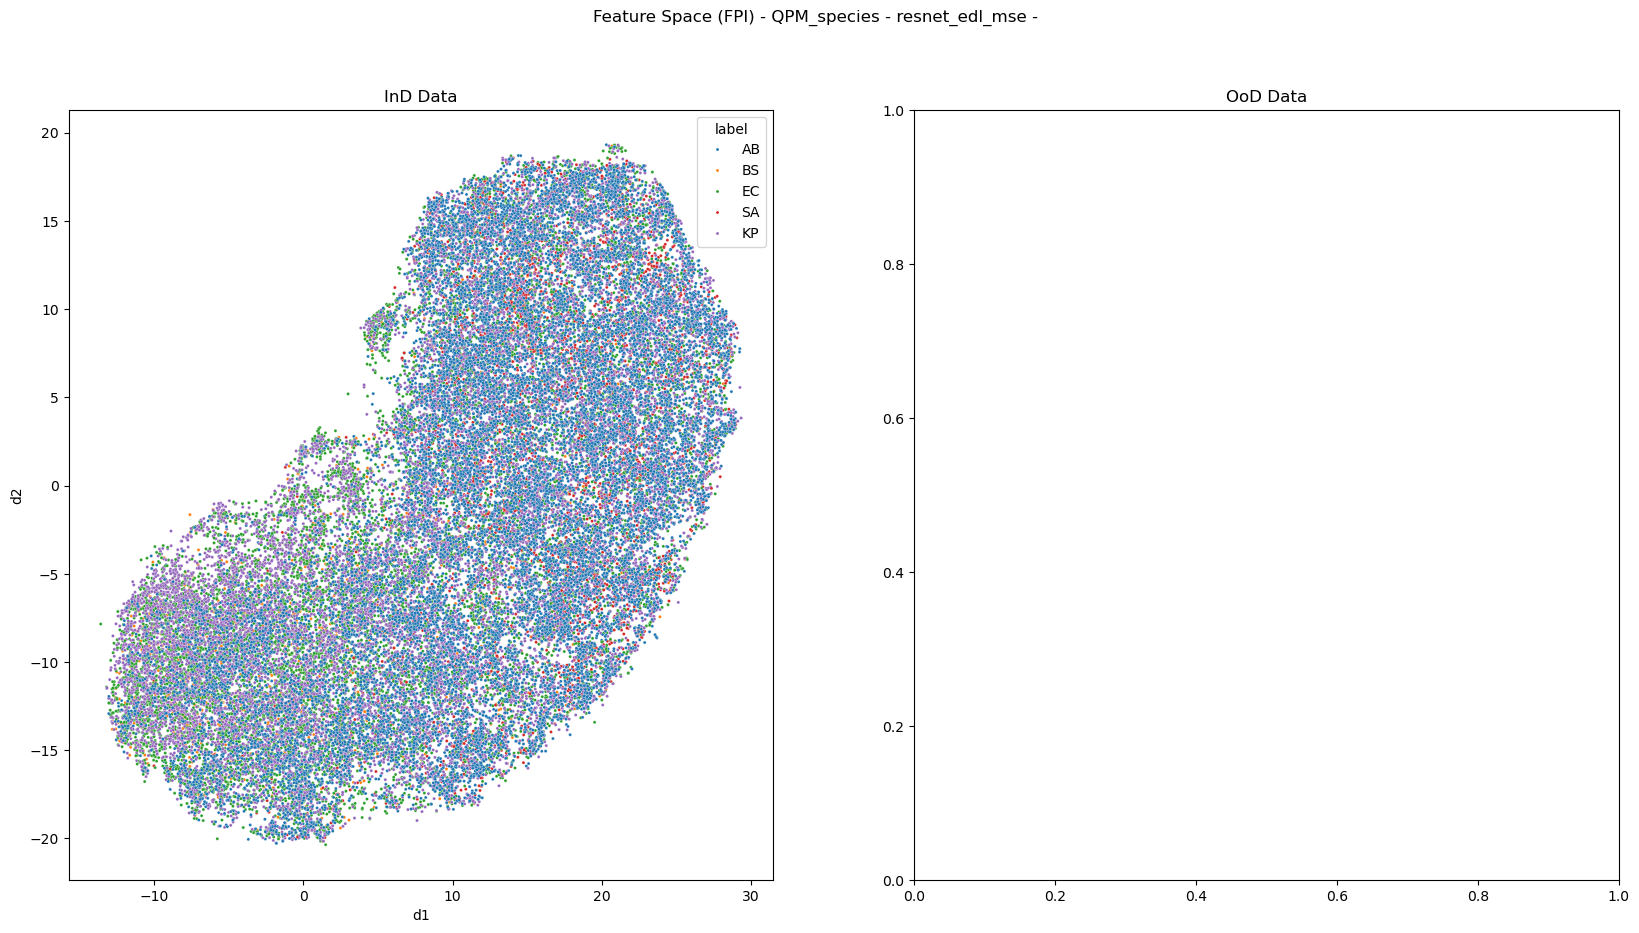

In [12]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

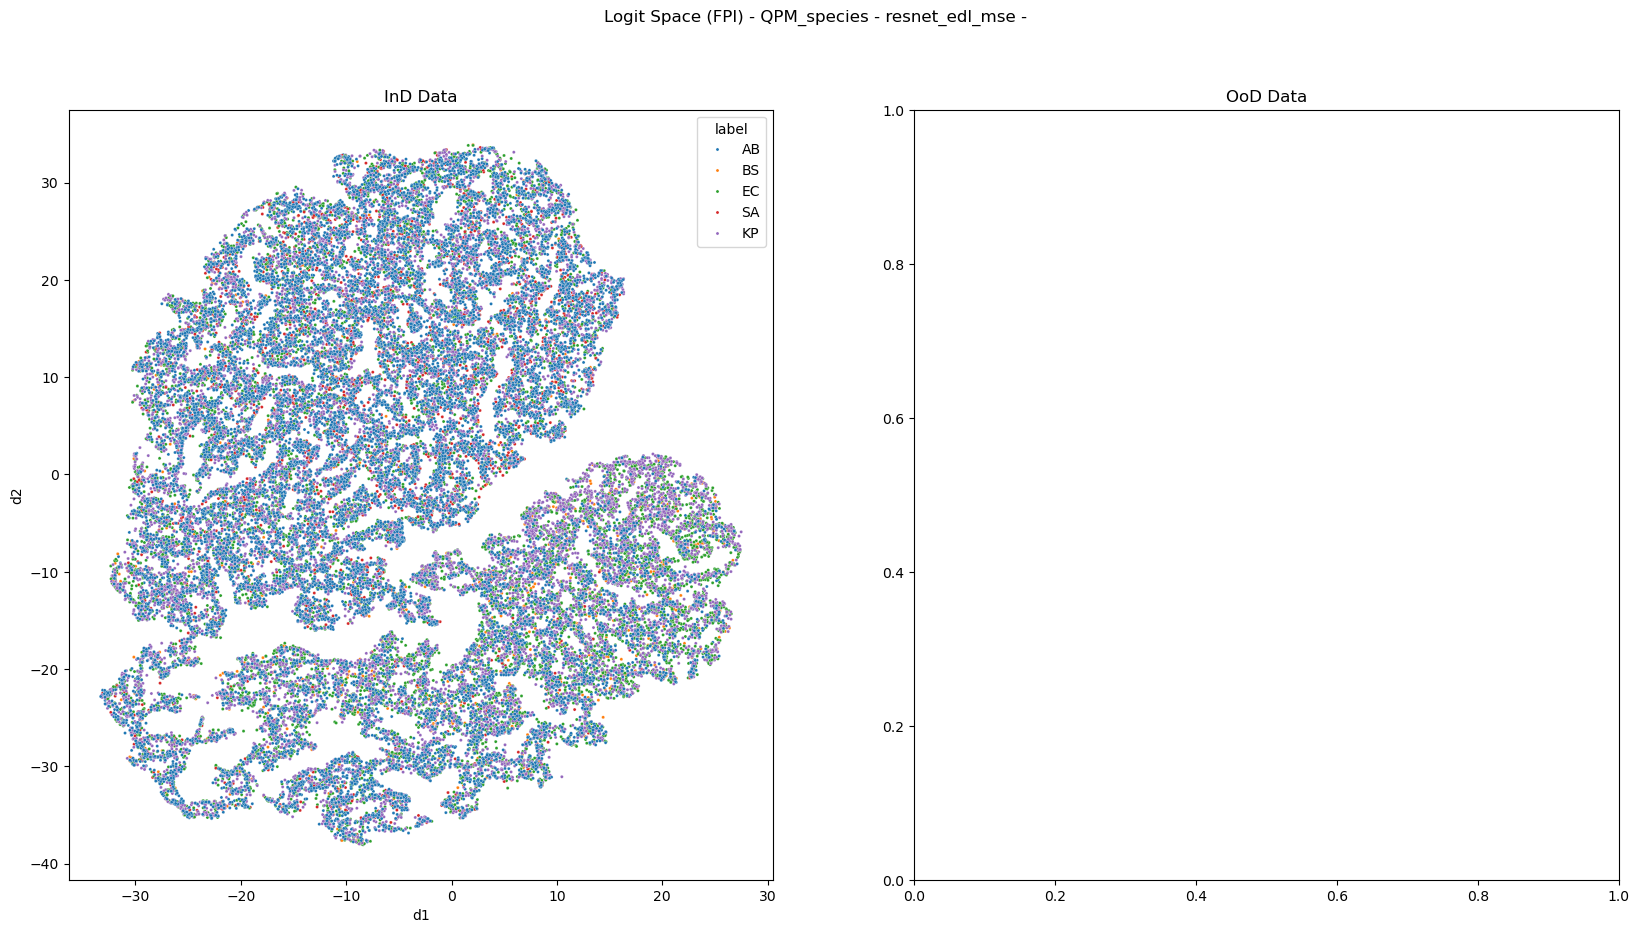

In [13]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:16<00:49, 16.41s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:32<00:32, 16.44s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:49<00:16, 16.53s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:06<00:00, 16.76s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:06<00:00, 16.65s/it]

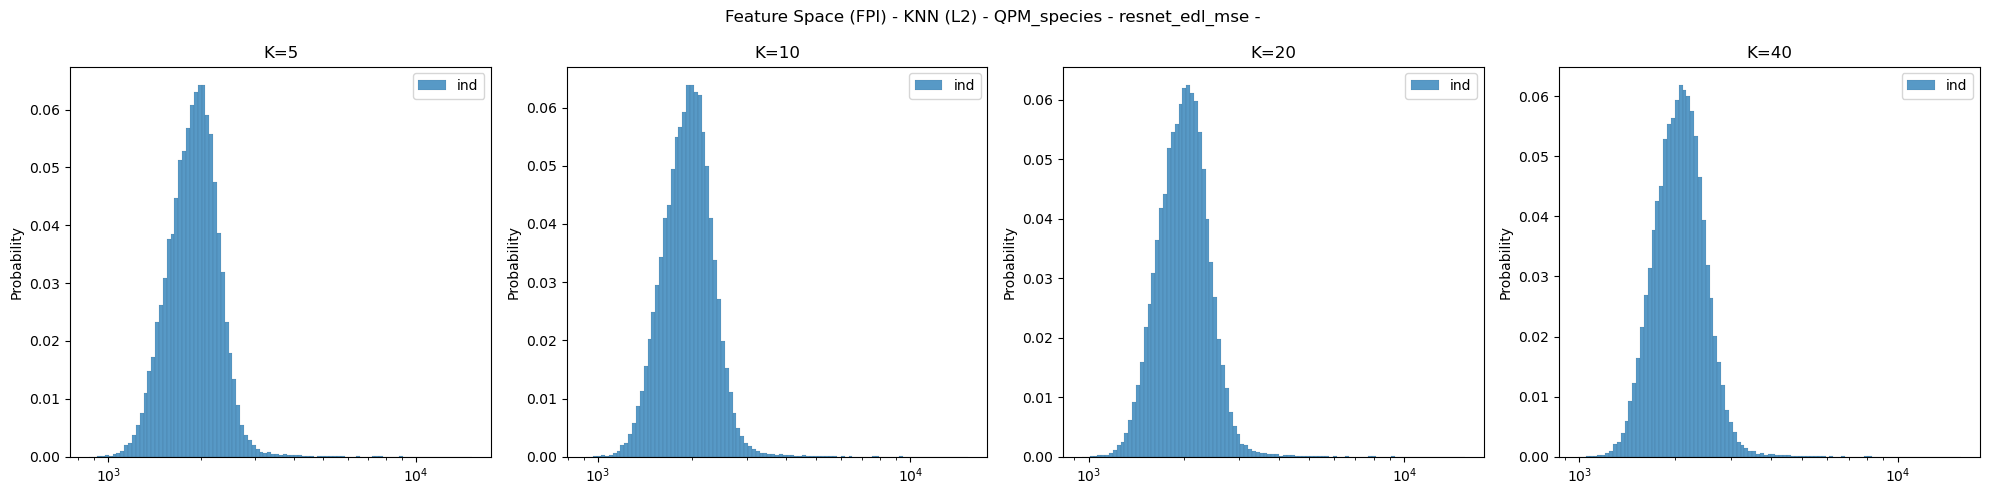

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:16<00:48, 16.09s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:32<00:32, 16.14s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:48<00:16, 16.25s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.52s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.40s/it]

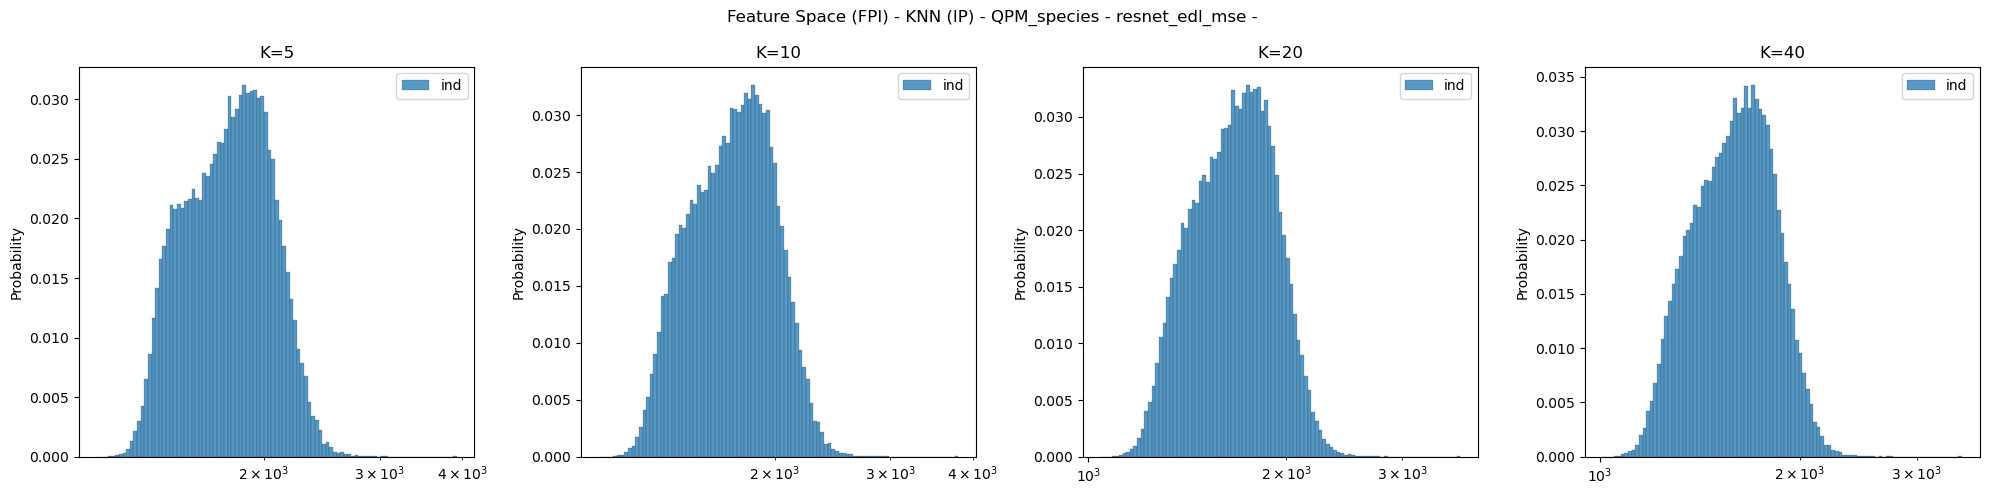

In [15]:
# check knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:16<00:49, 16.43s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:32<00:32, 16.45s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:49<00:16, 16.53s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:06<00:00, 16.69s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:06<00:00, 16.62s/it]

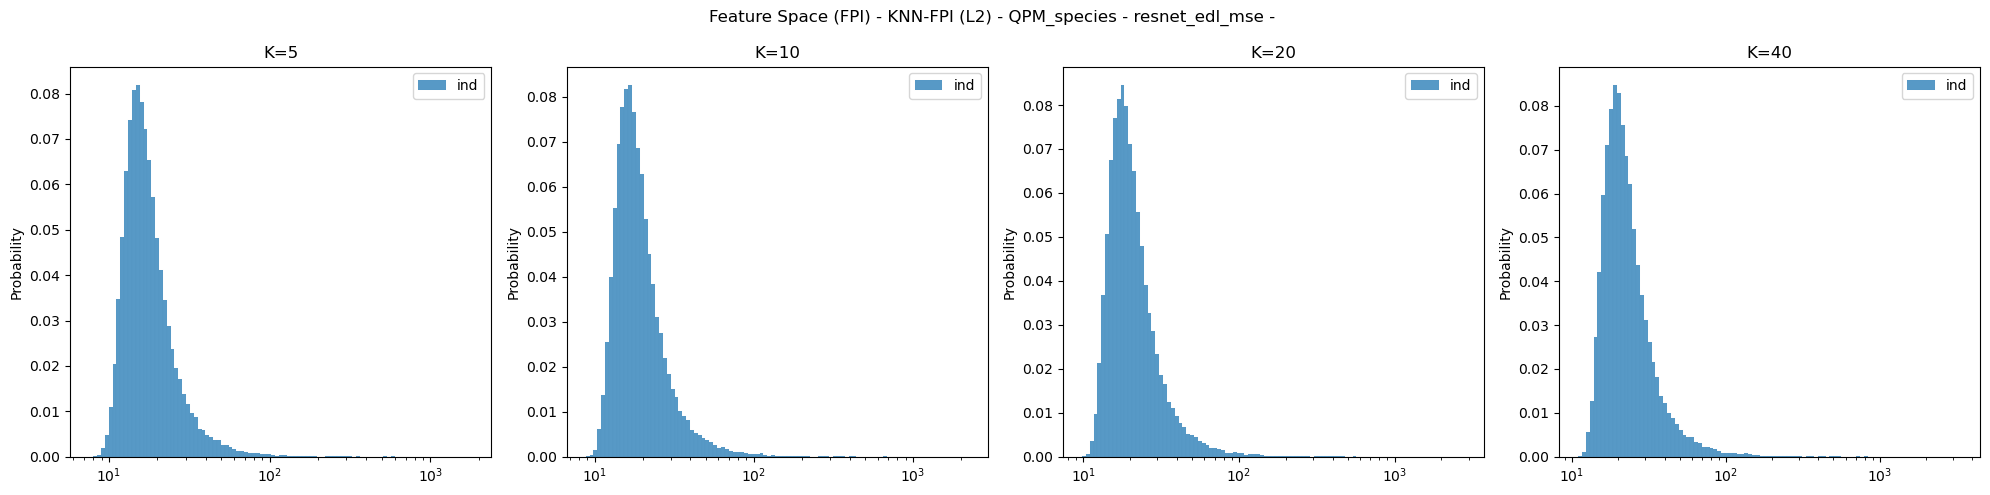

In [16]:
# check knn to val data FPI in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:16<00:48, 16.08s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:32<00:32, 16.12s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:48<00:16, 16.20s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.34s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.27s/it]

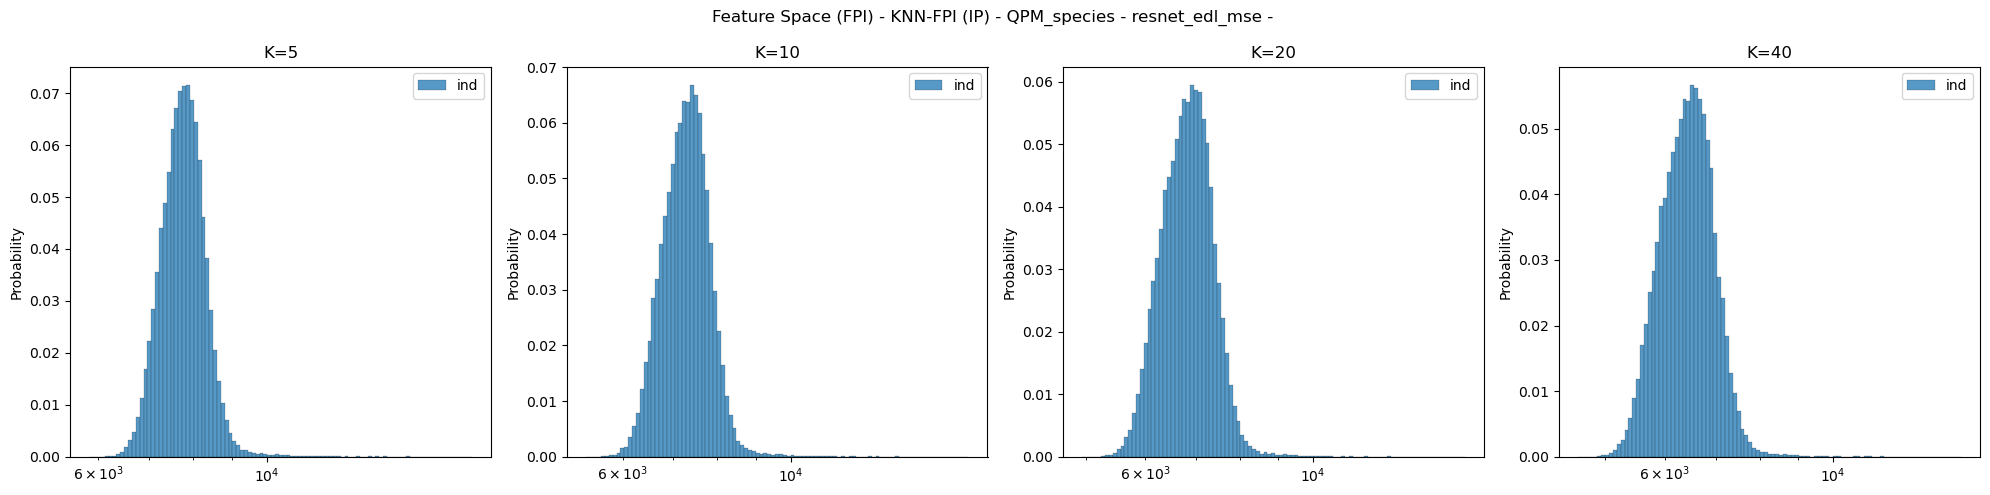

In [17]:
# check knn to val data FPI in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:02<00:07,  2.47s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:04<00:04,  2.38s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:07<00:02,  2.45s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.64s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.56s/it]

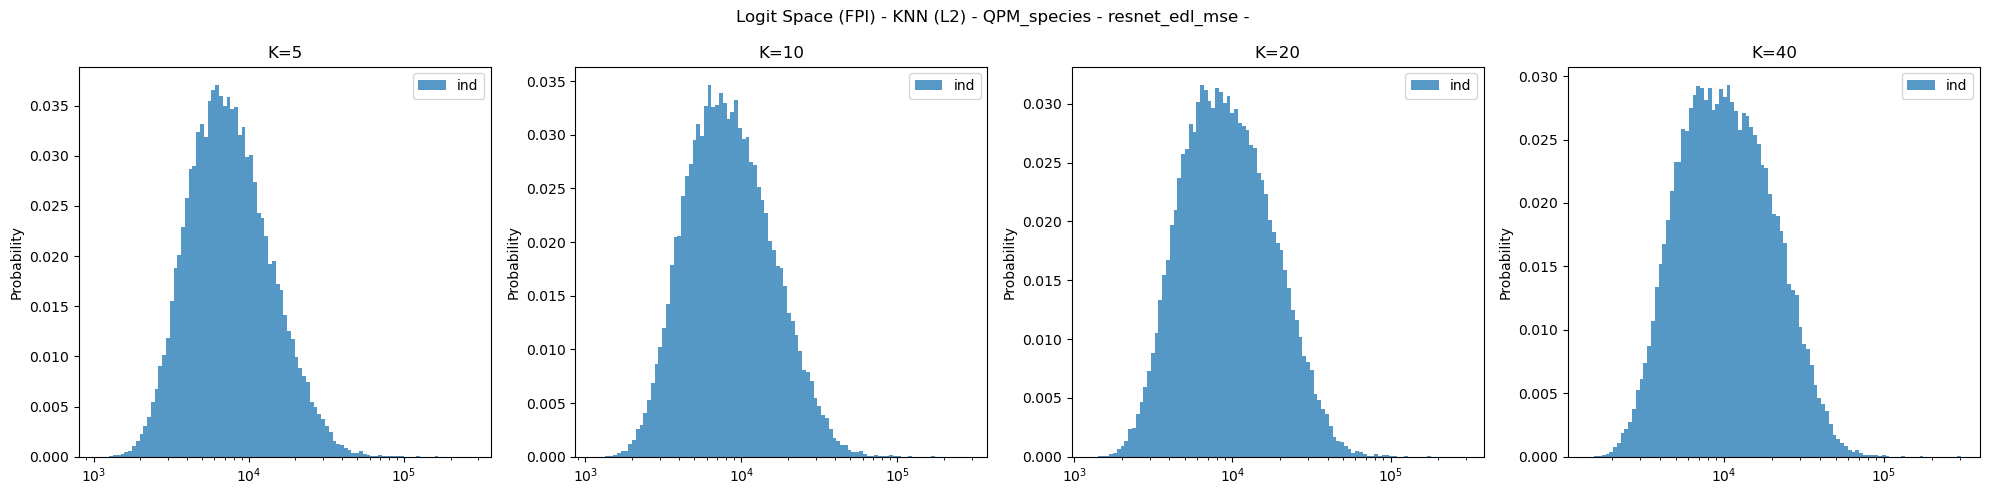

In [18]:
# check knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:01<00:05,  1.94s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:03<00:03,  1.97s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:06<00:02,  2.08s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.30s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.20s/it]

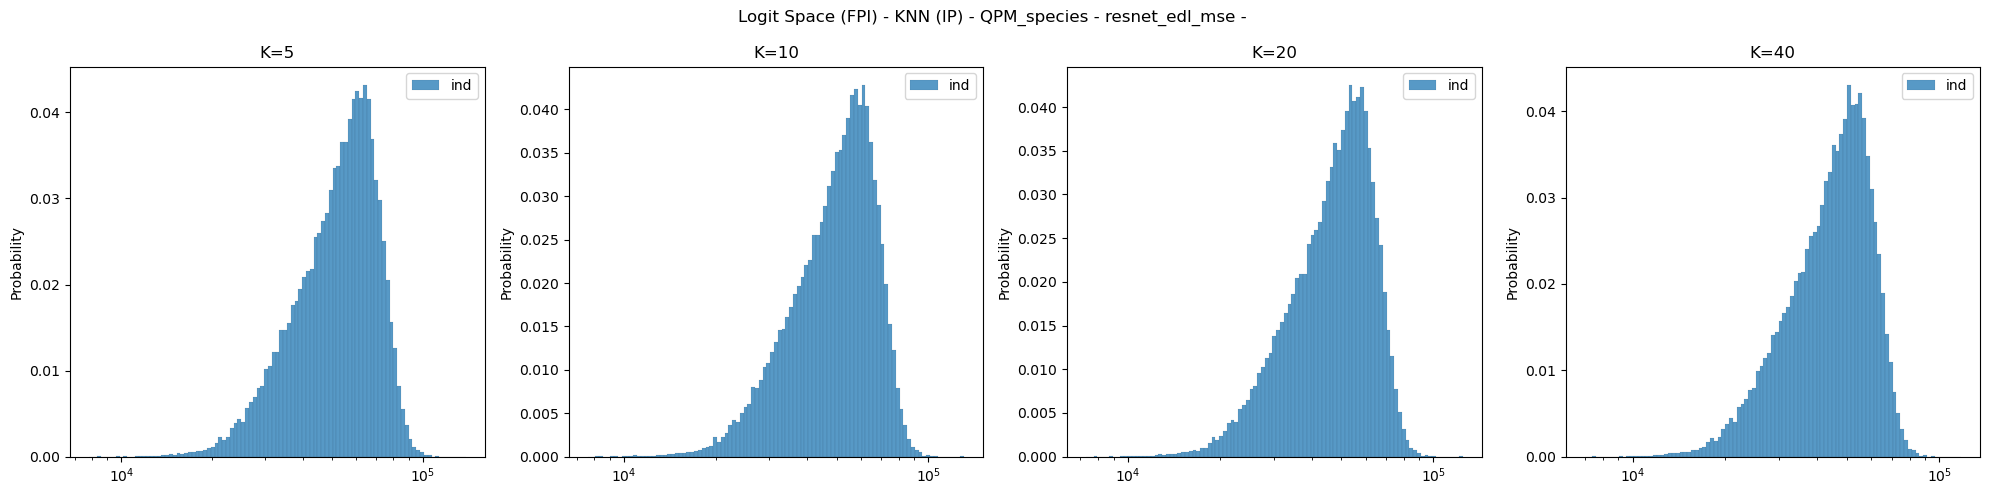

In [19]:
# check knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:02<00:06,  2.24s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:04<00:04,  2.28s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:06<00:02,  2.36s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.52s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.44s/it]

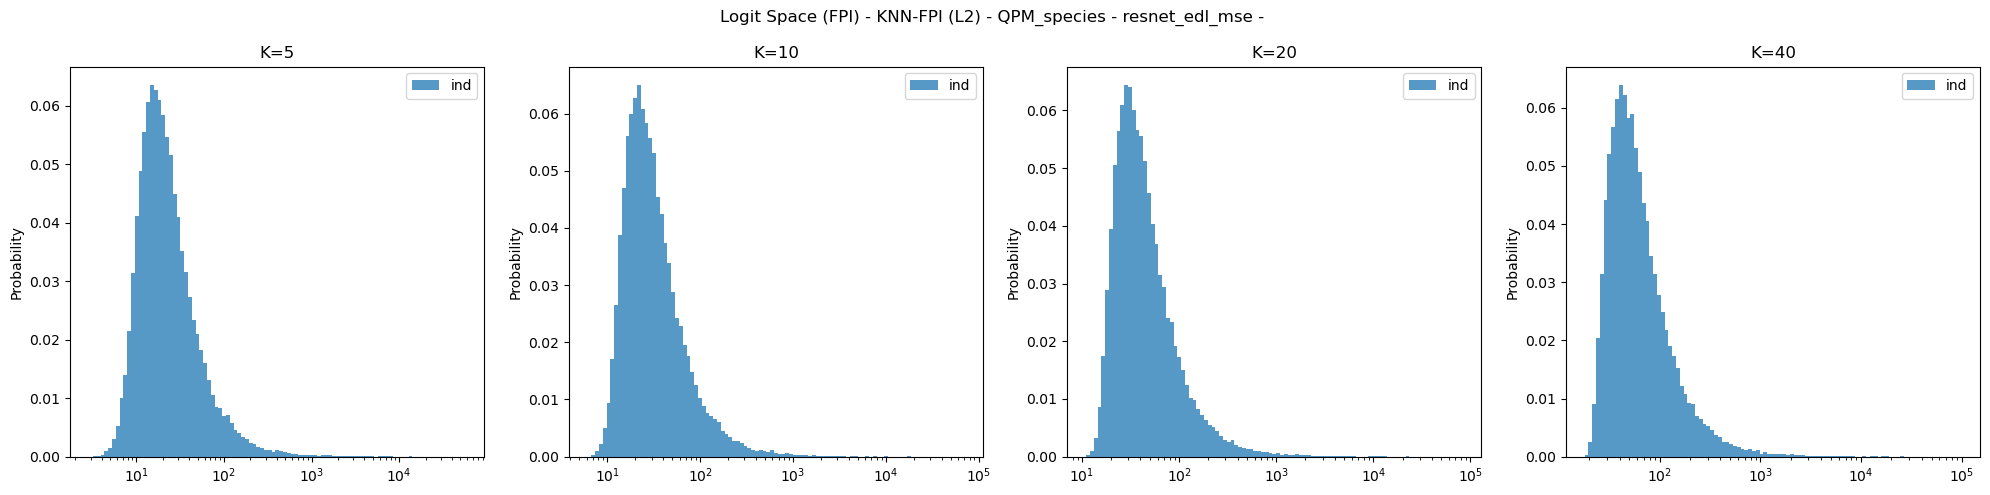

In [20]:
# check knn to val data FPI in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 1/4 [00:01<00:05,  1.93s/it]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:03<00:03,  1.96s/it]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3/4 [00:06<00:02,  2.03s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.19s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it]

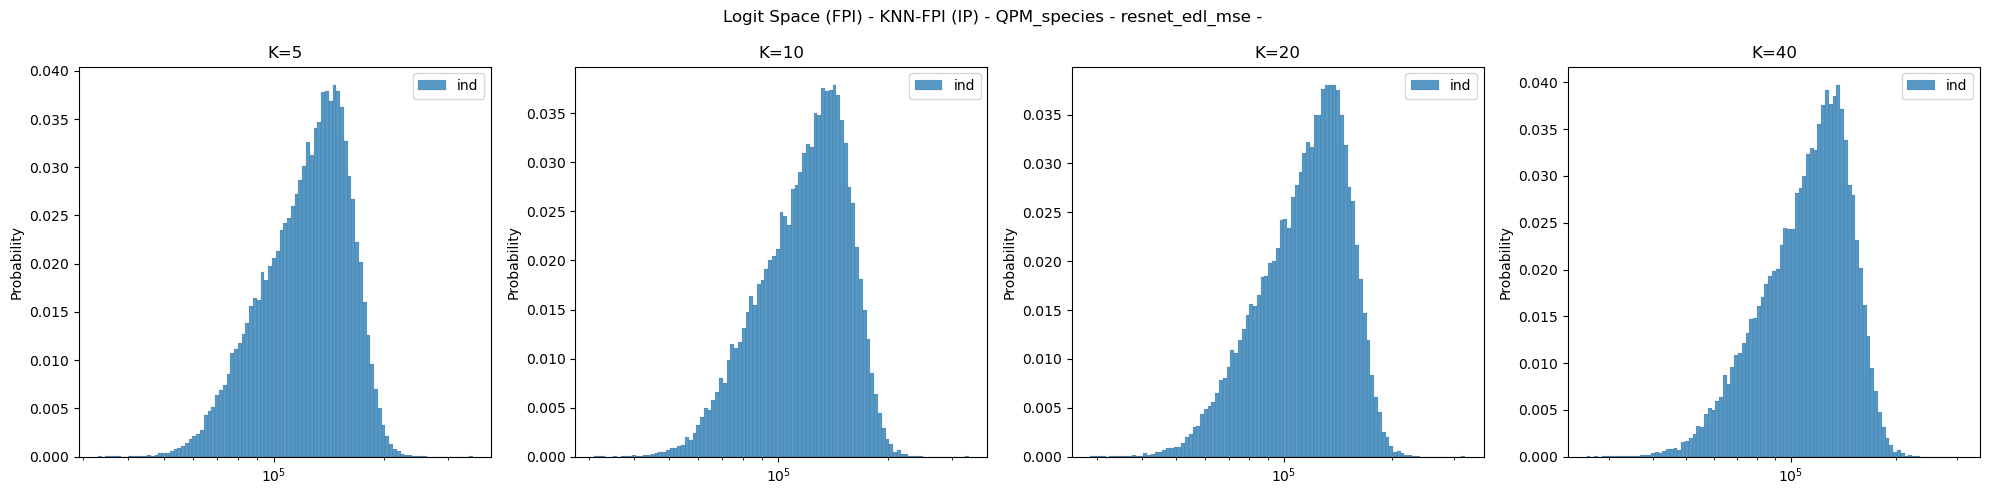

In [21]:
# check knn to val data FPI in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

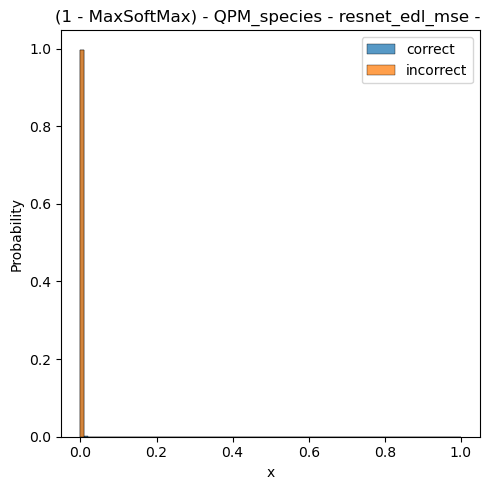

In [22]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

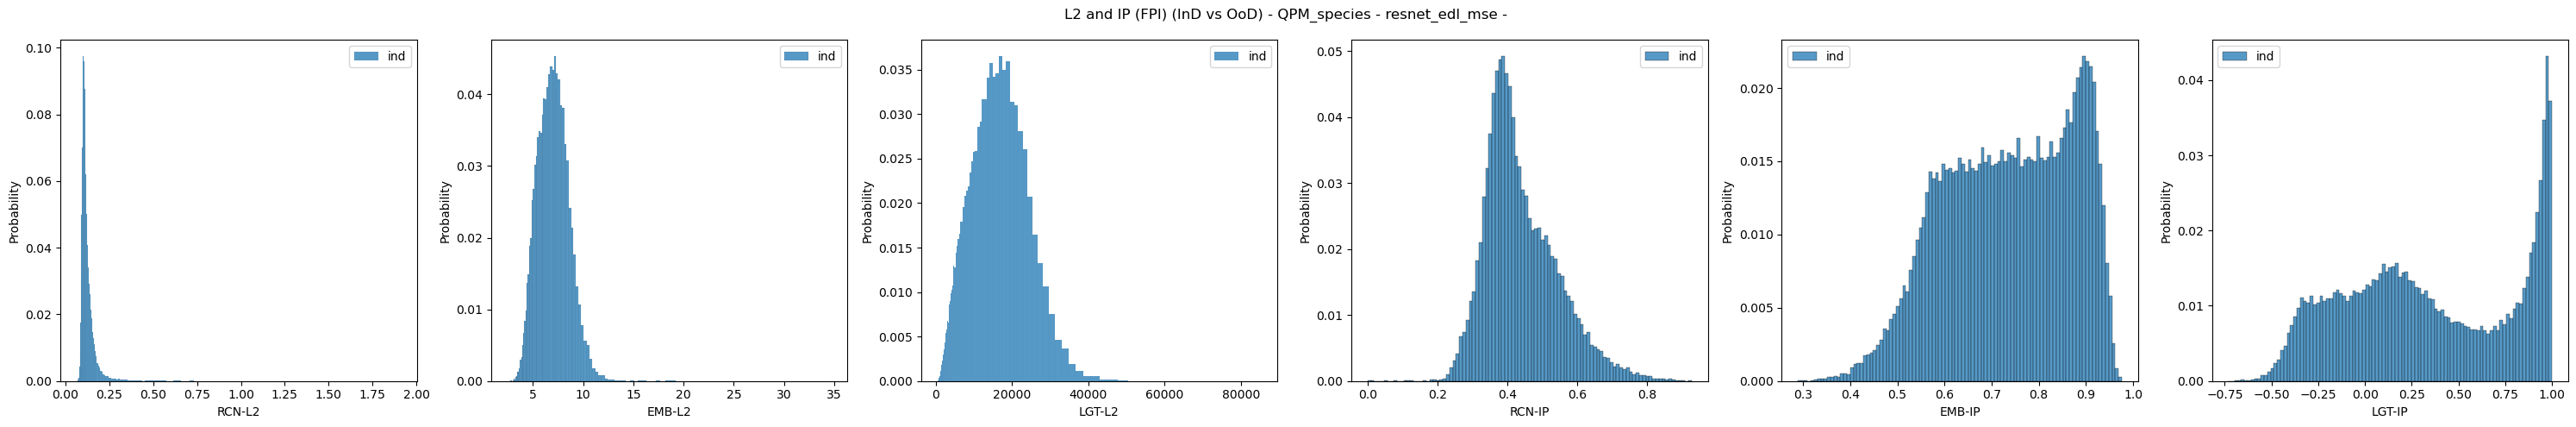

In [23]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_emb = ind_emb.reshape(si)
_ind_lgt = ind_lgt.reshape(si)
_ind_rcn_fpi = ind_rcn_fpi.reshape(si)
_ind_emb_fpi = ind_emb_fpi.reshape(si)
_ind_lgt_fpi = ind_lgt_fpi.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
_ind_emb_unit = _ind_emb / (np.linalg.norm(_ind_emb, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_unit = _ind_lgt / (np.linalg.norm(_ind_lgt, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_fpi_unit = _ind_rcn_fpi / (np.linalg.norm(_ind_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_emb_fpi_unit = _ind_emb_fpi / (np.linalg.norm(_ind_emb_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_fpi_unit = _ind_lgt_fpi / (np.linalg.norm(_ind_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)
# store
_df = pd.DataFrame(dict(
    target=ind_tgt,
    rcn_l2=ind_rcn_l2_fpi,
    emb_l2=ind_emb_l2_fpi,
    lgt_l2=ind_lgt_l2_fpi,
    rcn_ip=ind_rcn_ip_fpi,
    emb_ip=ind_emb_ip_fpi,
    lgt_ip=ind_lgt_ip_fpi,
    source="ind",
))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_emb = ood_emb.reshape(so)
    _ood_lgt = ood_lgt.reshape(so)
    _ood_rcn_fpi = ood_rcn_fpi.reshape(so)
    _ood_emb_fpi = ood_emb_fpi.reshape(so)
    _ood_lgt_fpi = ood_lgt_fpi.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_unit = _ood_emb / (np.linalg.norm(_ood_emb, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_unit = _ood_lgt / (np.linalg.norm(_ood_lgt, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_fpi_unit = _ood_rcn_fpi / (np.linalg.norm(_ood_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_fpi_unit = _ood_emb_fpi / (np.linalg.norm(_ood_emb_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_fpi_unit = _ood_lgt_fpi / (np.linalg.norm(_ood_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(
        target=ood_tgt,
        rcn_l2=ood_rcn_l2_fpi,
        emb_l2=ood_emb_l2_fpi,
        lgt_l2=ood_lgt_l2_fpi,
        rcn_ip=ood_rcn_ip_fpi,
        emb_ip=ood_emb_ip_fpi,
        lgt_ip=ood_lgt_ip_fpi,
        source="ood",
    ))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_emb_l2 = np.logspace(np.log10(df_rstat['emb_l2'].min() + 1e-7), np.log10(df_rstat['emb_l2'].max()), 100)
bins_lgt_l2 = np.logspace(np.log10(df_rstat['lgt_l2'].min() + 1e-7), np.log10(df_rstat['lgt_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
bins_emb_ip = np.linspace(df_rstat['emb_ip'].min(), df_rstat['emb_ip'].max(), 100)
bins_lgt_ip = np.linspace(df_rstat['lgt_ip'].min(), df_rstat['lgt_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax1.set_xlabel("RCN-L2")
ax2.set_xlabel("EMB-L2")
ax3.set_xlabel("LGT-L2")
ax4.set_xlabel("RCN-IP")
ax5.set_xlabel("EMB-IP")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()